In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import pyreadstat
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.cluster import hierarchy
from imblearn.over_sampling import SMOTENC , SMOTE, ADASYN ,RandomOverSampler,SVMSMOTE
from imblearn.pipeline import Pipeline
from imblearn.keras import balanced_batch_generator
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder,RobustScaler,MinMaxScaler
from sklearn.decomposition import KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score,zero_one_loss
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,permutation_test_score,train_test_split,cross_validate,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_selection import RFECV, mutual_info_classif,SelectPercentile ,mutual_info_regression,SequentialFeatureSelector
from sklearn.compose import ColumnTransformer 
from sklearn import set_config
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torch.nn as nn
from sklearn import feature_selection

In [2]:
torch.cuda.is_available()

True

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
file=files.upload()

Saving ML mortality_vareng.sav to ML mortality_vareng.sav


In [ ]:
df=pd.read_spss('/content/ML mortality_vareng.sav')
print(df ,'\n\n' ,df.isna().sum())

      deceased   age gender  ... other_chronic_lung  htn Epil1CNS2Other3No0
0            0  83.0     زن  ...                بلی  بلی                3.0
1            1  94.0     زن  ...                بلی  بلی                3.0
2            0  61.0     زن  ...                بلی  بلی                3.0
3            0  66.0     زن  ...                بلی  بلی                3.0
4            1  75.0    مرد  ...                بلی  بلی                3.0
...        ...   ...    ...  ...                ...  ...                ...
28911        0  91.0    مرد  ...                خیر  خیر                0.0
28912        0  92.0    مرد  ...                خیر  خیر                0.0
28913        0  92.0    مرد  ...                خیر  خیر                0.0
28914        0  93.0    مرد  ...                خیر  خیر                0.0
28915        0  95.0    مرد  ...                خیر  خیر                0.0

[28916 rows x 33 columns] 

 deceased                 0
age                      0
gend

In [ ]:
df.replace({'ندارد':0.,'دارد':1.,'خیر':0.,'بلی':1.,'زن':0.,'مرد':1.,'کمتر از 93 درصد':0.,'بیشتر از 93 درصد':1.},inplace=True)
df

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,seizure,headache,dizziness,chest_pain,abd_pain,nausea,vomiting,diarrhea,anorexia,smoking,Po2,cancer,chronic_liver_disease,diabetes,chronic_dishem,HIVAIDS,immune_deficient,pregnancy,discardio,dis_chronic_renal,asthma,other_chronic_lung,htn,Epil1CNS2Other3No0
0,0,83.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
1,1,94.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
2,0,61.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
3,0,66.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
4,1,75.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28911,0,91.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28912,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28913,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28914,0,93.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pyreadstat.write_sav(df,'ML mortality_processed.sav')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp 'ML mortality_processed.sav' '/content/drive/MyDrive/ML mortality_processed.sav'

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_spss('ML mortality_processed.sav').astype(np.float64)
print(df,' \n\n',df.isna().sum())

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  seizur

In [3]:
df['Po2']=np.where(df.loc[:,'Po2'].values==0,1,0)
asthma_indices=np.where(df.loc[:,'asthma'].values==1)[0]
df.loc[asthma_indices,'other_chronic_lung']=1

df.drop(['asthma','Epil1CNS2Other3No0','smoking','HIVAIDS','immune_deficient'],axis=1,inplace=True)

In [4]:
df.drop(df[df['age']<18].index,axis=0,inplace=True)
print(df)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  seizur

In [5]:
#checking external consistency
x=df.loc[df['gender']==1,'pregnancy']
ext=np.where(x.values==1,x.index,0)
ext=ext[np.where(ext!=0)[0]]
print(ext)

[9045]


In [6]:
#checking external consistency
df.loc[ext,:]

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,seizure,...,Po2,cancer,chronic_liver_disease,diabetes,chronic_dishem,pregnancy,discardio,dis_chronic_renal,other_chronic_lung,htn
9045,0.0,30.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
df_ext=df.drop(labels=ext[0],axis=0)
df_ext.drop(['pregnancy'],axis=1,inplace=True)
print(df_ext)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  seizur

In [8]:
df_ext.describe()

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,seizure,...,anorexia,Po2,cancer,chronic_liver_disease,diabetes,chronic_dishem,discardio,dis_chronic_renal,other_chronic_lung,htn
count,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,...,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000
mean,0.096904,55.423443,0.519039,0.329482,0.454400,0.361929,0.530303,0.017840,0.010828,0.001417,...,0.108895,0.628261,0.018276,0.004905,0.153586,0.004106,0.122557,0.022455,0.039169,0.223240
std,0.295833,17.971245,0.499646,0.470034,0.497925,0.480567,0.499090,0.132373,0.103493,0.037618,...,0.311513,0.483278,0.133951,0.069866,0.360558,0.063946,0.327933,0.148160,0.194000,0.416425
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,56.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,105.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


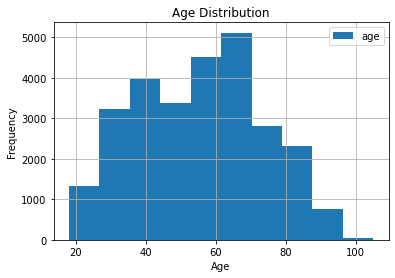

In [9]:
df_ext['age'].hist(legend=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [10]:
ks,p=stats.kstest(rvs=df_ext['age'].values,cdf='norm',alternative='two-sided', mode='auto')
ks,p

(1.0, 0.0)

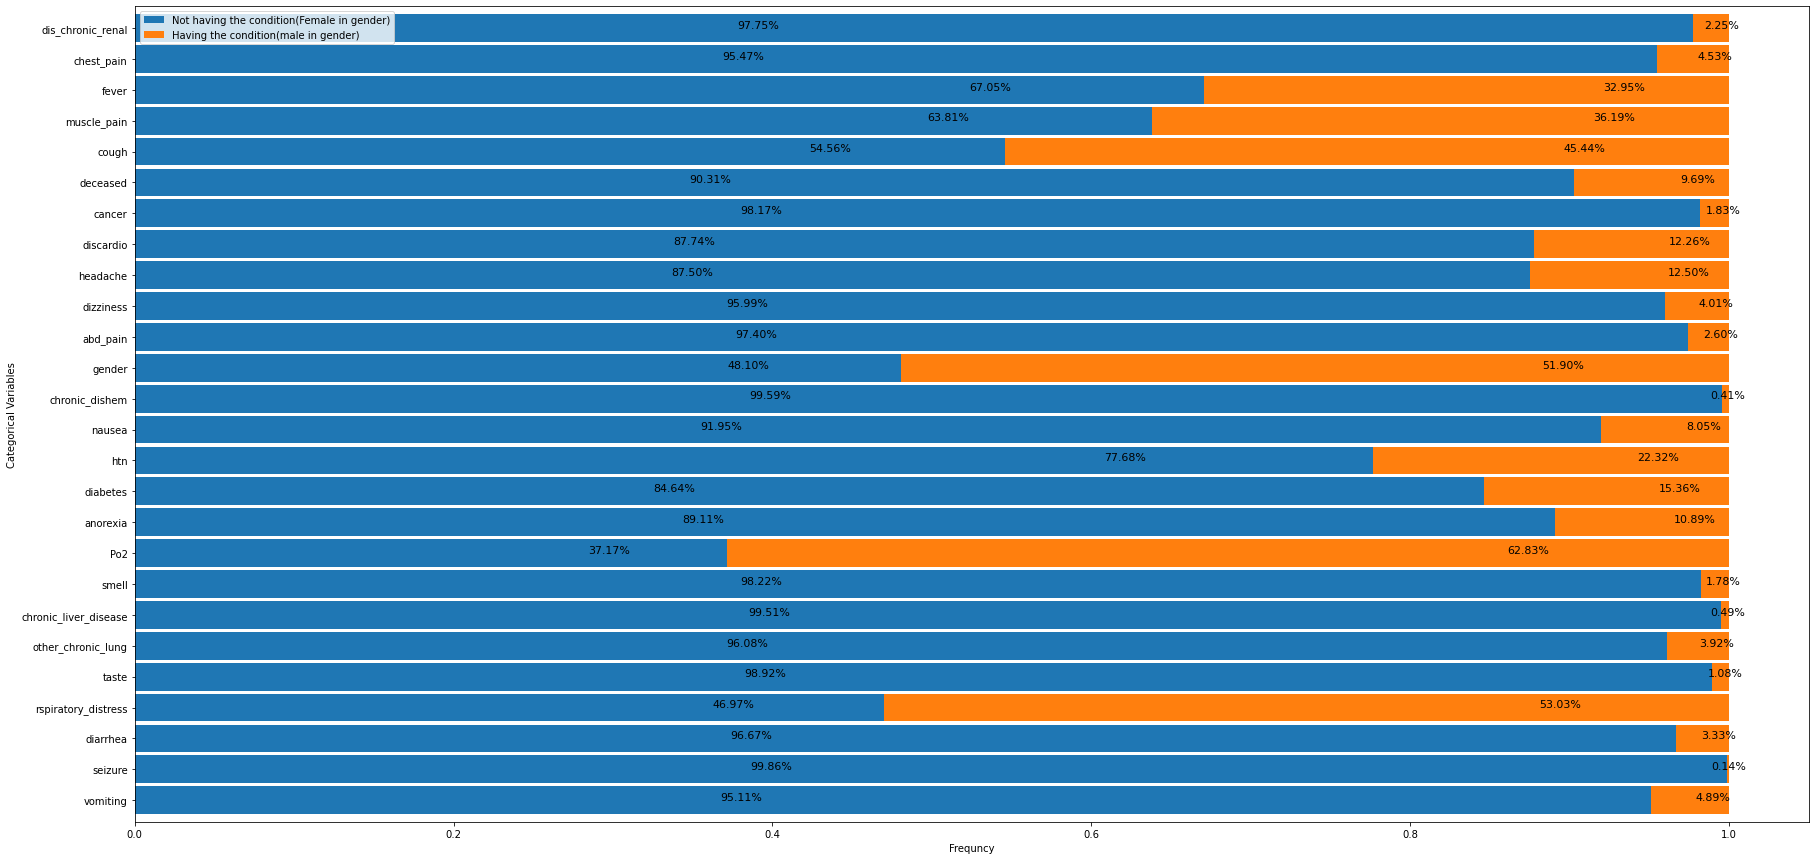

In [11]:
df_stacked=pd.DataFrame({'Not having the condition(Female in gender)':[df_ext.loc[:,i].isin([0.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]
                         ,'Having the condition(male in gender)':[df_ext.loc[:,i].isin([1.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]},
                        index=set(df_ext.columns.to_list())-{'age'})
 
df_stacked_normalized=df_stacked.div(df_stacked.sum(axis=1),axis=0)



plot=df_stacked_normalized.plot(kind='barh',stacked=True,rot=0,width=0.9,figsize=(30,15))


for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if width==0:
        continue
    if width<0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.8*width, y + height/2), ha='center',fontsize=11)
    if width>=0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.4*width, y + height/2), ha='center',fontsize=11)
    

    
plot.set_xlabel('Frequncy')
plot.set_ylabel('Categorical Variables')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#pyreadstat.write_sav(df1,'preprocessed.sav')

In [12]:
x_train,x_test,y_train,y_test = train_test_split(df_ext.iloc[:,1:].values,df_ext.iloc[:,0].values,
                                                 test_size=0.2,stratify=df_ext.iloc[:,0].values,random_state=42)

In [13]:
x_train

array([[56.,  0.,  0., ...,  0.,  0.,  0.],
       [58.,  0.,  0., ...,  0.,  0.,  0.],
       [41.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [35.,  1.,  0., ...,  0.,  0.,  0.],
       [62.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  1.,  1., ...,  0.,  0.,  0.]])

In [14]:
x_train.shape ,x_test.shape

((22017, 26), (5505, 26))

In [15]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [16]:
column_transfromer=ColumnTransformer([('minmax',MinMaxScaler(),[0]),
                                      ('pass','passthrough',np.arange(1,26))])
set_config(display='diagram')
column_transfromer

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25]))])

In [17]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',svm.SVC(class_weight='balanced'))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3311 1661]
 [ 121  412]] 0.719456158993176


In [18]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3416 1556]
 [ 121  412]] 0.7300152901275284


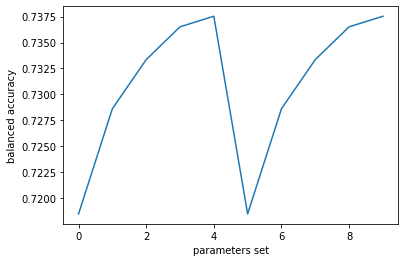

In [19]:
parameters=[(5,15),(5,35),(5,55),(5,75),(5,100),(10,15),(10,35),(10,55),(10,75),(5,100)]

scores_calculated=[]

for i,j in parameters:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                                   discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    mean=np.mean(cross_val_scores)
    scores_calculated.append(mean)

plt.plot(scores_calculated)
plt.xlabel('parameters set')
plt.ylabel('balanced accuracy')
plt.show()

In [55]:



a=[]

for i,j in [(5,70),(5,100)]:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced'))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    
    a.append(cross_val_scores)
    
    
u,p=stats.wilcoxon(a[0],a[1],zero_method='zsplit',mode='auto')

print (f' 70% of best features:{np.mean(a[0])}+/-{np.std(a[0])}\n\n whole features:{np.mean(a[1])}+/-{np.std(a[1])}\n\nwilcoxon:{u},{p}')

 70% of best features:0.736332206458185+/-0.013459195162921052

 whole features:0.7375383403497249+/-0.015007300619251467

wilcoxon:16.0,0.275390625


In [32]:
x_train_transfromer=column_transfromer.fit_transform(x_train)
x_test_transfromer=column_transfromer.transform(x_test)

In [33]:
x_train_transfromer[:,0].min()

0.0

In [35]:
def Feature_selection(x,y,n_neighbors=5,random_state=42):
    
    return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)

scores=SelectPercentile(Feature_selection,percentile=70)

result_train=scores.fit_transform(x_train_transfromer,y_train)
result_test=scores.transform(x_test_transfromer)

print(result_train.shape,result_test.shape,np.argsort(scores.scores_)[::-1])

(22017, 18) (5505, 18) [ 0 17  5 25 22 20  4  3  9  2 23 18 13  6 10  1 19 15 14 24  7 11 21 12
 16  8]


In [36]:
indices=np.argsort(scores.scores_)[:-19:-1]
indices

array([ 0, 17,  5, 25, 22, 20,  4,  3,  9,  2, 23, 18, 13,  6, 10,  1, 19,
       15], dtype=int64)

In [17]:
columns=np.array([                  'Age',                'Gender',                 'Fever',
                 'Cough',           'Muscle pain',   'Respiratory distress',
                 'Loss of smell',                 'Loss of taste',               'Seizure',
              'Headache',             'Dizziness',            'Chest pain',
              'Abdominal pain',                'Nausea',              'Vomiting',
              'Diarrhea',              'Anorexia',               
                   'O2 saturation under 93',                'Cancer', 'Liver disease',
              'Diabetes',        'Hematology disease',               
                  'Cardiac disease',
     'Renal disease',    'Pulmonary disease',                   'Hypertension'])
columns

array(['Age', 'Gender', 'Fever', 'Cough', 'Muscle pain',
       'Respiratory distress', 'Loss of smell', 'Loss of taste',
       'Seizure', 'Headache', 'Dizziness', 'Chest pain', 'Abdominal pain',
       'Nausea', 'Vomiting', 'Diarrhea', 'Anorexia',
       'O2 saturation under 93', 'Cancer', 'Liver disease', 'Diabetes',
       'Hematology disease', 'Cardiac disease', 'Renal disease',
       'Pulmonary disease', 'Hypertension'], dtype='<U22')

In [18]:
x_train_f=x_train[:,[ 0, 17,  5, 25, 22, 20,  4,  3,  9,  2, 23, 18, 13,  6, 10,  1, 19,15]]
x_test_f=x_test[:,[ 0, 17,  5, 25, 22, 20,  4,  3,  9,  2, 23, 18, 13,  6, 10,  1, 19,15]]

In [19]:
column_transfromer_f=ColumnTransformer([('minmax',MinMaxScaler(),[0]),('pass','passthrough',np.arange(1,18))])
column_transfromer_f

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))])

In [20]:
col=columns[[ 0, 17,  5, 25, 22, 20,  4,  3,  9,  2, 23, 18, 13,  6, 10,  1, 19,15]]

In [21]:
col,col.shape

(array(['Age', 'O2 saturation under 93', 'Respiratory distress',
        'Hypertension', 'Cardiac disease', 'Diabetes', 'Muscle pain',
        'Cough', 'Headache', 'Fever', 'Renal disease', 'Cancer', 'Nausea',
        'Loss of smell', 'Dizziness', 'Gender', 'Liver disease',
        'Diarrhea'], dtype='<U22'),
 (18,))

In [56]:
df.columns[[1,2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]]

Index(['age', 'gender', 'fever', 'cough', 'muscle_pain', 'rspiratory_distress',
       'smell', 'headache', 'dizziness', 'nausea', 'diarrhea', 'Po2', 'cancer',
       'chronic_liver_disease', 'diabetes', 'discardio', 'dis_chronic_renal',
       'htn'],
      dtype='object')

In [79]:
pd.crosstab(df[['rspiratory_distress']].values.flatten(),df[['Po2']].values.flatten())

col_0,0,1
row_0,,
0.0,6843,6085
1.0,3389,11206


In [58]:
for i in df.columns[[2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]].values:
    cross_tab=pd.crosstab(df[[i]].values.flatten(),df[['deceased']].values.flatten())
    odds,p=stats.fisher_exact(cross_tab)
    print(f'odds ratio_{i}:{odds}\tp_value_{i}:{p}')
        

odds ratio_gender:1.2465668408595025	p_value_gender:8.029681199862212e-08
odds ratio_fever:0.6320750266537093	p_value_fever:9.876095439508295e-24
odds ratio_cough:0.5792569175364954	p_value_cough:1.874615886269487e-38
odds ratio_muscle_pain:0.5297523302681622	p_value_muscle_pain:8.176351133515341e-45
odds ratio_rspiratory_distress:3.0357248348631596	p_value_rspiratory_distress:4.446710936254744e-141
odds ratio_smell:0.28969732689455874	p_value_smell:1.9239430351216596e-08
odds ratio_headache:0.3992125847081163	p_value_headache:8.020355341825184e-34
odds ratio_dizziness:0.5154728182698799	p_value_dizziness:1.0316974464355787e-07
odds ratio_nausea:0.5886928968714824	p_value_nausea:5.640624747076574e-10
odds ratio_diarrhea:0.48329508504786256	p_value_diarrhea:2.0100898908329654e-07
odds ratio_Po2:6.765778870135507	p_value_Po2:1.0067602665497275e-264
odds ratio_cancer:2.7102136629299607	p_value_cancer:9.260995645797038e-17
odds ratio_chronic_liver_disease:3.2920212765957446	p_value_chronic

In [62]:
clf=Pipeline([('transformation',column_transfromer_f),
              ('classification',LogisticRegression(class_weight='balanced',max_iter=500,penalty='none'))])

clf.fit(x_train_f,y_train)
preds=clf.predict(x_test_f)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3416 1556]
 [ 120  413]] 0.7309533764314684


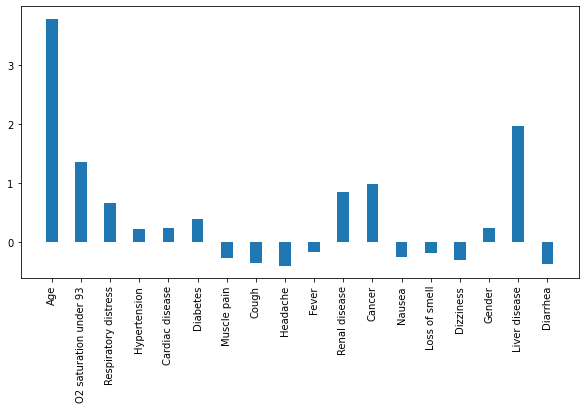

In [63]:
fig = plt.figure(figsize = (10, 5))
plt.bar(list(col),clf['classification'].coef_.flatten(),width=0.4)
plt.xticks(rotation=90)
plt.show()

In [64]:
clf=Pipeline([('transformation',column_transfromer_f),
              ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
clf.fit(x_train_f,y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  [0]),
                                                 ('pass', 'passthrough',
                                                  array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))])),
                ('classification',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [65]:
# permutation logistic

score_random, perm_random, pvalue_random = permutation_test_score(
  clf ,x_train_f, y_train, scoring="balanced_accuracy", cv=skf, n_permutations=100,n_jobs=-1)

In [66]:
pvalue_random

0.009900990099009901

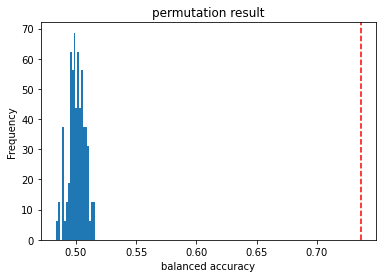

In [67]:
fig, ax = plt.subplots()
ax.hist(perm_random, bins=20, density=True)
ax.axvline(score_random, ls='--', color='r')
plt.xlabel('balanced accuracy')
plt.ylabel('Frequency')
plt.title('permutation result')
plt.show()

In [22]:
column_importance=list(col)
column_importance=np.array(column_importance)

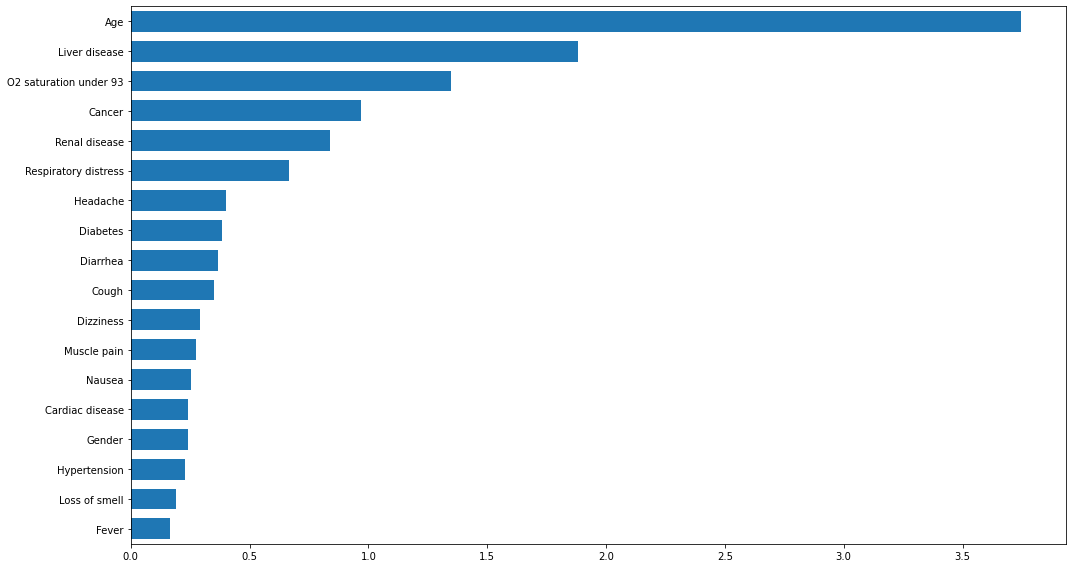

In [69]:


tree_importance_sorted_idx = np.argsort(np.abs(clf['classification'].coef_.flatten()))
tree_indices = np.arange(0, np.abs(clf['classification'].coef_.flatten()).shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         np.abs(clf['classification'].coef_.flatten())[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,np.abs(clf['classification'].coef_.flatten()).shape[0]))


fig.tight_layout()
plt.show()

In [63]:

mask_discrete=np.ones(x_train_f.shape[1],dtype=bool)
mask_discrete[0]=False

array_features=mutual_info_regression(x_train_f,x_train_f[:,0],
                                 discrete_features=mask_discrete,n_neighbors=5,random_state=42)

array_features=array_features.reshape(1,-1)



for i in range(1,x_train_f.shape[1]):
    
    
    mi_score=mutual_info_classif(x_train_f,x_train_f[:,i],
                        discrete_features=mask_discrete,n_neighbors=5,random_state=42)
    
    mi_score=mi_score.reshape(1,-1)
    
    array_features=np.append(array_features,mi_score,axis=0)
    
    
print(array_features.shape)

(18, 18)


In [66]:
df_odds=pd.DataFrame(np.zeros(shape=(17,17)),index=df.columns[[2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]].values,
                     columns=df.columns[[2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]].values)

for s,i in enumerate(df.columns[[2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]].values):
    for b,j in enumerate(df.columns[[2,3,4,5,6,7,10,11,14,16,18,19,20,21,24,25,27]].values):
        cross_tab=pd.crosstab(df[[i]].values.flatten(),df[[j]].values.flatten())
        odds,p=stats.fisher_exact(cross_tab)
        df_odds.iloc[s,b]=odds
        
        
df_odds

,gender,fever,cough,muscle_pain,rspiratory_distress,smell,headache,dizziness,nausea,diarrhea,Po2,cancer,chronic_liver_disease,diabetes,discardio,dis_chronic_renal,htn
gender,inf,1.114364,0.928242,0.901075,1.060400,0.705537,0.861585,0.879382,0.707262,1.041662,1.053067,1.083923,1.269411,0.678120,0.967032,1.402177,0.625383
fever,1.114364,inf,1.330447,1.758617,0.494139,1.507460,1.526672,1.216839,1.404074,1.746838,0.852006,0.913462,0.796433,0.979079,0.951489,0.995419,0.946864
cough,0.928242,1.330447,inf,1.665390,0.876388,1.260871,1.233426,0.927584,0.939294,0.783987,1.077356,0.421060,0.705061,1.046261,0.911482,0.686523,0.993297
muscle_pain,0.901075,1.758617,1.665390,inf,0.517489,2.061757,2.346172,1.232820,1.507435,1.411345,0.842985,0.383788,0.459847,0.986977,0.954400,0.725252,0.954088
rspiratory_distress,1.060400,0.494139,0.876388,0.517489,inf,0.336576,0.466920,0.545384,0.535884,0.438283,3.718476,1.210171,0.898531,1.337516,1.415353,1.107335,1.499142
smell,0.705537,1.507460,1.260871,2.061757,0.336576,inf,2.957175,2.349437,1.638442,1.640457,0.312223,0.436734,0.827191,0.431210,0.395675,0.353397,0.433879
headache,0.861585,1.526672,1.233426,2.346172,0.466920,2.957175,inf,5.922830,2.859915,1.735753,0.656006,0.454738,0.874270,0.832180,0.780398,0.664814,0.844418
dizziness,0.879382,1.216839,0.927584,1.232820,0.545384,2.349437,5.922830,inf,4.140670,1.617982,0.772452,0.382275,1.113653,1.069439,1.113396,1.009069,1.003009
nausea,0.707262,1.404074,0.939294,1.507435,0.535884,1.638442,2.859915,4.140670,inf,3.404176,0.844813,0.517801,1.540135,1.139204,1.138309,1.142100,1.167213
diarrhea,1.041662,1.746838,0.783987,1.411345,0.438283,1.640457,1.735753,1.617982,3.404176,inf,0.553693,0.828046,1.591226,0.890785,0.882688,1.282275,0.887953


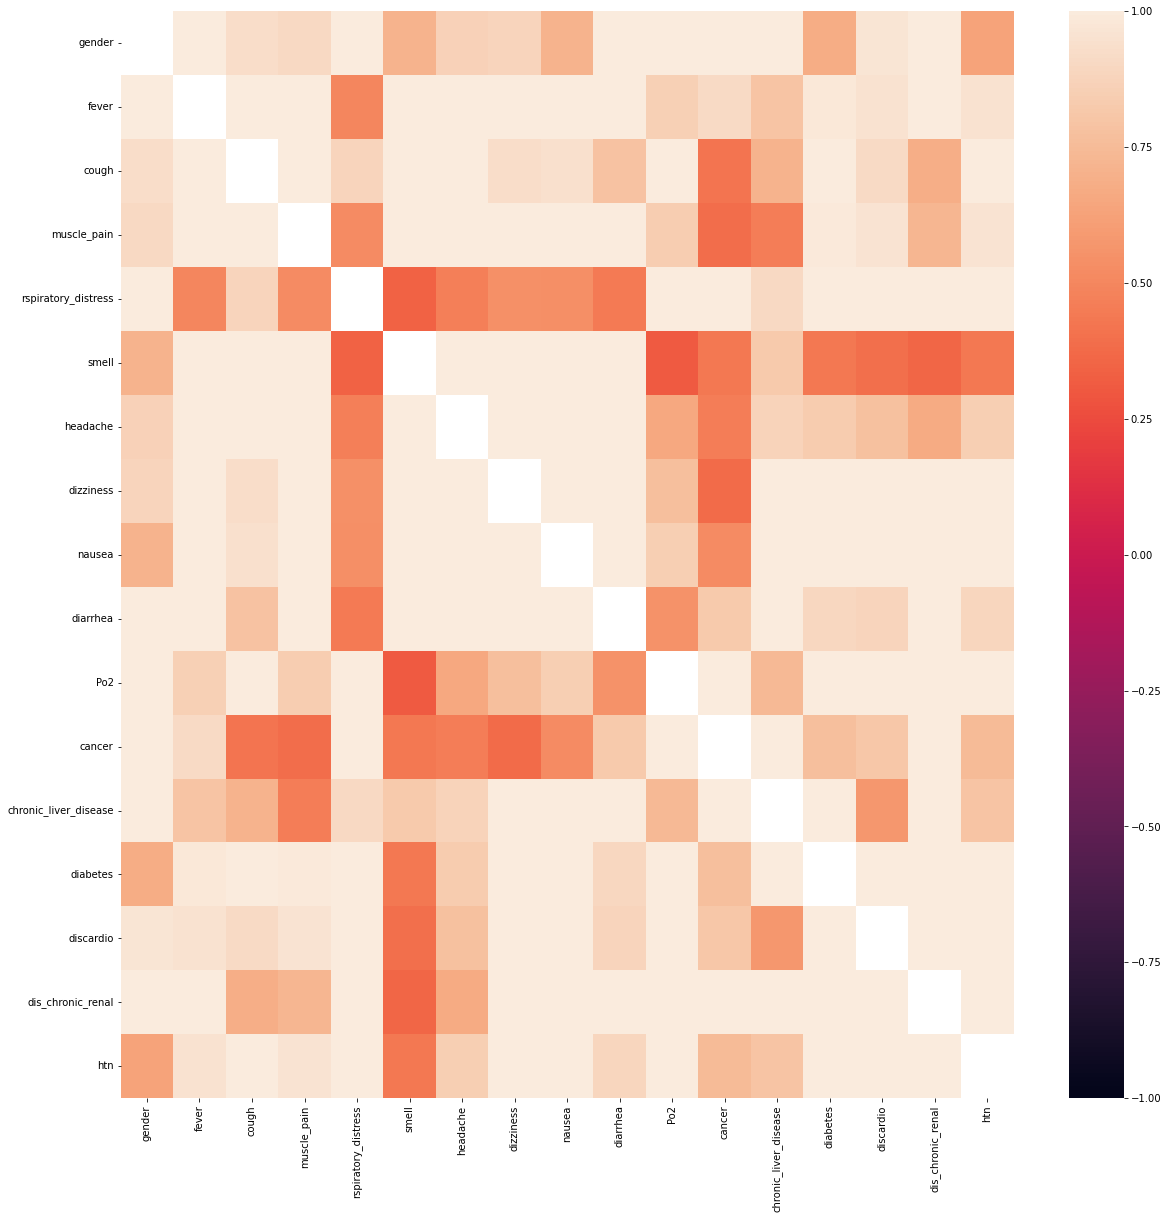

In [82]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_odds,ax=ax,vmin=-1,vmax=1)
plt.show()

In [64]:
df_features=pd.DataFrame(array_features,
                         index=col,
                         columns=col)

In [65]:
df_features

,Age,O2 saturation under 93,Respiratory distress,Hypertension,Cardiac disease,Diabetes,Muscle pain,Cough,Headache,Fever,Renal disease,Cancer,Nausea,Loss of smell,Dizziness,Gender,Liver disease,Diarrhea
Age,4.249784,0.058633,0.013310,7.829741e-02,0.046241,3.532214e-02,0.000000e+00,0.007486,0.003601,2.987058e-03,3.887687e-03,0.001880,0.000000,5.843596e-03,0.000000e+00,0.001314,3.337387e-04,0.001043
O2 saturation under 93,0.058032,0.660760,0.047114,1.490741e-02,0.005360,6.147375e-03,6.994989e-04,0.000148,0.002125,7.367470e-04,5.527403e-05,0.000002,0.000247,2.921861e-03,2.842973e-04,0.000048,9.346209e-05,0.001419
Respiratory distress,0.012653,0.047114,0.691247,3.347841e-03,0.001313,1.370482e-03,1.215741e-02,0.000531,0.007865,1.278515e-02,3.471217e-06,0.000050,0.003444,2.255776e-03,1.561094e-03,0.000176,5.231119e-06,0.002392
Hypertension,0.078922,0.014907,0.003348,5.324988e-01,0.031752,4.409685e-02,1.144017e-05,0.000019,0.000149,6.156285e-05,3.625614e-03,0.000080,0.000159,7.555576e-04,1.802089e-07,0.005053,1.916950e-05,0.000078
Cardiac disease,0.045386,0.005360,0.001313,3.175156e-02,0.372584,1.323684e-02,2.453658e-06,0.000154,0.000287,7.661439e-06,1.470126e-03,0.000023,0.000075,6.265280e-04,4.218470e-06,0.000023,8.306074e-05,0.000022
Diabetes,0.035248,0.006147,0.001370,4.409685e-02,0.013237,4.316980e-01,1.455547e-07,0.000024,0.000192,1.888479e-05,3.415013e-03,0.000084,0.000062,5.173518e-04,1.896688e-05,0.002810,1.454634e-06,0.000071
Muscle pain,0.005734,0.000699,0.012157,1.144017e-05,0.000002,1.455547e-07,6.531795e-01,0.007062,0.009670,8.428855e-03,3.244253e-04,0.001423,0.001381,1.339804e-03,2.676051e-04,0.000329,2.586474e-04,0.000460
Cough,0.004890,0.000148,0.000531,1.920367e-05,0.000154,2.362527e-05,7.061875e-03,0.689118,0.000609,2.390788e-03,5.130173e-04,0.001525,0.000087,8.832812e-05,8.081933e-06,0.000099,1.328595e-04,0.000303
Headache,0.004648,0.002125,0.007865,1.489450e-04,0.000287,1.917158e-04,9.670311e-03,0.000609,0.381330,2.283369e-03,1.758573e-04,0.000544,0.006626,1.982009e-03,1.265419e-02,0.000424,2.732011e-05,0.000604
Fever,0.003119,0.000737,0.012785,6.156285e-05,0.000008,1.888479e-05,8.428855e-03,0.002391,0.002283,6.346085e-01,7.869178e-07,0.000021,0.001132,3.557821e-04,1.525442e-04,0.000441,1.013985e-05,0.001363


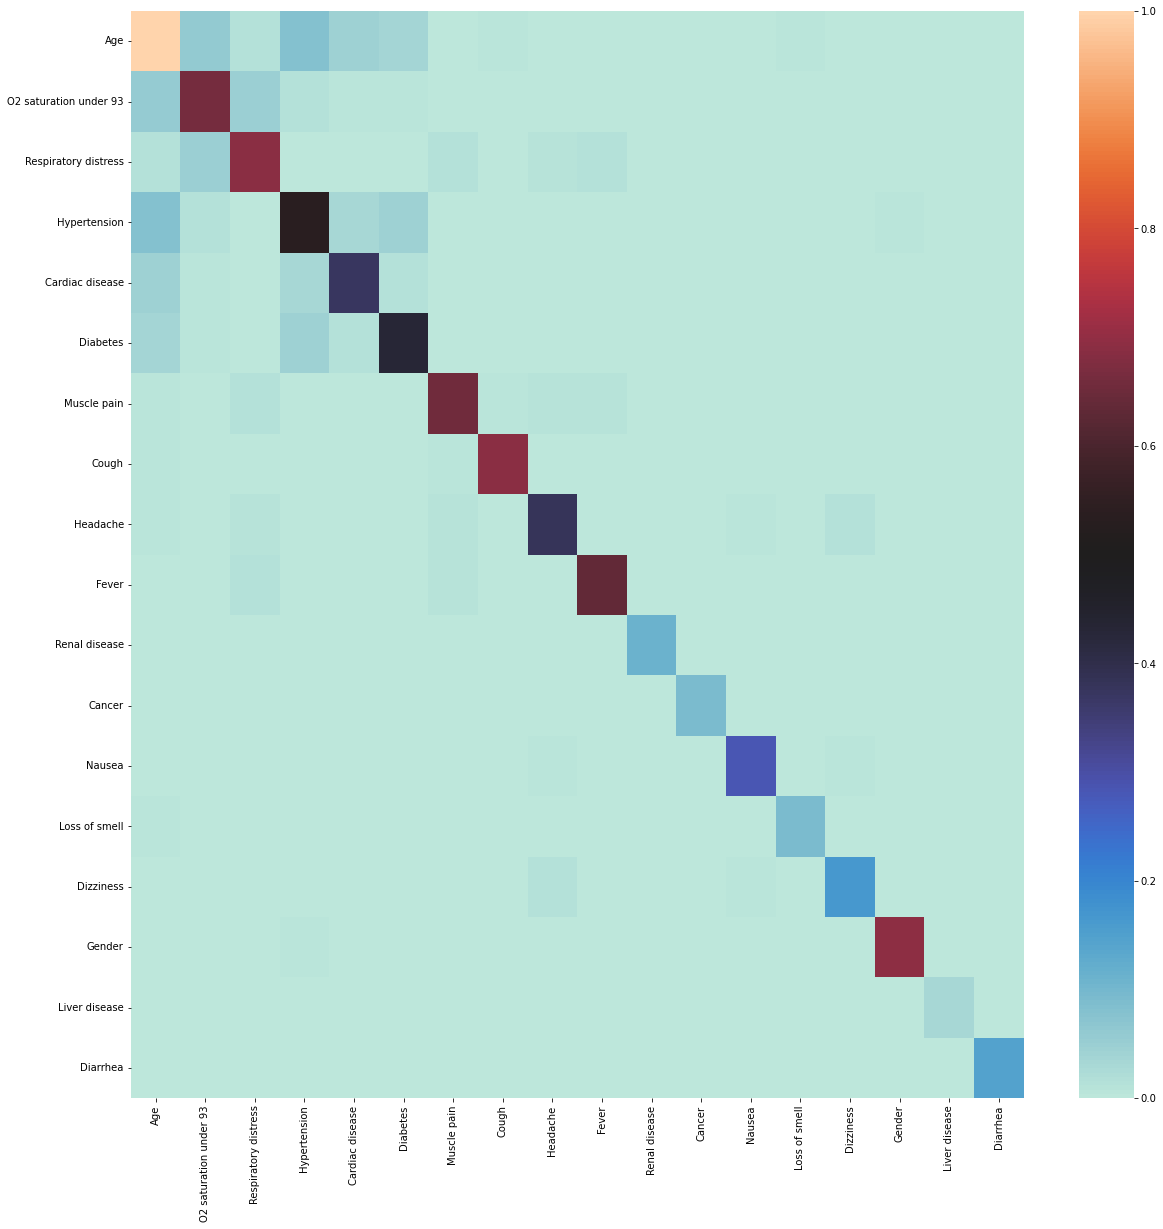

In [108]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_features,ax=ax,vmin=0.0,vmax=1.0,center=0.5)
plt.show()

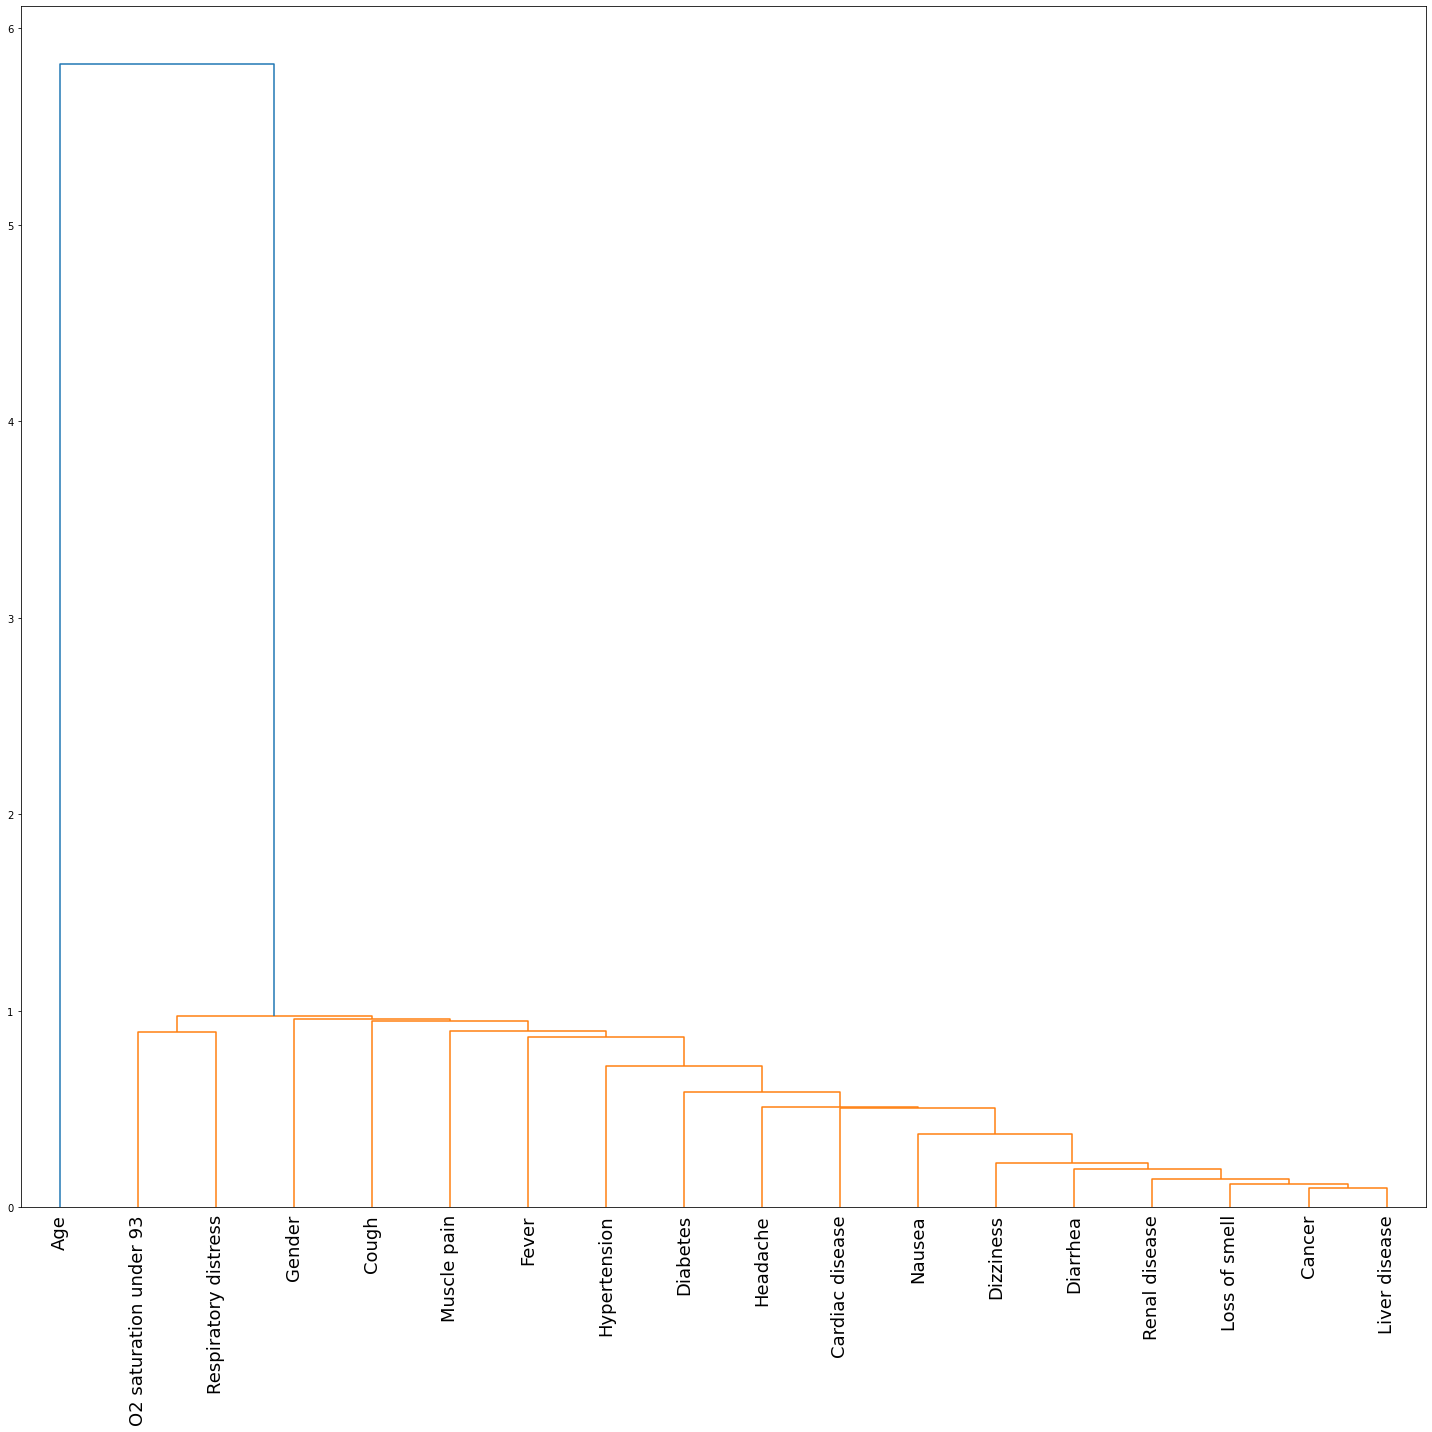

In [73]:

fig,ax1 = plt.subplots(figsize=(20, 20))


ax1.set_xticks(np.arange(0,array_features.shape[1]))

corr_linkage = hierarchy.ward(array_features)


dendro = hierarchy.dendrogram(
    corr_linkage, labels=df_features.columns.to_list(), ax=ax1, leaf_rotation=90)



ax1.set_xticklabels(dendro['ivl'],fontsize=18)

fig.tight_layout()

plt.show()

In [74]:
df_features.columns.array

<PandasArray>
[                   'Age', 'O2 saturation under 93',   'Respiratory distress',
           'Hypertension',        'Cardiac disease',               'Diabetes',
            'Muscle pain',                  'Cough',               'Headache',
                  'Fever',          'Renal disease',                 'Cancer',
                 'Nausea',          'Loss of smell',              'Dizziness',
                 'Gender',          'Liver disease',               'Diarrhea']
Length: 18, dtype: object

In [79]:
cluster_ids = hierarchy.fcluster(corr_linkage,0.9, criterion='distance')
cluster_ids

array([5, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2], dtype=int32)

In [80]:
feature_mi=mutual_info_classif(x_train_f,y_train, discrete_features=mask_discrete,random_state=42)

sorted_features=np.argsort(feature_mi)[::-1]

print(df_features.columns.array[sorted_features],'\n',feature_mi[sorted_features])

<PandasArray>
[                   'Age', 'O2 saturation under 93',   'Respiratory distress',
           'Hypertension',        'Cardiac disease',               'Diabetes',
            'Muscle pain',                  'Cough',               'Headache',
                  'Fever',          'Renal disease',                 'Cancer',
                 'Nausea',          'Loss of smell',              'Dizziness',
                 'Gender',          'Liver disease',               'Diarrhea']
Length: 18, dtype: object 
 [0.03580337 0.02167167 0.01159172 0.00779894 0.0052752  0.00401607
 0.00308949 0.0029198  0.00285786 0.00173517 0.00123591 0.00108461
 0.00079674 0.00063919 0.00055235 0.00055074 0.00051787 0.00050113]


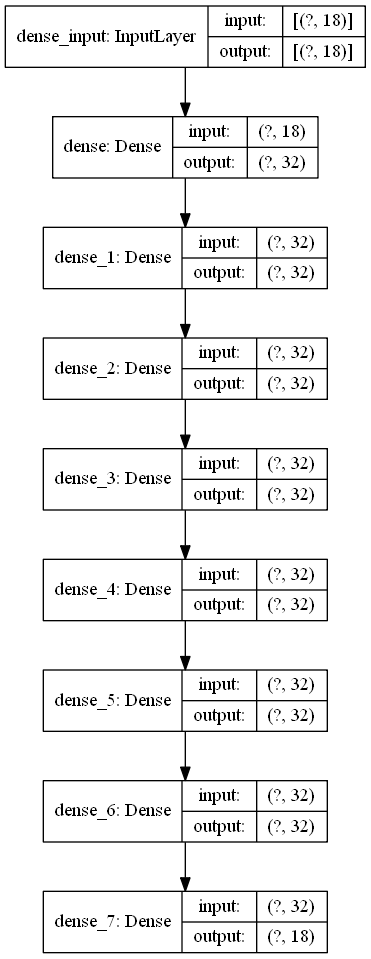

In [81]:
#Autoencoder for outlier detection with all features(35) and for dimensionality reduction (26)

def create_model():
    model=tf.keras.Sequential([layers.Dense(32,activation='relu',input_shape=(18,)),

                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(18,activation='sigmoid')])
    model.compile('adam',loss='mean_squared_logarithmic_error',metrics=['mse'])
    return model
model=create_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                608       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [83]:
def x_generator(x,batch_size,shuffle=True):
    batch_index=0
    n=x.shape[0]
    while True:
        if batch_index==0:
            index_array=np.arange(n)
            if shuffle:
                index_array = np.random.permutation(n)
        current_index=(batch_index*batch_size)%n
        
        if n>=current_index+batch_size:
            current_batch_size=batch_size
            
        else:
            current_batch_size=n-current_index
            batch_index=0
            
        batch_x=x[index_array[current_index:current_index+current_batch_size]]
        
        yield batch_x
        
        

def mixed_generator(x,batch_size,swaprate=0.2,shuffle=True):
    num_value=x.shape[1]
    num_swap=int(num_value*swaprate)
    
    gen1=x_generator(x,batch_size,shuffle)
    gen2=x_generator(x,batch_size,shuffle)
    
    while True:
        batch1=next(gen1)
        batch2=next(gen2)
        new_batch=batch1.copy()
        
        for i in range(batch1.shape[0]):
            swap_idx=np.random.choice(num_value,num_swap,replace=False)
            
            new_batch[i,swap_idx]=batch2[i,swap_idx]
            
        yield(new_batch,batch1)

In [84]:
callback=EarlyStopping(monitor='val_loss',patience=17,restore_best_weights=True)

a=[]

for train_index, test_index in skf.split(x_train_f, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_f[train_index], x_train_f[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    x_train_auto=column_transfromer_f.fit_transform(X_train_f)
    x_test_auto=column_transfromer_f.transform(X_test_f)
    
    gen_train=mixed_generator(x_train_auto,batch_size=128)
    
    model= create_model()
    
    history=model.fit(gen_train,epochs=500,steps_per_epoch=np.ceil(x_train_f.shape[0]/128),
                  validation_data=(x_test_auto,x_test_auto),callbacks=[callback])
    
    x_pred=model.predict(x_test_auto)
    errors=tf.keras.losses.msle(x_pred,x_test_auto)
    
    mean_loss=np.mean(errors.numpy())
    
    a.append(mean_loss)

print(a)

TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Epoch 1/500
173/173 [==============================] - 1s 5ms/step - loss: 0.0689 - mse: 0.1341 - val_loss: 0.0411 - val_mse: 0.0866
Epoch 2/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0366 - mse: 0.0775 - val_loss: 0.0229 - val_mse: 0.0488
Epoch 3/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0300 - mse: 0.0635 - val_loss: 0.0181 - val_mse: 0.0386
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0273 - mse: 0.0577 - val_loss: 0.0143 - val_mse: 0.0303
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0105 - val_mse: 0.0231 loss: 0.0248 - mse: 0.05 - ETA: 0s - loss: 0.0247 - mse: 0.051
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0235 - mse: 0.0494 - val_loss: 0.0097 - val_mse: 0.0215
Epoch 7/500
173/173 [=====================

173/173 [==============================] - 1s 4ms/step - loss: 0.0183 - mse: 0.0383 - val_loss: 0.0031 - val_mse: 0.0070
Epoch 62/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0387 - val_loss: 0.0030 - val_mse: 0.0069
Epoch 63/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0386 - val_loss: 0.0033 - val_mse: 0.0077
Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0032 - val_mse: 0.0073
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0033 - val_mse: 0.0078
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0032 - val_mse: 0.0074
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0038 - val_mse: 0.0086
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 122/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0382 - val_loss: 0.0031 - val_mse: 0.0077
Epoch 123/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0030 - val_mse: 0.0065
Epoch 124/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0386 - val_loss: 0.0032 - val_mse: 0.0081
Epoch 125/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0385 - val_loss: 0.0033 - val_mse: 0.0083
Epoch 126/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0387 - val_loss: 0.0032 - val_mse: 0.0075
Epoch 127/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0389 - val_loss: 0.0033 - val_mse: 0.0076
Epoch 128/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0387 - val_loss: 0.0031 - val_mse: 0.0075
Epoch 129/500
173/173 [==============================] 

173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0101 - val_mse: 0.0230
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0231 - mse: 0.0486 - val_loss: 0.0091 - val_mse: 0.0205TA: 0s - loss: 0.0230 - ms
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0232 - mse: 0.0487 - val_loss: 0.0088 - val_mse: 0.0191
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0227 - mse: 0.0476 - val_loss: 0.0084 - val_mse: 0.0177
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0227 - mse: 0.0478 - val_loss: 0.0092 - val_mse: 0.0221
Epoch 10/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0224 - mse: 0.0471 - val_loss: 0.0079 - val_mse: 0.0175
Epoch 11/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0221 - mse: 0.0465 - val_loss: 0.0076 - val_mse: 0.0170
Epoch 12/500
173/173 [==============================]

Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0395 - val_loss: 0.0035 - val_mse: 0.0079
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0395 - val_loss: 0.0036 - val_mse: 0.0083
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0035 - val_mse: 0.0080
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0395 - val_loss: 0.0033 - val_mse: 0.0076
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0190 - mse: 0.0400 - val_loss: 0.0036 - val_mse: 0.0086
Epoch 71/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0394 - val_loss: 0.0036 - val_mse: 0.0088
Epoch 72/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0394 - val_loss: 0.0033 - val_mse: 0.0073
Epoch 73/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0387 - val_loss: 0.0026 - val_mse: 0.0062
Epoch 47/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0383 - val_loss: 0.0026 - val_mse: 0.0069
Epoch 48/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0183 - mse: 0.0385 - val_loss: 0.0026 - val_mse: 0.0064
Epoch 49/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0379 - val_loss: 0.0026 - val_mse: 0.0071
Epoch 50/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0382 - val_loss: 0.0026 - val_mse: 0.0062
Epoch 51/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0382 - val_loss: 0.0025 - val_mse: 0.0058
Epoch 52/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0382 - val_loss: 0.0026 - val_mse: 0.0069
Epoch 53/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 41/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0389 - val_loss: 0.0031 - val_mse: 0.0071
Epoch 42/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0038 - val_mse: 0.0096
Epoch 43/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0189 - mse: 0.0397 - val_loss: 0.0034 - val_mse: 0.0085
Epoch 44/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0184 - mse: 0.0387 - val_loss: 0.0031 - val_mse: 0.0076
Epoch 45/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0391 - val_loss: 0.0031 - val_mse: 0.0079
Epoch 46/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0187 - mse: 0.0392 - val_loss: 0.0034 - val_mse: 0.0082
Epoch 47/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0032 - val_mse: 0.0075
Epoch 48/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0389 - val_loss: 0.0030 - val_mse: 0.0067
Epoch 53/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0030 - val_mse: 0.0071
Epoch 54/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0387 - val_loss: 0.0031 - val_mse: 0.0075
Epoch 55/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0030 - val_mse: 0.0069
Epoch 56/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0391 - val_loss: 0.0033 - val_mse: 0.0077
Epoch 57/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0391 - val_loss: 0.0035 - val_mse: 0.0076
Epoch 58/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0390 - val_loss: 0.0030 - val_mse: 0.0070
Epoch 59/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 12/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0209 - mse: 0.0439 - val_loss: 0.0062 - val_mse: 0.0142
Epoch 13/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0209 - mse: 0.0440 - val_loss: 0.0058 - val_mse: 0.0127
Epoch 14/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0207 - mse: 0.0434 - val_loss: 0.0058 - val_mse: 0.0131
Epoch 15/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0205 - mse: 0.0431 - val_loss: 0.0060 - val_mse: 0.0130
Epoch 16/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0209 - mse: 0.0438 - val_loss: 0.0057 - val_mse: 0.0130
Epoch 17/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0205 - mse: 0.0430 - val_loss: 0.0056 - val_mse: 0.0127
Epoch 18/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0204 - mse: 0.0429 - val_loss: 0.0059 - val_mse: 0.0127
Epoch 19/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0194 - mse: 0.0406 - val_loss: 0.0038 - val_mse: 0.0086
Epoch 34/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0193 - mse: 0.0406 - val_loss: 0.0041 - val_mse: 0.0098
Epoch 35/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0192 - mse: 0.0402 - val_loss: 0.0041 - val_mse: 0.0091
Epoch 36/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0192 - mse: 0.0404 - val_loss: 0.0038 - val_mse: 0.0093
Epoch 37/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0189 - mse: 0.0398 - val_loss: 0.0037 - val_mse: 0.0092
Epoch 38/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0192 - mse: 0.0402 - val_loss: 0.0035 - val_mse: 0.0082
Epoch 39/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0188 - mse: 0.0395 - val_loss: 0.0037 - val_mse: 0.0087
Epoch 40/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0391 - val_loss: 0.0037 - val_mse: 0.0088
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0187 - mse: 0.0392 - val_loss: 0.0036 - val_mse: 0.0086
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0186 - mse: 0.0391 - val_loss: 0.0032 - val_mse: 0.0078
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0389 - val_loss: 0.0031 - val_mse: 0.0070
Epoch 71/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0035 - val_mse: 0.0086
Epoch 72/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0187 - mse: 0.0393 - val_loss: 0.0033 - val_mse: 0.0084
Epoch 73/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0185 - mse: 0.0388 - val_loss: 0.0034 - val_mse: 0.0084
Epoch 74/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 128/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0379 - val_loss: 0.0027 - val_mse: 0.0069
Epoch 129/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0381 - val_loss: 0.0025 - val_mse: 0.0056
Epoch 130/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0178 - mse: 0.0374 - val_loss: 0.0025 - val_mse: 0.0062
Epoch 131/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0178 - mse: 0.0374 - val_loss: 0.0024 - val_mse: 0.0052
Epoch 132/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0179 - mse: 0.0376 - val_loss: 0.0024 - val_mse: 0.0058
Epoch 133/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0380 - val_loss: 0.0026 - val_mse: 0.0060
TRAIN: [    0     1     2 ... 22014 22015 22016] TEST: [    9    20    22 ... 21993 21994 21997]
Epoch 1/500
173/173 [==============================] - 1s 5ms/step - loss: 0.0713 - mse: 0.14

Epoch 114/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0381 - val_loss: 0.0026 - val_mse: 0.0067
Epoch 115/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0380 - val_loss: 0.0028 - val_mse: 0.0069
Epoch 116/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0381 - val_loss: 0.0027 - val_mse: 0.0070
Epoch 117/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0183 - mse: 0.0385 - val_loss: 0.0028 - val_mse: 0.0073
Epoch 118/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0380 - val_loss: 0.0029 - val_mse: 0.0077
Epoch 119/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0180 - mse: 0.0378 - val_loss: 0.0028 - val_mse: 0.0067
Epoch 120/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0181 - mse: 0.0380 - val_loss: 0.0028 - val_mse: 0.0074
Epoch 121/500
173/173 [==============================] 

In [85]:
loss_array=np.array(a)
mean_epochs_loss=np.mean(loss_array)
std_epochs=np.std(loss_array)
print(mean_epochs_loss,std_epochs)

0.002296279517703347 0.0002386456118539203


In [86]:
model.save('auto_encoder.h5')

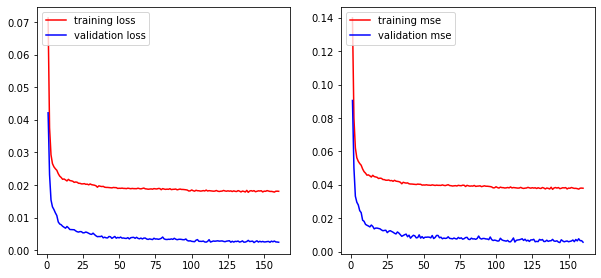

In [87]:
train_loss=history.history['loss']
epochs=np.arange(1,len(train_loss)+1)
val_loss=history.history['val_loss']

train_mse=history.history['mse']
val_mse=history.history['val_mse']

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(epochs,train_loss,'r',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.plot(epochs,train_mse,'r',label='training mse')
plt.plot(epochs,val_mse,'b',label='validation mse')
plt.legend(loc='upper left')
plt.show()

In [23]:
model=load_model('auto_encoder.h5')

In [24]:
x_train_x=column_transfromer_f.fit_transform(x_train_f)
x_test_x=column_transfromer_f.transform(x_test_f)

In [90]:
with open('column_preprocessing.sav','wb') as f:
    pickle.dump(column_transfromer_f,f)

#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [25]:
class denoising:
    
    def __init__(self,model):
        self.model=model
        
    def fit(self,X,y=None):
        return self


 
    def transform(self,X,y=None):
        predicts=self.model.predict(X)
        X=predicts
        return X

In [26]:
x_train_auto=denoising(model).transform(x_train_x)
x_test_auto=denoising(model).transform(x_test_x)

In [27]:
clf=RandomForestClassifier()

In [28]:
#feature analysis



n_estimators=np.arange(100,3000)
criterion=['gini','entropy']
max_depth=np.arange(100,2000)
min_samples_split=np.linspace(0.001,1,100)
min_samples_leaf=np.linspace(0.001,0.5,100)
max_features=['auto','sqrt','log2']
bootstrap=[True,False]
class_weight=['balanced','balanced_subsample',None]
 
forest_param=[{
            'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'max_features':max_features,
              'bootstrap':bootstrap,
              'class_weight':class_weight}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [29]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=140, n_jobs=9,
                   param_distributions=[{'bootstrap': [True, False],
                                         'class_weight': ['balanced',
                                                          'balanced_subsample',
                                                          None],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': array([ 100,  101,  102, ..., 1997, 1998, 1999]),
                                         'max_features': ['auto', 'sqrt',
                                                          '...
       0.75781818, 0.76790909, 0.778     , 0.78809091, 0.79818182,
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                                         'n_estimators': array([ 100,  101,  102, ..., 2997, 2998, 2999])}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [30]:
randomized.best_params_

{'n_estimators': 2829,
 'min_samples_split': 0.05145454545454546,
 'min_samples_leaf': 0.036282828282828285,
 'max_features': 'sqrt',
 'max_depth': 1832,
 'criterion': 'gini',
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [31]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [32]:
df_randomised_result.to_csv('param.csv')

In [33]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        13.666105      3.453788         0.309715        0.064554   
1        24.506934      4.158138         0.392922        0.071602   
2        12.322315      2.405903         0.151641        0.028984   
3         5.253941      1.096173         0.293228        0.058707   
4        24.752354      4.716545         0.344071        0.061678   
..             ...           ...              ...             ...   
135       0.948443      0.169218         0.054848        0.007936   
136       6.717761      1.033271         0.119462        0.020234   
137      20.824970      5.151373         0.482022        0.081350   
138       3.022592      0.462847         0.171324        0.028643   
139       6.770684      0.983120         0.093511        0.012243   

    param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 1859                0.656909               0.202616   
1                 2122   

In [75]:
clf=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.036,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)


In [76]:
clf.fit(x_train_auto,y_train)
pred=clf.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3339 1633]
 [ 116  417]] 0.7269623588153697 0.20341463414634145 0.7823639774859287


In [36]:
clf=LogisticRegression(penalty='elasticnet',C=1,solver='lbfgs',class_weight='balanced',l1_ratio=0.6,max_iter=500)

In [37]:
penalty=['elasticnet']
C=np.linspace(0.1,10,100)
solver=['saga']
l1_ratio=np.linspace(0.1,1,100)
max_iter=[700,800,900]

forest_param=[{
            'penalty':penalty,
            'C':C,
              'solver':solver,
               'l1_ratio':l1_ratio,
                'max_iter':max_iter}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=-1,random_state=42,verbose=4)

In [38]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LogisticRegression(C=1, class_weight='balanced',
                                                l1_ratio=0.6, max_iter=500,
                                                penalty='elasticnet'),
                   n_iter=140, n_jobs=-1,
                   param_distributions=[{'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2...
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
                                         'max_iter': [700, 800, 900],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [39]:
randomized.best_params_

{'solver': 'saga',
 'penalty': 'elasticnet',
 'max_iter': 800,
 'l1_ratio': 0.3909090909090909,
 'C': 1.5000000000000002}

In [74]:
clf=LogisticRegression(penalty='elasticnet',C=1.5,solver='saga',class_weight='balanced',l1_ratio=0.39,max_iter=800)
clf.fit(x_train_auto,y_train)

pred=clf.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3391 1581]
 [ 119  414]] 0.729377383893896 0.2075187969924812 0.776735459662289


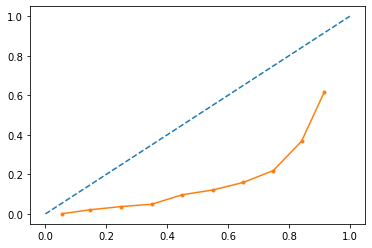

In [28]:
probs=clf.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=False)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [42]:
svc=svm.SVC(C=5,kernel='rbf',degree=3,gamma=0.1,coef0=2,shrinking=True,class_weight='balanced')

In [43]:
C=np.linspace(0.01,10,20)
kernel=['rbf','linear']
gamma=np.linspace(0,0.5,20)
coef0=np.linspace(0,7,20)

forest_param=[{
            'C':C,
              'kernel':kernel,
               'gamma':gamma,
                 'coef0':coef0}]

randomized=RandomizedSearchCV(estimator=svc,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=4)

In [44]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVC(C=5, class_weight='balanced', coef0=2,
                                 gamma=0.1),
                   n_iter=140, n_jobs=9,
                   param_distributions=[{'C': array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.371052...
       5.52631579, 5.89473684, 6.26315789, 6.63157895, 7.        ]),
                                         'gamma': array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ]),
                                         'kernel': ['rbf', 'linear']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [45]:
randomized.best_params_

{'kernel': 'linear',
 'gamma': 0.4473684210526315,
 'coef0': 1.8421052631578947,
 'C': 8.42263157894737}

In [46]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [47]:
df_randomised_result.to_csv('param_svm.csv')

In [48]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        30.786496      4.229409         2.090471        0.533356   
1        24.586046      4.532365         1.039365        0.332480   
2        30.829690      5.366487         2.433458        0.558786   
3        28.385225      4.551249         2.277462        0.507772   
4        28.644754      5.248314         2.347874        0.555286   
..             ...           ...              ...             ...   
135      28.611982      5.075462         2.525443        0.537370   
136      31.117456      5.789899         2.463587        0.602893   
137      21.979927      5.742426         1.047150        0.321764   
138      25.551088      6.021521         3.527109        0.899976   
139      17.218561      3.128893         0.647447        0.066877   

    param_kernel param_gamma param_coef0   param_C  \
0            rbf    0.394737    0.368421  4.742105   
1         linear    0.447368    5.157895      10.0   
2        

In [77]:
svc=svm.SVC(C=8.42,kernel='linear',degree=3,gamma=0.45,coef0=1.84,shrinking=True,class_weight='balanced')

In [78]:


svc.fit(x_train_auto,y_train)

pred=svc.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3303 1669]
 [ 107  426]] 0.7317848620190515 0.20334128878281624 0.799249530956848


In [31]:


auc_lgbm=[]
recall_lgbm=[]
precision_lgbm=[]
balanced_accu_lgbm=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    clf_lgbm=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=11000,max_depth=1000,learning_rate=0.001,
                       
                       n_estimators=7000,subsample_for_bin=5000,min_split_gain=0.01,min_child_samples=700,
                       colsample_bytree=0.9,
                       reg_alpha=0.01,reg_lambda=0.01,
                       
                       objective='binary',subsample=0.9,
                       
                       subsample_freq=100,class_weight='balanced',
                       random_state=42)
    
    

    clf_lgbm.fit(X_train_f,Y_train,eval_set=(X_test_f,Y_test),eval_names=['validation'],
        eval_metric=['logloss'],early_stopping_rounds=20,categorical_feature='auto')
    
    preds_proba=clf_lgbm.predict_proba(X_test_f)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_lgbm.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_lgbm.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_lgbm.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_lgbm.append(score)
    
balanced_accu_array=np.array(balanced_accu_lgbm)
auc_array=np.array(auc_lgbm)
precision_array=np.array(precision_lgbm)
recall_array=np.array(recall_lgbm)

print(f'balanced_accuracy:{np.mean(balanced_accu_array)}\nAUC:{np.mean(auc_array)}\nPrecision:{np.mean(precision_array)}\nRecall:{np.mean(recall_array)}')






TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
[1]	validation's binary_logloss: 0.692853
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692557
[3]	validation's binary_logloss: 0.692262
[4]	validation's binary_logloss: 0.691967
[5]	validation's binary_logloss: 0.691672
[6]	validation's binary_logloss: 0.691379
[7]	validation's binary_logloss: 0.691097
[8]	validation's binary_logloss: 0.690819
[9]	validation's binary_logloss: 0.690526
[10]	validation's binary_logloss: 0.690233
[11]	validation's binary_logloss: 0.689941
[12]	validation's binary_logloss: 0.68965
[13]	validation's binary_logloss: 0.689373
[14]	validation's binary_logloss: 0.689097
[15]	validation's binary_logloss: 0.68882
[16]	validation's binary_logloss: 0.688532
[17]	validation's binary_logloss: 0.688244
[18]	validation's binary_logloss: 0.687969
[19]	validation's binary_logloss: 0.687682
[20]	validation's binary_logloss: 0.

[262]	validation's binary_logloss: 0.632731
[263]	validation's binary_logloss: 0.632557
[264]	validation's binary_logloss: 0.632377
[265]	validation's binary_logloss: 0.632198
[266]	validation's binary_logloss: 0.632018
[267]	validation's binary_logloss: 0.631839
[268]	validation's binary_logloss: 0.631659
[269]	validation's binary_logloss: 0.63148
[270]	validation's binary_logloss: 0.631302
[271]	validation's binary_logloss: 0.631122
[272]	validation's binary_logloss: 0.630945
[273]	validation's binary_logloss: 0.630766
[274]	validation's binary_logloss: 0.630592
[275]	validation's binary_logloss: 0.630411
[276]	validation's binary_logloss: 0.630236
[277]	validation's binary_logloss: 0.630058
[278]	validation's binary_logloss: 0.629886
[279]	validation's binary_logloss: 0.629716
[280]	validation's binary_logloss: 0.62954
[281]	validation's binary_logloss: 0.629364
[282]	validation's binary_logloss: 0.629196
[283]	validation's binary_logloss: 0.62902
[284]	validation's binary_logloss: 

[509]	validation's binary_logloss: 0.596839
[510]	validation's binary_logloss: 0.596719
[511]	validation's binary_logloss: 0.5966
[512]	validation's binary_logloss: 0.596484
[513]	validation's binary_logloss: 0.596369
[514]	validation's binary_logloss: 0.596253
[515]	validation's binary_logloss: 0.596135
[516]	validation's binary_logloss: 0.596022
[517]	validation's binary_logloss: 0.595906
[518]	validation's binary_logloss: 0.59579
[519]	validation's binary_logloss: 0.595673
[520]	validation's binary_logloss: 0.595557
[521]	validation's binary_logloss: 0.595442
[522]	validation's binary_logloss: 0.59533
[523]	validation's binary_logloss: 0.595216
[524]	validation's binary_logloss: 0.595104
[525]	validation's binary_logloss: 0.594992
[526]	validation's binary_logloss: 0.594877
[527]	validation's binary_logloss: 0.594763
[528]	validation's binary_logloss: 0.59465
[529]	validation's binary_logloss: 0.594551
[530]	validation's binary_logloss: 0.594437
[531]	validation's binary_logloss: 0.

[753]	validation's binary_logloss: 0.574092
[754]	validation's binary_logloss: 0.574015
[755]	validation's binary_logloss: 0.573942
[756]	validation's binary_logloss: 0.573866
[757]	validation's binary_logloss: 0.573788
[758]	validation's binary_logloss: 0.573716
[759]	validation's binary_logloss: 0.573639
[760]	validation's binary_logloss: 0.573567
[761]	validation's binary_logloss: 0.573494
[762]	validation's binary_logloss: 0.573421
[763]	validation's binary_logloss: 0.573349
[764]	validation's binary_logloss: 0.573272
[765]	validation's binary_logloss: 0.573197
[766]	validation's binary_logloss: 0.573126
[767]	validation's binary_logloss: 0.573053
[768]	validation's binary_logloss: 0.572981
[769]	validation's binary_logloss: 0.572908
[770]	validation's binary_logloss: 0.572831
[771]	validation's binary_logloss: 0.572759
[772]	validation's binary_logloss: 0.572688
[773]	validation's binary_logloss: 0.572614
[774]	validation's binary_logloss: 0.572546
[775]	validation's binary_loglos

[1008]	validation's binary_logloss: 0.556487
[1009]	validation's binary_logloss: 0.556428
[1010]	validation's binary_logloss: 0.556371
[1011]	validation's binary_logloss: 0.556314
[1012]	validation's binary_logloss: 0.556255
[1013]	validation's binary_logloss: 0.5562
[1014]	validation's binary_logloss: 0.556142
[1015]	validation's binary_logloss: 0.556084
[1016]	validation's binary_logloss: 0.556028
[1017]	validation's binary_logloss: 0.555972
[1018]	validation's binary_logloss: 0.555913
[1019]	validation's binary_logloss: 0.555854
[1020]	validation's binary_logloss: 0.555796
[1021]	validation's binary_logloss: 0.555741
[1022]	validation's binary_logloss: 0.555683
[1023]	validation's binary_logloss: 0.555623
[1024]	validation's binary_logloss: 0.555565
[1025]	validation's binary_logloss: 0.555505
[1026]	validation's binary_logloss: 0.555447
[1027]	validation's binary_logloss: 0.555392
[1028]	validation's binary_logloss: 0.555335
[1029]	validation's binary_logloss: 0.555277
[1030]	valid

[1260]	validation's binary_logloss: 0.54483
[1261]	validation's binary_logloss: 0.544796
[1262]	validation's binary_logloss: 0.544762
[1263]	validation's binary_logloss: 0.544727
[1264]	validation's binary_logloss: 0.544691
[1265]	validation's binary_logloss: 0.544652
[1266]	validation's binary_logloss: 0.544617
[1267]	validation's binary_logloss: 0.544582
[1268]	validation's binary_logloss: 0.544549
[1269]	validation's binary_logloss: 0.544515
[1270]	validation's binary_logloss: 0.544478
[1271]	validation's binary_logloss: 0.544444
[1272]	validation's binary_logloss: 0.544408
[1273]	validation's binary_logloss: 0.544374
[1274]	validation's binary_logloss: 0.544329
[1275]	validation's binary_logloss: 0.544296
[1276]	validation's binary_logloss: 0.544262
[1277]	validation's binary_logloss: 0.544223
[1278]	validation's binary_logloss: 0.544178
[1279]	validation's binary_logloss: 0.544144
[1280]	validation's binary_logloss: 0.544111
[1281]	validation's binary_logloss: 0.544078
[1282]	vali

[1493]	validation's binary_logloss: 0.537904
[1494]	validation's binary_logloss: 0.53788
[1495]	validation's binary_logloss: 0.537858
[1496]	validation's binary_logloss: 0.537835
[1497]	validation's binary_logloss: 0.53781
[1498]	validation's binary_logloss: 0.537787
[1499]	validation's binary_logloss: 0.537762
[1500]	validation's binary_logloss: 0.537739
[1501]	validation's binary_logloss: 0.537713
[1502]	validation's binary_logloss: 0.537688
[1503]	validation's binary_logloss: 0.537664
[1504]	validation's binary_logloss: 0.537636
[1505]	validation's binary_logloss: 0.537609
[1506]	validation's binary_logloss: 0.537583
[1507]	validation's binary_logloss: 0.537565
[1508]	validation's binary_logloss: 0.537538
[1509]	validation's binary_logloss: 0.53751
[1510]	validation's binary_logloss: 0.537483
[1511]	validation's binary_logloss: 0.537458
[1512]	validation's binary_logloss: 0.537432
[1513]	validation's binary_logloss: 0.537407
[1514]	validation's binary_logloss: 0.537381
[1515]	valida

[1733]	validation's binary_logloss: 0.532605
[1734]	validation's binary_logloss: 0.532581
[1735]	validation's binary_logloss: 0.532562
[1736]	validation's binary_logloss: 0.532537
[1737]	validation's binary_logloss: 0.532517
[1738]	validation's binary_logloss: 0.532496
[1739]	validation's binary_logloss: 0.532473
[1740]	validation's binary_logloss: 0.532451
[1741]	validation's binary_logloss: 0.53243
[1742]	validation's binary_logloss: 0.532411
[1743]	validation's binary_logloss: 0.532388
[1744]	validation's binary_logloss: 0.532364
[1745]	validation's binary_logloss: 0.532343
[1746]	validation's binary_logloss: 0.532319
[1747]	validation's binary_logloss: 0.532299
[1748]	validation's binary_logloss: 0.532278
[1749]	validation's binary_logloss: 0.532256
[1750]	validation's binary_logloss: 0.532231
[1751]	validation's binary_logloss: 0.532206
[1752]	validation's binary_logloss: 0.532187
[1753]	validation's binary_logloss: 0.532168
[1754]	validation's binary_logloss: 0.532145
[1755]	vali

[1966]	validation's binary_logloss: 0.528462
[1967]	validation's binary_logloss: 0.528446
[1968]	validation's binary_logloss: 0.528433
[1969]	validation's binary_logloss: 0.528417
[1970]	validation's binary_logloss: 0.528401
[1971]	validation's binary_logloss: 0.528387
[1972]	validation's binary_logloss: 0.528371
[1973]	validation's binary_logloss: 0.528355
[1974]	validation's binary_logloss: 0.52834
[1975]	validation's binary_logloss: 0.528324
[1976]	validation's binary_logloss: 0.52831
[1977]	validation's binary_logloss: 0.528292
[1978]	validation's binary_logloss: 0.528279
[1979]	validation's binary_logloss: 0.528265
[1980]	validation's binary_logloss: 0.52825
[1981]	validation's binary_logloss: 0.528233
[1982]	validation's binary_logloss: 0.528216
[1983]	validation's binary_logloss: 0.528202
[1984]	validation's binary_logloss: 0.528191
[1985]	validation's binary_logloss: 0.528176
[1986]	validation's binary_logloss: 0.528161
[1987]	validation's binary_logloss: 0.528147
[1988]	valida

[2223]	validation's binary_logloss: 0.525217
[2224]	validation's binary_logloss: 0.525208
[2225]	validation's binary_logloss: 0.525201
[2226]	validation's binary_logloss: 0.525193
[2227]	validation's binary_logloss: 0.525185
[2228]	validation's binary_logloss: 0.525176
[2229]	validation's binary_logloss: 0.525164
[2230]	validation's binary_logloss: 0.525158
[2231]	validation's binary_logloss: 0.525148
[2232]	validation's binary_logloss: 0.525139
[2233]	validation's binary_logloss: 0.525133
[2234]	validation's binary_logloss: 0.525126
[2235]	validation's binary_logloss: 0.525115
[2236]	validation's binary_logloss: 0.525108
[2237]	validation's binary_logloss: 0.525101
[2238]	validation's binary_logloss: 0.525089
[2239]	validation's binary_logloss: 0.525081
[2240]	validation's binary_logloss: 0.52507
[2241]	validation's binary_logloss: 0.525059
[2242]	validation's binary_logloss: 0.525054
[2243]	validation's binary_logloss: 0.525044
[2244]	validation's binary_logloss: 0.525038
[2245]	vali

[2467]	validation's binary_logloss: 0.522862
[2468]	validation's binary_logloss: 0.52286
[2469]	validation's binary_logloss: 0.522857
[2470]	validation's binary_logloss: 0.522852
[2471]	validation's binary_logloss: 0.522848
[2472]	validation's binary_logloss: 0.522845
[2473]	validation's binary_logloss: 0.522839
[2474]	validation's binary_logloss: 0.522835
[2475]	validation's binary_logloss: 0.522832
[2476]	validation's binary_logloss: 0.522825
[2477]	validation's binary_logloss: 0.522822
[2478]	validation's binary_logloss: 0.522815
[2479]	validation's binary_logloss: 0.52281
[2480]	validation's binary_logloss: 0.522806
[2481]	validation's binary_logloss: 0.522802
[2482]	validation's binary_logloss: 0.522796
[2483]	validation's binary_logloss: 0.522791
[2484]	validation's binary_logloss: 0.522788
[2485]	validation's binary_logloss: 0.522784
[2486]	validation's binary_logloss: 0.52278
[2487]	validation's binary_logloss: 0.522777
[2488]	validation's binary_logloss: 0.522771
[2489]	valida

[2708]	validation's binary_logloss: 0.521701
[2709]	validation's binary_logloss: 0.521695
[2710]	validation's binary_logloss: 0.521693
[2711]	validation's binary_logloss: 0.521688
[2712]	validation's binary_logloss: 0.521683
[2713]	validation's binary_logloss: 0.52168
[2714]	validation's binary_logloss: 0.521673
[2715]	validation's binary_logloss: 0.521667
[2716]	validation's binary_logloss: 0.521662
[2717]	validation's binary_logloss: 0.521659
[2718]	validation's binary_logloss: 0.521652
[2719]	validation's binary_logloss: 0.521649
[2720]	validation's binary_logloss: 0.521644
[2721]	validation's binary_logloss: 0.521642
[2722]	validation's binary_logloss: 0.521638
[2723]	validation's binary_logloss: 0.521636
[2724]	validation's binary_logloss: 0.521633
[2725]	validation's binary_logloss: 0.521631
[2726]	validation's binary_logloss: 0.521626
[2727]	validation's binary_logloss: 0.521622
[2728]	validation's binary_logloss: 0.521615
[2729]	validation's binary_logloss: 0.521613
[2730]	vali

[2960]	validation's binary_logloss: 0.520548
[2961]	validation's binary_logloss: 0.520545
[2962]	validation's binary_logloss: 0.520539
[2963]	validation's binary_logloss: 0.520534
[2964]	validation's binary_logloss: 0.520528
[2965]	validation's binary_logloss: 0.520522
[2966]	validation's binary_logloss: 0.520518
[2967]	validation's binary_logloss: 0.520513
[2968]	validation's binary_logloss: 0.52051
[2969]	validation's binary_logloss: 0.520505
[2970]	validation's binary_logloss: 0.520501
[2971]	validation's binary_logloss: 0.520499
[2972]	validation's binary_logloss: 0.520494
[2973]	validation's binary_logloss: 0.520489
[2974]	validation's binary_logloss: 0.520483
[2975]	validation's binary_logloss: 0.520478
[2976]	validation's binary_logloss: 0.520471
[2977]	validation's binary_logloss: 0.520466
[2978]	validation's binary_logloss: 0.520458
[2979]	validation's binary_logloss: 0.520452
[2980]	validation's binary_logloss: 0.520446
[2981]	validation's binary_logloss: 0.520439
[2982]	vali

[37]	validation's binary_logloss: 0.682987
[38]	validation's binary_logloss: 0.68272
[39]	validation's binary_logloss: 0.682466
[40]	validation's binary_logloss: 0.682201
[41]	validation's binary_logloss: 0.681934
[42]	validation's binary_logloss: 0.681672
[43]	validation's binary_logloss: 0.681423
[44]	validation's binary_logloss: 0.681158
[45]	validation's binary_logloss: 0.680896
[46]	validation's binary_logloss: 0.680651
[47]	validation's binary_logloss: 0.680384
[48]	validation's binary_logloss: 0.680122
[49]	validation's binary_logloss: 0.679859
[50]	validation's binary_logloss: 0.679616
[51]	validation's binary_logloss: 0.679362
[52]	validation's binary_logloss: 0.6791
[53]	validation's binary_logloss: 0.678838
[54]	validation's binary_logloss: 0.678576
[55]	validation's binary_logloss: 0.678318
[56]	validation's binary_logloss: 0.67806
[57]	validation's binary_logloss: 0.677807
[58]	validation's binary_logloss: 0.677548
[59]	validation's binary_logloss: 0.677297
[60]	validation

[286]	validation's binary_logloss: 0.632305
[287]	validation's binary_logloss: 0.632139
[288]	validation's binary_logloss: 0.631976
[289]	validation's binary_logloss: 0.631812
[290]	validation's binary_logloss: 0.631652
[291]	validation's binary_logloss: 0.631492
[292]	validation's binary_logloss: 0.631328
[293]	validation's binary_logloss: 0.631167
[294]	validation's binary_logloss: 0.631004
[295]	validation's binary_logloss: 0.630847
[296]	validation's binary_logloss: 0.630685
[297]	validation's binary_logloss: 0.630524
[298]	validation's binary_logloss: 0.630361
[299]	validation's binary_logloss: 0.630202
[300]	validation's binary_logloss: 0.630048
[301]	validation's binary_logloss: 0.629893
[302]	validation's binary_logloss: 0.629738
[303]	validation's binary_logloss: 0.629582
[304]	validation's binary_logloss: 0.62943
[305]	validation's binary_logloss: 0.629276
[306]	validation's binary_logloss: 0.629121
[307]	validation's binary_logloss: 0.628969
[308]	validation's binary_logloss

[547]	validation's binary_logloss: 0.599396
[548]	validation's binary_logloss: 0.599296
[549]	validation's binary_logloss: 0.599194
[550]	validation's binary_logloss: 0.599095
[551]	validation's binary_logloss: 0.59899
[552]	validation's binary_logloss: 0.598884
[553]	validation's binary_logloss: 0.598777
[554]	validation's binary_logloss: 0.598677
[555]	validation's binary_logloss: 0.598578
[556]	validation's binary_logloss: 0.598479
[557]	validation's binary_logloss: 0.59838
[558]	validation's binary_logloss: 0.598284
[559]	validation's binary_logloss: 0.598183
[560]	validation's binary_logloss: 0.598085
[561]	validation's binary_logloss: 0.597988
[562]	validation's binary_logloss: 0.597892
[563]	validation's binary_logloss: 0.597793
[564]	validation's binary_logloss: 0.597693
[565]	validation's binary_logloss: 0.597596
[566]	validation's binary_logloss: 0.597493
[567]	validation's binary_logloss: 0.597396
[568]	validation's binary_logloss: 0.597293
[569]	validation's binary_logloss:

[807]	validation's binary_logloss: 0.578237
[808]	validation's binary_logloss: 0.578166
[809]	validation's binary_logloss: 0.578096
[810]	validation's binary_logloss: 0.578024
[811]	validation's binary_logloss: 0.577954
[812]	validation's binary_logloss: 0.577883
[813]	validation's binary_logloss: 0.577812
[814]	validation's binary_logloss: 0.577745
[815]	validation's binary_logloss: 0.577675
[816]	validation's binary_logloss: 0.577604
[817]	validation's binary_logloss: 0.577535
[818]	validation's binary_logloss: 0.577468
[819]	validation's binary_logloss: 0.577398
[820]	validation's binary_logloss: 0.577328
[821]	validation's binary_logloss: 0.577258
[822]	validation's binary_logloss: 0.577188
[823]	validation's binary_logloss: 0.577118
[824]	validation's binary_logloss: 0.57705
[825]	validation's binary_logloss: 0.57698
[826]	validation's binary_logloss: 0.576912
[827]	validation's binary_logloss: 0.576843
[828]	validation's binary_logloss: 0.576775
[829]	validation's binary_logloss:

[1046]	validation's binary_logloss: 0.564145
[1047]	validation's binary_logloss: 0.564093
[1048]	validation's binary_logloss: 0.56404
[1049]	validation's binary_logloss: 0.563986
[1050]	validation's binary_logloss: 0.563934
[1051]	validation's binary_logloss: 0.563883
[1052]	validation's binary_logloss: 0.563831
[1053]	validation's binary_logloss: 0.563778
[1054]	validation's binary_logloss: 0.563727
[1055]	validation's binary_logloss: 0.563679
[1056]	validation's binary_logloss: 0.563621
[1057]	validation's binary_logloss: 0.563569
[1058]	validation's binary_logloss: 0.563521
[1059]	validation's binary_logloss: 0.563468
[1060]	validation's binary_logloss: 0.563418
[1061]	validation's binary_logloss: 0.563367
[1062]	validation's binary_logloss: 0.563316
[1063]	validation's binary_logloss: 0.563263
[1064]	validation's binary_logloss: 0.563209
[1065]	validation's binary_logloss: 0.563159
[1066]	validation's binary_logloss: 0.56311
[1067]	validation's binary_logloss: 0.563058
[1068]	valid

[1308]	validation's binary_logloss: 0.553833
[1309]	validation's binary_logloss: 0.553803
[1310]	validation's binary_logloss: 0.553775
[1311]	validation's binary_logloss: 0.553739
[1312]	validation's binary_logloss: 0.553705
[1313]	validation's binary_logloss: 0.553673
[1314]	validation's binary_logloss: 0.553639
[1315]	validation's binary_logloss: 0.553606
[1316]	validation's binary_logloss: 0.553572
[1317]	validation's binary_logloss: 0.55354
[1318]	validation's binary_logloss: 0.553509
[1319]	validation's binary_logloss: 0.553477
[1320]	validation's binary_logloss: 0.553447
[1321]	validation's binary_logloss: 0.553413
[1322]	validation's binary_logloss: 0.553379
[1323]	validation's binary_logloss: 0.553349
[1324]	validation's binary_logloss: 0.553315
[1325]	validation's binary_logloss: 0.553282
[1326]	validation's binary_logloss: 0.553251
[1327]	validation's binary_logloss: 0.553216
[1328]	validation's binary_logloss: 0.553186
[1329]	validation's binary_logloss: 0.553156
[1330]	vali

[1564]	validation's binary_logloss: 0.546789
[1565]	validation's binary_logloss: 0.546766
[1566]	validation's binary_logloss: 0.546744
[1567]	validation's binary_logloss: 0.546725
[1568]	validation's binary_logloss: 0.546708
[1569]	validation's binary_logloss: 0.546685
[1570]	validation's binary_logloss: 0.546669
[1571]	validation's binary_logloss: 0.546645
[1572]	validation's binary_logloss: 0.546624
[1573]	validation's binary_logloss: 0.546605
[1574]	validation's binary_logloss: 0.546587
[1575]	validation's binary_logloss: 0.546568
[1576]	validation's binary_logloss: 0.546546
[1577]	validation's binary_logloss: 0.546524
[1578]	validation's binary_logloss: 0.546506
[1579]	validation's binary_logloss: 0.546483
[1580]	validation's binary_logloss: 0.546466
[1581]	validation's binary_logloss: 0.546447
[1582]	validation's binary_logloss: 0.546429
[1583]	validation's binary_logloss: 0.546407
[1584]	validation's binary_logloss: 0.546388
[1585]	validation's binary_logloss: 0.546368
[1586]	val

[1816]	validation's binary_logloss: 0.541698
[1817]	validation's binary_logloss: 0.541687
[1818]	validation's binary_logloss: 0.541674
[1819]	validation's binary_logloss: 0.541667
[1820]	validation's binary_logloss: 0.541656
[1821]	validation's binary_logloss: 0.541649
[1822]	validation's binary_logloss: 0.541636
[1823]	validation's binary_logloss: 0.541629
[1824]	validation's binary_logloss: 0.541622
[1825]	validation's binary_logloss: 0.541604
[1826]	validation's binary_logloss: 0.541597
[1827]	validation's binary_logloss: 0.541583
[1828]	validation's binary_logloss: 0.541568
[1829]	validation's binary_logloss: 0.541556
[1830]	validation's binary_logloss: 0.541543
[1831]	validation's binary_logloss: 0.541529
[1832]	validation's binary_logloss: 0.541516
[1833]	validation's binary_logloss: 0.541505
[1834]	validation's binary_logloss: 0.541492
[1835]	validation's binary_logloss: 0.541477
[1836]	validation's binary_logloss: 0.54147
[1837]	validation's binary_logloss: 0.541457
[1838]	vali

[2078]	validation's binary_logloss: 0.538074
[2079]	validation's binary_logloss: 0.538064
[2080]	validation's binary_logloss: 0.538053
[2081]	validation's binary_logloss: 0.53804
[2082]	validation's binary_logloss: 0.538028
[2083]	validation's binary_logloss: 0.538018
[2084]	validation's binary_logloss: 0.538007
[2085]	validation's binary_logloss: 0.537995
[2086]	validation's binary_logloss: 0.537984
[2087]	validation's binary_logloss: 0.537974
[2088]	validation's binary_logloss: 0.537962
[2089]	validation's binary_logloss: 0.537954
[2090]	validation's binary_logloss: 0.537942
[2091]	validation's binary_logloss: 0.537932
[2092]	validation's binary_logloss: 0.537922
[2093]	validation's binary_logloss: 0.537911
[2094]	validation's binary_logloss: 0.5379
[2095]	validation's binary_logloss: 0.537888
[2096]	validation's binary_logloss: 0.537878
[2097]	validation's binary_logloss: 0.537867
[2098]	validation's binary_logloss: 0.537855
[2099]	validation's binary_logloss: 0.537845
[2100]	valida

[2328]	validation's binary_logloss: 0.534652
[2329]	validation's binary_logloss: 0.534635
[2330]	validation's binary_logloss: 0.534622
[2331]	validation's binary_logloss: 0.534612
[2332]	validation's binary_logloss: 0.534599
[2333]	validation's binary_logloss: 0.534584
[2334]	validation's binary_logloss: 0.534572
[2335]	validation's binary_logloss: 0.53456
[2336]	validation's binary_logloss: 0.534544
[2337]	validation's binary_logloss: 0.53453
[2338]	validation's binary_logloss: 0.53452
[2339]	validation's binary_logloss: 0.534505
[2340]	validation's binary_logloss: 0.534489
[2341]	validation's binary_logloss: 0.534479
[2342]	validation's binary_logloss: 0.534468
[2343]	validation's binary_logloss: 0.534455
[2344]	validation's binary_logloss: 0.534443
[2345]	validation's binary_logloss: 0.534427
[2346]	validation's binary_logloss: 0.534413
[2347]	validation's binary_logloss: 0.5344
[2348]	validation's binary_logloss: 0.534388
[2349]	validation's binary_logloss: 0.534376
[2350]	validati

[2592]	validation's binary_logloss: 0.531723
[2593]	validation's binary_logloss: 0.531711
[2594]	validation's binary_logloss: 0.531698
[2595]	validation's binary_logloss: 0.531688
[2596]	validation's binary_logloss: 0.531671
[2597]	validation's binary_logloss: 0.531659
[2598]	validation's binary_logloss: 0.531648
[2599]	validation's binary_logloss: 0.531636
[2600]	validation's binary_logloss: 0.531621
[2601]	validation's binary_logloss: 0.531614
[2602]	validation's binary_logloss: 0.531609
[2603]	validation's binary_logloss: 0.531602
[2604]	validation's binary_logloss: 0.531595
[2605]	validation's binary_logloss: 0.531588
[2606]	validation's binary_logloss: 0.531581
[2607]	validation's binary_logloss: 0.531574
[2608]	validation's binary_logloss: 0.531567
[2609]	validation's binary_logloss: 0.531561
[2610]	validation's binary_logloss: 0.531553
[2611]	validation's binary_logloss: 0.531545
[2612]	validation's binary_logloss: 0.531539
[2613]	validation's binary_logloss: 0.531531
[2614]	val

[2849]	validation's binary_logloss: 0.530288
[2850]	validation's binary_logloss: 0.530278
[2851]	validation's binary_logloss: 0.53027
[2852]	validation's binary_logloss: 0.530262
[2853]	validation's binary_logloss: 0.530254
[2854]	validation's binary_logloss: 0.530249
[2855]	validation's binary_logloss: 0.530239
[2856]	validation's binary_logloss: 0.530231
[2857]	validation's binary_logloss: 0.530225
[2858]	validation's binary_logloss: 0.530218
[2859]	validation's binary_logloss: 0.530212
[2860]	validation's binary_logloss: 0.530206
[2861]	validation's binary_logloss: 0.530197
[2862]	validation's binary_logloss: 0.530192
[2863]	validation's binary_logloss: 0.530184
[2864]	validation's binary_logloss: 0.530179
[2865]	validation's binary_logloss: 0.530172
[2866]	validation's binary_logloss: 0.530163
[2867]	validation's binary_logloss: 0.530154
[2868]	validation's binary_logloss: 0.530147
[2869]	validation's binary_logloss: 0.530141
[2870]	validation's binary_logloss: 0.530133
[2871]	vali

[3094]	validation's binary_logloss: 0.529272
[3095]	validation's binary_logloss: 0.529264
[3096]	validation's binary_logloss: 0.529258
[3097]	validation's binary_logloss: 0.529253
[3098]	validation's binary_logloss: 0.529249
[3099]	validation's binary_logloss: 0.529245
[3100]	validation's binary_logloss: 0.52924
[3101]	validation's binary_logloss: 0.529237
[3102]	validation's binary_logloss: 0.529233
[3103]	validation's binary_logloss: 0.529227
[3104]	validation's binary_logloss: 0.529222
[3105]	validation's binary_logloss: 0.529219
[3106]	validation's binary_logloss: 0.529215
[3107]	validation's binary_logloss: 0.529212
[3108]	validation's binary_logloss: 0.52921
[3109]	validation's binary_logloss: 0.529206
[3110]	validation's binary_logloss: 0.5292
[3111]	validation's binary_logloss: 0.529197
[3112]	validation's binary_logloss: 0.529194
[3113]	validation's binary_logloss: 0.529192
[3114]	validation's binary_logloss: 0.529189
[3115]	validation's binary_logloss: 0.529185
[3116]	validat

[3343]	validation's binary_logloss: 0.528214
[3344]	validation's binary_logloss: 0.528212
[3345]	validation's binary_logloss: 0.528209
[3346]	validation's binary_logloss: 0.528207
[3347]	validation's binary_logloss: 0.528203
[3348]	validation's binary_logloss: 0.528202
[3349]	validation's binary_logloss: 0.528199
[3350]	validation's binary_logloss: 0.528196
[3351]	validation's binary_logloss: 0.528193
[3352]	validation's binary_logloss: 0.528189
[3353]	validation's binary_logloss: 0.528186
[3354]	validation's binary_logloss: 0.528185
[3355]	validation's binary_logloss: 0.528182
[3356]	validation's binary_logloss: 0.528179
[3357]	validation's binary_logloss: 0.528175
[3358]	validation's binary_logloss: 0.528173
[3359]	validation's binary_logloss: 0.52817
[3360]	validation's binary_logloss: 0.528168
[3361]	validation's binary_logloss: 0.528164
[3362]	validation's binary_logloss: 0.52816
[3363]	validation's binary_logloss: 0.528157
[3364]	validation's binary_logloss: 0.528152
[3365]	valid

[3589]	validation's binary_logloss: 0.527442
[3590]	validation's binary_logloss: 0.527438
[3591]	validation's binary_logloss: 0.527438
[3592]	validation's binary_logloss: 0.527432
[3593]	validation's binary_logloss: 0.527425
[3594]	validation's binary_logloss: 0.52742
[3595]	validation's binary_logloss: 0.527414
[3596]	validation's binary_logloss: 0.527415
[3597]	validation's binary_logloss: 0.52741
[3598]	validation's binary_logloss: 0.52741
[3599]	validation's binary_logloss: 0.527406
[3600]	validation's binary_logloss: 0.527405
[3601]	validation's binary_logloss: 0.527404
[3602]	validation's binary_logloss: 0.527403
[3603]	validation's binary_logloss: 0.527398
[3604]	validation's binary_logloss: 0.527395
[3605]	validation's binary_logloss: 0.527394
[3606]	validation's binary_logloss: 0.527393
[3607]	validation's binary_logloss: 0.527393
[3608]	validation's binary_logloss: 0.527392
[3609]	validation's binary_logloss: 0.527388
[3610]	validation's binary_logloss: 0.527387
[3611]	valida

[3825]	validation's binary_logloss: 0.526779
[3826]	validation's binary_logloss: 0.526772
[3827]	validation's binary_logloss: 0.526767
[3828]	validation's binary_logloss: 0.526761
[3829]	validation's binary_logloss: 0.526757
[3830]	validation's binary_logloss: 0.526751
[3831]	validation's binary_logloss: 0.526744
[3832]	validation's binary_logloss: 0.526739
[3833]	validation's binary_logloss: 0.526732
[3834]	validation's binary_logloss: 0.526727
[3835]	validation's binary_logloss: 0.526721
[3836]	validation's binary_logloss: 0.526712
[3837]	validation's binary_logloss: 0.526707
[3838]	validation's binary_logloss: 0.526701
[3839]	validation's binary_logloss: 0.526696
[3840]	validation's binary_logloss: 0.526691
[3841]	validation's binary_logloss: 0.526686
[3842]	validation's binary_logloss: 0.526679
[3843]	validation's binary_logloss: 0.52667
[3844]	validation's binary_logloss: 0.526665
[3845]	validation's binary_logloss: 0.526658
[3846]	validation's binary_logloss: 0.526652
[3847]	vali

[4080]	validation's binary_logloss: 0.525327
[4081]	validation's binary_logloss: 0.525323
[4082]	validation's binary_logloss: 0.52532
[4083]	validation's binary_logloss: 0.52532
[4084]	validation's binary_logloss: 0.525319
[4085]	validation's binary_logloss: 0.525318
[4086]	validation's binary_logloss: 0.525315
[4087]	validation's binary_logloss: 0.52531
[4088]	validation's binary_logloss: 0.525307
[4089]	validation's binary_logloss: 0.525306
[4090]	validation's binary_logloss: 0.525301
[4091]	validation's binary_logloss: 0.525301
[4092]	validation's binary_logloss: 0.525298
[4093]	validation's binary_logloss: 0.525294
[4094]	validation's binary_logloss: 0.525291
[4095]	validation's binary_logloss: 0.525287
[4096]	validation's binary_logloss: 0.525281
[4097]	validation's binary_logloss: 0.525277
[4098]	validation's binary_logloss: 0.525274
[4099]	validation's binary_logloss: 0.525273
[4100]	validation's binary_logloss: 0.525272
[4101]	validation's binary_logloss: 0.525271
[4102]	valida

[4326]	validation's binary_logloss: 0.523943
[4327]	validation's binary_logloss: 0.52394
[4328]	validation's binary_logloss: 0.523938
[4329]	validation's binary_logloss: 0.523936
[4330]	validation's binary_logloss: 0.523935
[4331]	validation's binary_logloss: 0.523935
[4332]	validation's binary_logloss: 0.523933
[4333]	validation's binary_logloss: 0.523931
[4334]	validation's binary_logloss: 0.52393
[4335]	validation's binary_logloss: 0.523929
[4336]	validation's binary_logloss: 0.523923
[4337]	validation's binary_logloss: 0.523923
[4338]	validation's binary_logloss: 0.523921
[4339]	validation's binary_logloss: 0.523922
[4340]	validation's binary_logloss: 0.523922
[4341]	validation's binary_logloss: 0.523919
[4342]	validation's binary_logloss: 0.523919
[4343]	validation's binary_logloss: 0.523915
[4344]	validation's binary_logloss: 0.523913
[4345]	validation's binary_logloss: 0.523912
[4346]	validation's binary_logloss: 0.523908
[4347]	validation's binary_logloss: 0.523903
[4348]	valid

[4564]	validation's binary_logloss: 0.523092
[4565]	validation's binary_logloss: 0.523087
[4566]	validation's binary_logloss: 0.523084
[4567]	validation's binary_logloss: 0.52308
[4568]	validation's binary_logloss: 0.523077
[4569]	validation's binary_logloss: 0.52307
[4570]	validation's binary_logloss: 0.523063
[4571]	validation's binary_logloss: 0.523064
[4572]	validation's binary_logloss: 0.523059
[4573]	validation's binary_logloss: 0.523056
[4574]	validation's binary_logloss: 0.52305
[4575]	validation's binary_logloss: 0.523047
[4576]	validation's binary_logloss: 0.523042
[4577]	validation's binary_logloss: 0.523035
[4578]	validation's binary_logloss: 0.523031
[4579]	validation's binary_logloss: 0.523023
[4580]	validation's binary_logloss: 0.523018
[4581]	validation's binary_logloss: 0.523017
[4582]	validation's binary_logloss: 0.523011
[4583]	validation's binary_logloss: 0.523007
[4584]	validation's binary_logloss: 0.523003
[4585]	validation's binary_logloss: 0.522999
[4586]	valida

[4813]	validation's binary_logloss: 0.522083
[4814]	validation's binary_logloss: 0.522075
[4815]	validation's binary_logloss: 0.522068
[4816]	validation's binary_logloss: 0.522061
[4817]	validation's binary_logloss: 0.522055
[4818]	validation's binary_logloss: 0.522048
[4819]	validation's binary_logloss: 0.522041
[4820]	validation's binary_logloss: 0.522034
[4821]	validation's binary_logloss: 0.522026
[4822]	validation's binary_logloss: 0.522019
[4823]	validation's binary_logloss: 0.522014
[4824]	validation's binary_logloss: 0.522003
[4825]	validation's binary_logloss: 0.521995
[4826]	validation's binary_logloss: 0.521988
[4827]	validation's binary_logloss: 0.52198
[4828]	validation's binary_logloss: 0.521971
[4829]	validation's binary_logloss: 0.521965
[4830]	validation's binary_logloss: 0.521958
[4831]	validation's binary_logloss: 0.52195
[4832]	validation's binary_logloss: 0.521942
[4833]	validation's binary_logloss: 0.521934
[4834]	validation's binary_logloss: 0.521924
[4835]	valid

[5039]	validation's binary_logloss: 0.521167
[5040]	validation's binary_logloss: 0.521162
[5041]	validation's binary_logloss: 0.521161
[5042]	validation's binary_logloss: 0.521157
[5043]	validation's binary_logloss: 0.521153
[5044]	validation's binary_logloss: 0.521148
[5045]	validation's binary_logloss: 0.521143
[5046]	validation's binary_logloss: 0.521138
[5047]	validation's binary_logloss: 0.521137
[5048]	validation's binary_logloss: 0.521133
[5049]	validation's binary_logloss: 0.521129
[5050]	validation's binary_logloss: 0.521124
[5051]	validation's binary_logloss: 0.52112
[5052]	validation's binary_logloss: 0.521116
[5053]	validation's binary_logloss: 0.521111
[5054]	validation's binary_logloss: 0.521107
[5055]	validation's binary_logloss: 0.521105
[5056]	validation's binary_logloss: 0.521102
[5057]	validation's binary_logloss: 0.521099
[5058]	validation's binary_logloss: 0.521096
[5059]	validation's binary_logloss: 0.521093
[5060]	validation's binary_logloss: 0.521089
[5061]	vali

[120]	validation's binary_logloss: 0.665124
[121]	validation's binary_logloss: 0.664921
[122]	validation's binary_logloss: 0.664718
[123]	validation's binary_logloss: 0.664516
[124]	validation's binary_logloss: 0.664312
[125]	validation's binary_logloss: 0.664115
[126]	validation's binary_logloss: 0.663911
[127]	validation's binary_logloss: 0.663713
[128]	validation's binary_logloss: 0.663513
[129]	validation's binary_logloss: 0.663316
[130]	validation's binary_logloss: 0.663124
[131]	validation's binary_logloss: 0.662922
[132]	validation's binary_logloss: 0.662721
[133]	validation's binary_logloss: 0.662522
[134]	validation's binary_logloss: 0.662329
[135]	validation's binary_logloss: 0.662138
[136]	validation's binary_logloss: 0.661948
[137]	validation's binary_logloss: 0.66176
[138]	validation's binary_logloss: 0.661561
[139]	validation's binary_logloss: 0.661363
[140]	validation's binary_logloss: 0.661168
[141]	validation's binary_logloss: 0.660974
[142]	validation's binary_logloss

[383]	validation's binary_logloss: 0.62442
[384]	validation's binary_logloss: 0.624306
[385]	validation's binary_logloss: 0.624183
[386]	validation's binary_logloss: 0.624073
[387]	validation's binary_logloss: 0.623948
[388]	validation's binary_logloss: 0.623825
[389]	validation's binary_logloss: 0.62371
[390]	validation's binary_logloss: 0.6236
[391]	validation's binary_logloss: 0.623488
[392]	validation's binary_logloss: 0.623379
[393]	validation's binary_logloss: 0.62327
[394]	validation's binary_logloss: 0.62316
[395]	validation's binary_logloss: 0.623045
[396]	validation's binary_logloss: 0.622933
[397]	validation's binary_logloss: 0.622823
[398]	validation's binary_logloss: 0.622714
[399]	validation's binary_logloss: 0.622592
[400]	validation's binary_logloss: 0.622485
[401]	validation's binary_logloss: 0.62236
[402]	validation's binary_logloss: 0.622241
[403]	validation's binary_logloss: 0.62212
[404]	validation's binary_logloss: 0.621994
[405]	validation's binary_logloss: 0.621

[637]	validation's binary_logloss: 0.599091
[638]	validation's binary_logloss: 0.599007
[639]	validation's binary_logloss: 0.598922
[640]	validation's binary_logloss: 0.59884
[641]	validation's binary_logloss: 0.598756
[642]	validation's binary_logloss: 0.598673
[643]	validation's binary_logloss: 0.59859
[644]	validation's binary_logloss: 0.598508
[645]	validation's binary_logloss: 0.598425
[646]	validation's binary_logloss: 0.598346
[647]	validation's binary_logloss: 0.598269
[648]	validation's binary_logloss: 0.59819
[649]	validation's binary_logloss: 0.598111
[650]	validation's binary_logloss: 0.598029
[651]	validation's binary_logloss: 0.597947
[652]	validation's binary_logloss: 0.597871
[653]	validation's binary_logloss: 0.597793
[654]	validation's binary_logloss: 0.597714
[655]	validation's binary_logloss: 0.597631
[656]	validation's binary_logloss: 0.597556
[657]	validation's binary_logloss: 0.597477
[658]	validation's binary_logloss: 0.597398
[659]	validation's binary_logloss: 

[882]	validation's binary_logloss: 0.582369
[883]	validation's binary_logloss: 0.582313
[884]	validation's binary_logloss: 0.582258
[885]	validation's binary_logloss: 0.582198
[886]	validation's binary_logloss: 0.582142
[887]	validation's binary_logloss: 0.582082
[888]	validation's binary_logloss: 0.582021
[889]	validation's binary_logloss: 0.581968
[890]	validation's binary_logloss: 0.581909
[891]	validation's binary_logloss: 0.581851
[892]	validation's binary_logloss: 0.581798
[893]	validation's binary_logloss: 0.581737
[894]	validation's binary_logloss: 0.581682
[895]	validation's binary_logloss: 0.581628
[896]	validation's binary_logloss: 0.58157
[897]	validation's binary_logloss: 0.581521
[898]	validation's binary_logloss: 0.581464
[899]	validation's binary_logloss: 0.581407
[900]	validation's binary_logloss: 0.581351
[901]	validation's binary_logloss: 0.581303
[902]	validation's binary_logloss: 0.58126
[903]	validation's binary_logloss: 0.581219
[904]	validation's binary_logloss:

[1140]	validation's binary_logloss: 0.57151
[1141]	validation's binary_logloss: 0.571472
[1142]	validation's binary_logloss: 0.571437
[1143]	validation's binary_logloss: 0.571402
[1144]	validation's binary_logloss: 0.571366
[1145]	validation's binary_logloss: 0.571329
[1146]	validation's binary_logloss: 0.571294
[1147]	validation's binary_logloss: 0.571259
[1148]	validation's binary_logloss: 0.571227
[1149]	validation's binary_logloss: 0.571192
[1150]	validation's binary_logloss: 0.571155
[1151]	validation's binary_logloss: 0.571117
[1152]	validation's binary_logloss: 0.571081
[1153]	validation's binary_logloss: 0.571045
[1154]	validation's binary_logloss: 0.571009
[1155]	validation's binary_logloss: 0.570975
[1156]	validation's binary_logloss: 0.57094
[1157]	validation's binary_logloss: 0.570906
[1158]	validation's binary_logloss: 0.570871
[1159]	validation's binary_logloss: 0.570838
[1160]	validation's binary_logloss: 0.570804
[1161]	validation's binary_logloss: 0.570769
[1162]	valid

[1394]	validation's binary_logloss: 0.564334
[1395]	validation's binary_logloss: 0.564309
[1396]	validation's binary_logloss: 0.564283
[1397]	validation's binary_logloss: 0.564257
[1398]	validation's binary_logloss: 0.564227
[1399]	validation's binary_logloss: 0.564201
[1400]	validation's binary_logloss: 0.564178
[1401]	validation's binary_logloss: 0.564155
[1402]	validation's binary_logloss: 0.564128
[1403]	validation's binary_logloss: 0.564101
[1404]	validation's binary_logloss: 0.564073
[1405]	validation's binary_logloss: 0.564045
[1406]	validation's binary_logloss: 0.564019
[1407]	validation's binary_logloss: 0.563993
[1408]	validation's binary_logloss: 0.563967
[1409]	validation's binary_logloss: 0.563943
[1410]	validation's binary_logloss: 0.563918
[1411]	validation's binary_logloss: 0.563891
[1412]	validation's binary_logloss: 0.563865
[1413]	validation's binary_logloss: 0.563839
[1414]	validation's binary_logloss: 0.563813
[1415]	validation's binary_logloss: 0.563787
[1416]	val

[1639]	validation's binary_logloss: 0.558597
[1640]	validation's binary_logloss: 0.558577
[1641]	validation's binary_logloss: 0.558556
[1642]	validation's binary_logloss: 0.558537
[1643]	validation's binary_logloss: 0.558515
[1644]	validation's binary_logloss: 0.558492
[1645]	validation's binary_logloss: 0.558473
[1646]	validation's binary_logloss: 0.558452
[1647]	validation's binary_logloss: 0.55843
[1648]	validation's binary_logloss: 0.558411
[1649]	validation's binary_logloss: 0.558391
[1650]	validation's binary_logloss: 0.558369
[1651]	validation's binary_logloss: 0.558349
[1652]	validation's binary_logloss: 0.558327
[1653]	validation's binary_logloss: 0.558308
[1654]	validation's binary_logloss: 0.558287
[1655]	validation's binary_logloss: 0.558268
[1656]	validation's binary_logloss: 0.558247
[1657]	validation's binary_logloss: 0.558226
[1658]	validation's binary_logloss: 0.558205
[1659]	validation's binary_logloss: 0.558185
[1660]	validation's binary_logloss: 0.558165
[1661]	vali

[1895]	validation's binary_logloss: 0.554141
[1896]	validation's binary_logloss: 0.554128
[1897]	validation's binary_logloss: 0.554115
[1898]	validation's binary_logloss: 0.5541
[1899]	validation's binary_logloss: 0.554087
[1900]	validation's binary_logloss: 0.55407
[1901]	validation's binary_logloss: 0.554054
[1902]	validation's binary_logloss: 0.554038
[1903]	validation's binary_logloss: 0.554024
[1904]	validation's binary_logloss: 0.554001
[1905]	validation's binary_logloss: 0.553987
[1906]	validation's binary_logloss: 0.553971
[1907]	validation's binary_logloss: 0.553958
[1908]	validation's binary_logloss: 0.553944
[1909]	validation's binary_logloss: 0.55393
[1910]	validation's binary_logloss: 0.553917
[1911]	validation's binary_logloss: 0.553903
[1912]	validation's binary_logloss: 0.553888
[1913]	validation's binary_logloss: 0.553874
[1914]	validation's binary_logloss: 0.55386
[1915]	validation's binary_logloss: 0.553848
[1916]	validation's binary_logloss: 0.553833
[1917]	validati

[2149]	validation's binary_logloss: 0.550568
[2150]	validation's binary_logloss: 0.550563
[2151]	validation's binary_logloss: 0.55056
[2152]	validation's binary_logloss: 0.550553
[2153]	validation's binary_logloss: 0.550547
[2154]	validation's binary_logloss: 0.550545
[2155]	validation's binary_logloss: 0.550536
[2156]	validation's binary_logloss: 0.550534
[2157]	validation's binary_logloss: 0.55053
[2158]	validation's binary_logloss: 0.550529
[2159]	validation's binary_logloss: 0.550525
[2160]	validation's binary_logloss: 0.550523
[2161]	validation's binary_logloss: 0.550515
[2162]	validation's binary_logloss: 0.550512
[2163]	validation's binary_logloss: 0.550509
[2164]	validation's binary_logloss: 0.550503
[2165]	validation's binary_logloss: 0.550499
[2166]	validation's binary_logloss: 0.550497
[2167]	validation's binary_logloss: 0.550496
[2168]	validation's binary_logloss: 0.550491
[2169]	validation's binary_logloss: 0.550489
[2170]	validation's binary_logloss: 0.550488
[2171]	valid

[2396]	validation's binary_logloss: 0.548557
[2397]	validation's binary_logloss: 0.548548
[2398]	validation's binary_logloss: 0.548538
[2399]	validation's binary_logloss: 0.548532
[2400]	validation's binary_logloss: 0.548525
[2401]	validation's binary_logloss: 0.548515
[2402]	validation's binary_logloss: 0.548504
[2403]	validation's binary_logloss: 0.548493
[2404]	validation's binary_logloss: 0.548484
[2405]	validation's binary_logloss: 0.548472
[2406]	validation's binary_logloss: 0.54846
[2407]	validation's binary_logloss: 0.548448
[2408]	validation's binary_logloss: 0.548437
[2409]	validation's binary_logloss: 0.548426
[2410]	validation's binary_logloss: 0.548414
[2411]	validation's binary_logloss: 0.548402
[2412]	validation's binary_logloss: 0.548391
[2413]	validation's binary_logloss: 0.548381
[2414]	validation's binary_logloss: 0.54837
[2415]	validation's binary_logloss: 0.548357
[2416]	validation's binary_logloss: 0.548346
[2417]	validation's binary_logloss: 0.548337
[2418]	valid

[2645]	validation's binary_logloss: 0.545905
[2646]	validation's binary_logloss: 0.5459
[2647]	validation's binary_logloss: 0.545893
[2648]	validation's binary_logloss: 0.545886
[2649]	validation's binary_logloss: 0.545884
[2650]	validation's binary_logloss: 0.545878
[2651]	validation's binary_logloss: 0.545873
[2652]	validation's binary_logloss: 0.545867
[2653]	validation's binary_logloss: 0.545863
[2654]	validation's binary_logloss: 0.545855
[2655]	validation's binary_logloss: 0.545849
[2656]	validation's binary_logloss: 0.545842
[2657]	validation's binary_logloss: 0.54584
[2658]	validation's binary_logloss: 0.545833
[2659]	validation's binary_logloss: 0.545828
[2660]	validation's binary_logloss: 0.545823
[2661]	validation's binary_logloss: 0.545819
[2662]	validation's binary_logloss: 0.545817
[2663]	validation's binary_logloss: 0.545813
[2664]	validation's binary_logloss: 0.54581
[2665]	validation's binary_logloss: 0.545807
[2666]	validation's binary_logloss: 0.545801
[2667]	validat

[2892]	validation's binary_logloss: 0.544626
[2893]	validation's binary_logloss: 0.544615
[2894]	validation's binary_logloss: 0.54461
[2895]	validation's binary_logloss: 0.544604
[2896]	validation's binary_logloss: 0.544598
[2897]	validation's binary_logloss: 0.544593
[2898]	validation's binary_logloss: 0.544586
[2899]	validation's binary_logloss: 0.54458
[2900]	validation's binary_logloss: 0.544575
[2901]	validation's binary_logloss: 0.544562
[2902]	validation's binary_logloss: 0.544549
[2903]	validation's binary_logloss: 0.544534
[2904]	validation's binary_logloss: 0.544519
[2905]	validation's binary_logloss: 0.544508
[2906]	validation's binary_logloss: 0.544495
[2907]	validation's binary_logloss: 0.544483
[2908]	validation's binary_logloss: 0.544471
[2909]	validation's binary_logloss: 0.544456
[2910]	validation's binary_logloss: 0.544443
[2911]	validation's binary_logloss: 0.544434
[2912]	validation's binary_logloss: 0.544421
[2913]	validation's binary_logloss: 0.544409
[2914]	valid

[3133]	validation's binary_logloss: 0.541946
[3134]	validation's binary_logloss: 0.541929
[3135]	validation's binary_logloss: 0.541913
[3136]	validation's binary_logloss: 0.541896
[3137]	validation's binary_logloss: 0.541876
[3138]	validation's binary_logloss: 0.541861
[3139]	validation's binary_logloss: 0.541851
[3140]	validation's binary_logloss: 0.541838
[3141]	validation's binary_logloss: 0.541831
[3142]	validation's binary_logloss: 0.541815
[3143]	validation's binary_logloss: 0.541804
[3144]	validation's binary_logloss: 0.541787
[3145]	validation's binary_logloss: 0.54177
[3146]	validation's binary_logloss: 0.541754
[3147]	validation's binary_logloss: 0.541739
[3148]	validation's binary_logloss: 0.541721
[3149]	validation's binary_logloss: 0.541709
[3150]	validation's binary_logloss: 0.541697
[3151]	validation's binary_logloss: 0.541687
[3152]	validation's binary_logloss: 0.541672
[3153]	validation's binary_logloss: 0.541656
[3154]	validation's binary_logloss: 0.54164
[3155]	valid

[3379]	validation's binary_logloss: 0.54062
[3380]	validation's binary_logloss: 0.540621
[3381]	validation's binary_logloss: 0.540618
[3382]	validation's binary_logloss: 0.540614
[3383]	validation's binary_logloss: 0.540611
[3384]	validation's binary_logloss: 0.54061
[3385]	validation's binary_logloss: 0.540608
[3386]	validation's binary_logloss: 0.540605
[3387]	validation's binary_logloss: 0.540601
[3388]	validation's binary_logloss: 0.540599
[3389]	validation's binary_logloss: 0.540595
[3390]	validation's binary_logloss: 0.540591
[3391]	validation's binary_logloss: 0.540586
[3392]	validation's binary_logloss: 0.540584
[3393]	validation's binary_logloss: 0.540585
[3394]	validation's binary_logloss: 0.540578
[3395]	validation's binary_logloss: 0.540575
[3396]	validation's binary_logloss: 0.540573
[3397]	validation's binary_logloss: 0.540566
[3398]	validation's binary_logloss: 0.540566
[3399]	validation's binary_logloss: 0.540565
[3400]	validation's binary_logloss: 0.540562
[3401]	valid

[3632]	validation's binary_logloss: 0.538947
[3633]	validation's binary_logloss: 0.538945
[3634]	validation's binary_logloss: 0.53894
[3635]	validation's binary_logloss: 0.538939
[3636]	validation's binary_logloss: 0.538936
[3637]	validation's binary_logloss: 0.538928
[3638]	validation's binary_logloss: 0.538926
[3639]	validation's binary_logloss: 0.538921
[3640]	validation's binary_logloss: 0.538917
[3641]	validation's binary_logloss: 0.538912
[3642]	validation's binary_logloss: 0.538907
[3643]	validation's binary_logloss: 0.538906
[3644]	validation's binary_logloss: 0.538903
[3645]	validation's binary_logloss: 0.538899
[3646]	validation's binary_logloss: 0.538895
[3647]	validation's binary_logloss: 0.53889
[3648]	validation's binary_logloss: 0.538887
[3649]	validation's binary_logloss: 0.538883
[3650]	validation's binary_logloss: 0.538881
[3651]	validation's binary_logloss: 0.538879
[3652]	validation's binary_logloss: 0.538876
[3653]	validation's binary_logloss: 0.53887
[3654]	valida

TRAIN: [    0     1     2 ... 22014 22015 22016] TEST: [    3     4     7 ... 21996 21999 22011]
[1]	validation's binary_logloss: 0.692865
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.69258
[3]	validation's binary_logloss: 0.692303
[4]	validation's binary_logloss: 0.692021
[5]	validation's binary_logloss: 0.691741
[6]	validation's binary_logloss: 0.691461
[7]	validation's binary_logloss: 0.691184
[8]	validation's binary_logloss: 0.690911
[9]	validation's binary_logloss: 0.690631
[10]	validation's binary_logloss: 0.690353
[11]	validation's binary_logloss: 0.690077
[12]	validation's binary_logloss: 0.6898
[13]	validation's binary_logloss: 0.68953
[14]	validation's binary_logloss: 0.68926
[15]	validation's binary_logloss: 0.688987
[16]	validation's binary_logloss: 0.688712
[17]	validation's binary_logloss: 0.68845
[18]	validation's binary_logloss: 0.688182
[19]	validation's binary_logloss: 0.687909
[20]	validation's binary_logloss: 0.6876

[264]	validation's binary_logloss: 0.635661
[265]	validation's binary_logloss: 0.635493
[266]	validation's binary_logloss: 0.635323
[267]	validation's binary_logloss: 0.635155
[268]	validation's binary_logloss: 0.634984
[269]	validation's binary_logloss: 0.634812
[270]	validation's binary_logloss: 0.634645
[271]	validation's binary_logloss: 0.634479
[272]	validation's binary_logloss: 0.634313
[273]	validation's binary_logloss: 0.634148
[274]	validation's binary_logloss: 0.633984
[275]	validation's binary_logloss: 0.633821
[276]	validation's binary_logloss: 0.633653
[277]	validation's binary_logloss: 0.63349
[278]	validation's binary_logloss: 0.633328
[279]	validation's binary_logloss: 0.633169
[280]	validation's binary_logloss: 0.633001
[281]	validation's binary_logloss: 0.632834
[282]	validation's binary_logloss: 0.632676
[283]	validation's binary_logloss: 0.632514
[284]	validation's binary_logloss: 0.63235
[285]	validation's binary_logloss: 0.632188
[286]	validation's binary_logloss:

[524]	validation's binary_logloss: 0.599168
[525]	validation's binary_logloss: 0.599062
[526]	validation's binary_logloss: 0.598951
[527]	validation's binary_logloss: 0.59884
[528]	validation's binary_logloss: 0.59873
[529]	validation's binary_logloss: 0.598631
[530]	validation's binary_logloss: 0.598522
[531]	validation's binary_logloss: 0.598411
[532]	validation's binary_logloss: 0.598304
[533]	validation's binary_logloss: 0.598195
[534]	validation's binary_logloss: 0.598085
[535]	validation's binary_logloss: 0.597976
[536]	validation's binary_logloss: 0.597869
[537]	validation's binary_logloss: 0.597761
[538]	validation's binary_logloss: 0.597653
[539]	validation's binary_logloss: 0.597545
[540]	validation's binary_logloss: 0.597437
[541]	validation's binary_logloss: 0.597328
[542]	validation's binary_logloss: 0.597221
[543]	validation's binary_logloss: 0.597114
[544]	validation's binary_logloss: 0.597007
[545]	validation's binary_logloss: 0.596907
[546]	validation's binary_logloss:

[776]	validation's binary_logloss: 0.577068
[777]	validation's binary_logloss: 0.576998
[778]	validation's binary_logloss: 0.576929
[779]	validation's binary_logloss: 0.576858
[780]	validation's binary_logloss: 0.576788
[781]	validation's binary_logloss: 0.576719
[782]	validation's binary_logloss: 0.576647
[783]	validation's binary_logloss: 0.576577
[784]	validation's binary_logloss: 0.576507
[785]	validation's binary_logloss: 0.57644
[786]	validation's binary_logloss: 0.576369
[787]	validation's binary_logloss: 0.5763
[788]	validation's binary_logloss: 0.576232
[789]	validation's binary_logloss: 0.576161
[790]	validation's binary_logloss: 0.576096
[791]	validation's binary_logloss: 0.576026
[792]	validation's binary_logloss: 0.575957
[793]	validation's binary_logloss: 0.57589
[794]	validation's binary_logloss: 0.575823
[795]	validation's binary_logloss: 0.575753
[796]	validation's binary_logloss: 0.575685
[797]	validation's binary_logloss: 0.57562
[798]	validation's binary_logloss: 0.

[1037]	validation's binary_logloss: 0.561279
[1038]	validation's binary_logloss: 0.561226
[1039]	validation's binary_logloss: 0.56117
[1040]	validation's binary_logloss: 0.561111
[1041]	validation's binary_logloss: 0.561056
[1042]	validation's binary_logloss: 0.561002
[1043]	validation's binary_logloss: 0.560946
[1044]	validation's binary_logloss: 0.560894
[1045]	validation's binary_logloss: 0.560838
[1046]	validation's binary_logloss: 0.560785
[1047]	validation's binary_logloss: 0.560729
[1048]	validation's binary_logloss: 0.560677
[1049]	validation's binary_logloss: 0.56062
[1050]	validation's binary_logloss: 0.560564
[1051]	validation's binary_logloss: 0.56051
[1052]	validation's binary_logloss: 0.560454
[1053]	validation's binary_logloss: 0.560405
[1054]	validation's binary_logloss: 0.56035
[1055]	validation's binary_logloss: 0.560296
[1056]	validation's binary_logloss: 0.560248
[1057]	validation's binary_logloss: 0.560196
[1058]	validation's binary_logloss: 0.560143
[1059]	validat

[1289]	validation's binary_logloss: 0.550357
[1290]	validation's binary_logloss: 0.550321
[1291]	validation's binary_logloss: 0.55028
[1292]	validation's binary_logloss: 0.550246
[1293]	validation's binary_logloss: 0.550208
[1294]	validation's binary_logloss: 0.550177
[1295]	validation's binary_logloss: 0.55014
[1296]	validation's binary_logloss: 0.550104
[1297]	validation's binary_logloss: 0.55007
[1298]	validation's binary_logloss: 0.550033
[1299]	validation's binary_logloss: 0.549995
[1300]	validation's binary_logloss: 0.549959
[1301]	validation's binary_logloss: 0.54993
[1302]	validation's binary_logloss: 0.549901
[1303]	validation's binary_logloss: 0.549872
[1304]	validation's binary_logloss: 0.549844
[1305]	validation's binary_logloss: 0.549812
[1306]	validation's binary_logloss: 0.549784
[1307]	validation's binary_logloss: 0.549755
[1308]	validation's binary_logloss: 0.549725
[1309]	validation's binary_logloss: 0.549696
[1310]	validation's binary_logloss: 0.549666
[1311]	validat

[1536]	validation's binary_logloss: 0.544171
[1537]	validation's binary_logloss: 0.544151
[1538]	validation's binary_logloss: 0.544128
[1539]	validation's binary_logloss: 0.544105
[1540]	validation's binary_logloss: 0.544085
[1541]	validation's binary_logloss: 0.544066
[1542]	validation's binary_logloss: 0.544045
[1543]	validation's binary_logloss: 0.544022
[1544]	validation's binary_logloss: 0.544005
[1545]	validation's binary_logloss: 0.543986
[1546]	validation's binary_logloss: 0.543963
[1547]	validation's binary_logloss: 0.543947
[1548]	validation's binary_logloss: 0.543927
[1549]	validation's binary_logloss: 0.543909
[1550]	validation's binary_logloss: 0.543889
[1551]	validation's binary_logloss: 0.54387
[1552]	validation's binary_logloss: 0.543848
[1553]	validation's binary_logloss: 0.543829
[1554]	validation's binary_logloss: 0.543814
[1555]	validation's binary_logloss: 0.543797
[1556]	validation's binary_logloss: 0.543778
[1557]	validation's binary_logloss: 0.543759
[1558]	vali

[1783]	validation's binary_logloss: 0.539071
[1784]	validation's binary_logloss: 0.539052
[1785]	validation's binary_logloss: 0.539034
[1786]	validation's binary_logloss: 0.53902
[1787]	validation's binary_logloss: 0.539005
[1788]	validation's binary_logloss: 0.538981
[1789]	validation's binary_logloss: 0.538961
[1790]	validation's binary_logloss: 0.538944
[1791]	validation's binary_logloss: 0.538923
[1792]	validation's binary_logloss: 0.538908
[1793]	validation's binary_logloss: 0.53889
[1794]	validation's binary_logloss: 0.538868
[1795]	validation's binary_logloss: 0.538853
[1796]	validation's binary_logloss: 0.538838
[1797]	validation's binary_logloss: 0.538815
[1798]	validation's binary_logloss: 0.538799
[1799]	validation's binary_logloss: 0.538774
[1800]	validation's binary_logloss: 0.538758
[1801]	validation's binary_logloss: 0.538745
[1802]	validation's binary_logloss: 0.538733
[1803]	validation's binary_logloss: 0.538715
[1804]	validation's binary_logloss: 0.538704
[1805]	valid

[2034]	validation's binary_logloss: 0.535797
[2035]	validation's binary_logloss: 0.535778
[2036]	validation's binary_logloss: 0.535761
[2037]	validation's binary_logloss: 0.535743
[2038]	validation's binary_logloss: 0.535724
[2039]	validation's binary_logloss: 0.535705
[2040]	validation's binary_logloss: 0.535687
[2041]	validation's binary_logloss: 0.535669
[2042]	validation's binary_logloss: 0.535649
[2043]	validation's binary_logloss: 0.535633
[2044]	validation's binary_logloss: 0.535615
[2045]	validation's binary_logloss: 0.535598
[2046]	validation's binary_logloss: 0.535581
[2047]	validation's binary_logloss: 0.535566
[2048]	validation's binary_logloss: 0.535549
[2049]	validation's binary_logloss: 0.535531
[2050]	validation's binary_logloss: 0.535514
[2051]	validation's binary_logloss: 0.535497
[2052]	validation's binary_logloss: 0.53548
[2053]	validation's binary_logloss: 0.535462
[2054]	validation's binary_logloss: 0.53544
[2055]	validation's binary_logloss: 0.535423
[2056]	valid

[2290]	validation's binary_logloss: 0.532341
[2291]	validation's binary_logloss: 0.532336
[2292]	validation's binary_logloss: 0.532326
[2293]	validation's binary_logloss: 0.532318
[2294]	validation's binary_logloss: 0.532311
[2295]	validation's binary_logloss: 0.5323
[2296]	validation's binary_logloss: 0.532291
[2297]	validation's binary_logloss: 0.532282
[2298]	validation's binary_logloss: 0.532272
[2299]	validation's binary_logloss: 0.532265
[2300]	validation's binary_logloss: 0.532252
[2301]	validation's binary_logloss: 0.532242
[2302]	validation's binary_logloss: 0.532232
[2303]	validation's binary_logloss: 0.532222
[2304]	validation's binary_logloss: 0.532211
[2305]	validation's binary_logloss: 0.532199
[2306]	validation's binary_logloss: 0.532188
[2307]	validation's binary_logloss: 0.532177
[2308]	validation's binary_logloss: 0.532166
[2309]	validation's binary_logloss: 0.532154
[2310]	validation's binary_logloss: 0.532143
[2311]	validation's binary_logloss: 0.532132
[2312]	valid

[2522]	validation's binary_logloss: 0.529885
[2523]	validation's binary_logloss: 0.529871
[2524]	validation's binary_logloss: 0.529856
[2525]	validation's binary_logloss: 0.529846
[2526]	validation's binary_logloss: 0.529839
[2527]	validation's binary_logloss: 0.529826
[2528]	validation's binary_logloss: 0.529809
[2529]	validation's binary_logloss: 0.529794
[2530]	validation's binary_logloss: 0.529781
[2531]	validation's binary_logloss: 0.529767
[2532]	validation's binary_logloss: 0.529757
[2533]	validation's binary_logloss: 0.529745
[2534]	validation's binary_logloss: 0.529731
[2535]	validation's binary_logloss: 0.529723
[2536]	validation's binary_logloss: 0.529713
[2537]	validation's binary_logloss: 0.529698
[2538]	validation's binary_logloss: 0.529687
[2539]	validation's binary_logloss: 0.529674
[2540]	validation's binary_logloss: 0.52966
[2541]	validation's binary_logloss: 0.529649
[2542]	validation's binary_logloss: 0.529635
[2543]	validation's binary_logloss: 0.529621
[2544]	vali

[2749]	validation's binary_logloss: 0.527887
[2750]	validation's binary_logloss: 0.52788
[2751]	validation's binary_logloss: 0.527874
[2752]	validation's binary_logloss: 0.527869
[2753]	validation's binary_logloss: 0.52786
[2754]	validation's binary_logloss: 0.527853
[2755]	validation's binary_logloss: 0.527845
[2756]	validation's binary_logloss: 0.527839
[2757]	validation's binary_logloss: 0.527834
[2758]	validation's binary_logloss: 0.527827
[2759]	validation's binary_logloss: 0.52782
[2760]	validation's binary_logloss: 0.527813
[2761]	validation's binary_logloss: 0.527804
[2762]	validation's binary_logloss: 0.527799
[2763]	validation's binary_logloss: 0.527794
[2764]	validation's binary_logloss: 0.527789
[2765]	validation's binary_logloss: 0.527782
[2766]	validation's binary_logloss: 0.527777
[2767]	validation's binary_logloss: 0.527773
[2768]	validation's binary_logloss: 0.527768
[2769]	validation's binary_logloss: 0.527763
[2770]	validation's binary_logloss: 0.527754
[2771]	valida

[2992]	validation's binary_logloss: 0.526152
[2993]	validation's binary_logloss: 0.526141
[2994]	validation's binary_logloss: 0.526135
[2995]	validation's binary_logloss: 0.526126
[2996]	validation's binary_logloss: 0.526115
[2997]	validation's binary_logloss: 0.526103
[2998]	validation's binary_logloss: 0.526091
[2999]	validation's binary_logloss: 0.526081
[3000]	validation's binary_logloss: 0.526065
[3001]	validation's binary_logloss: 0.526058
[3002]	validation's binary_logloss: 0.526049
[3003]	validation's binary_logloss: 0.526041
[3004]	validation's binary_logloss: 0.526036
[3005]	validation's binary_logloss: 0.526027
[3006]	validation's binary_logloss: 0.526019
[3007]	validation's binary_logloss: 0.526013
[3008]	validation's binary_logloss: 0.526006
[3009]	validation's binary_logloss: 0.525998
[3010]	validation's binary_logloss: 0.525993
[3011]	validation's binary_logloss: 0.525987
[3012]	validation's binary_logloss: 0.52598
[3013]	validation's binary_logloss: 0.525972
[3014]	vali

[3190]	validation's binary_logloss: 0.525083
[3191]	validation's binary_logloss: 0.525079
[3192]	validation's binary_logloss: 0.525077
[3193]	validation's binary_logloss: 0.525074
[3194]	validation's binary_logloss: 0.525072
[3195]	validation's binary_logloss: 0.525069
[3196]	validation's binary_logloss: 0.525063
[3197]	validation's binary_logloss: 0.52506
[3198]	validation's binary_logloss: 0.525057
[3199]	validation's binary_logloss: 0.525054
[3200]	validation's binary_logloss: 0.52505
[3201]	validation's binary_logloss: 0.525039
[3202]	validation's binary_logloss: 0.525027
[3203]	validation's binary_logloss: 0.525018
[3204]	validation's binary_logloss: 0.525012
[3205]	validation's binary_logloss: 0.524999
[3206]	validation's binary_logloss: 0.524986
[3207]	validation's binary_logloss: 0.524977
[3208]	validation's binary_logloss: 0.524966
[3209]	validation's binary_logloss: 0.524957
[3210]	validation's binary_logloss: 0.524946
[3211]	validation's binary_logloss: 0.524936
[3212]	valid

[3406]	validation's binary_logloss: 0.523803
[3407]	validation's binary_logloss: 0.523788
[3408]	validation's binary_logloss: 0.523774
[3409]	validation's binary_logloss: 0.523761
[3410]	validation's binary_logloss: 0.523749
[3411]	validation's binary_logloss: 0.523737
[3412]	validation's binary_logloss: 0.523727
[3413]	validation's binary_logloss: 0.523715
[3414]	validation's binary_logloss: 0.523703
[3415]	validation's binary_logloss: 0.523692
[3416]	validation's binary_logloss: 0.523678
[3417]	validation's binary_logloss: 0.523668
[3418]	validation's binary_logloss: 0.523653
[3419]	validation's binary_logloss: 0.523641
[3420]	validation's binary_logloss: 0.523629
[3421]	validation's binary_logloss: 0.52362
[3422]	validation's binary_logloss: 0.52361
[3423]	validation's binary_logloss: 0.523597
[3424]	validation's binary_logloss: 0.523586
[3425]	validation's binary_logloss: 0.523573
[3426]	validation's binary_logloss: 0.523562
[3427]	validation's binary_logloss: 0.52355
[3428]	valida

[127]	validation's binary_logloss: 0.662671
[128]	validation's binary_logloss: 0.662469
[129]	validation's binary_logloss: 0.662268
[130]	validation's binary_logloss: 0.662063
[131]	validation's binary_logloss: 0.661855
[132]	validation's binary_logloss: 0.661649
[133]	validation's binary_logloss: 0.661442
[134]	validation's binary_logloss: 0.661238
[135]	validation's binary_logloss: 0.661034
[136]	validation's binary_logloss: 0.660831
[137]	validation's binary_logloss: 0.660633
[138]	validation's binary_logloss: 0.660427
[139]	validation's binary_logloss: 0.660224
[140]	validation's binary_logloss: 0.660024
[141]	validation's binary_logloss: 0.65982
[142]	validation's binary_logloss: 0.659619
[143]	validation's binary_logloss: 0.659416
[144]	validation's binary_logloss: 0.659213
[145]	validation's binary_logloss: 0.659019
[146]	validation's binary_logloss: 0.658817
[147]	validation's binary_logloss: 0.658617
[148]	validation's binary_logloss: 0.658418
[149]	validation's binary_logloss

[379]	validation's binary_logloss: 0.619611
[380]	validation's binary_logloss: 0.619474
[381]	validation's binary_logloss: 0.619337
[382]	validation's binary_logloss: 0.619196
[383]	validation's binary_logloss: 0.619063
[384]	validation's binary_logloss: 0.618922
[385]	validation's binary_logloss: 0.618784
[386]	validation's binary_logloss: 0.618648
[387]	validation's binary_logloss: 0.618511
[388]	validation's binary_logloss: 0.618376
[389]	validation's binary_logloss: 0.618246
[390]	validation's binary_logloss: 0.618119
[391]	validation's binary_logloss: 0.617985
[392]	validation's binary_logloss: 0.61785
[393]	validation's binary_logloss: 0.617712
[394]	validation's binary_logloss: 0.61758
[395]	validation's binary_logloss: 0.617451
[396]	validation's binary_logloss: 0.617316
[397]	validation's binary_logloss: 0.617182
[398]	validation's binary_logloss: 0.617045
[399]	validation's binary_logloss: 0.616911
[400]	validation's binary_logloss: 0.616778
[401]	validation's binary_logloss:

[635]	validation's binary_logloss: 0.591825
[636]	validation's binary_logloss: 0.591742
[637]	validation's binary_logloss: 0.591654
[638]	validation's binary_logloss: 0.591566
[639]	validation's binary_logloss: 0.591489
[640]	validation's binary_logloss: 0.591408
[641]	validation's binary_logloss: 0.591328
[642]	validation's binary_logloss: 0.59125
[643]	validation's binary_logloss: 0.591162
[644]	validation's binary_logloss: 0.591082
[645]	validation's binary_logloss: 0.591004
[646]	validation's binary_logloss: 0.590919
[647]	validation's binary_logloss: 0.590833
[648]	validation's binary_logloss: 0.590748
[649]	validation's binary_logloss: 0.590666
[650]	validation's binary_logloss: 0.59058
[651]	validation's binary_logloss: 0.590495
[652]	validation's binary_logloss: 0.59041
[653]	validation's binary_logloss: 0.590325
[654]	validation's binary_logloss: 0.590248
[655]	validation's binary_logloss: 0.590167
[656]	validation's binary_logloss: 0.590082
[657]	validation's binary_logloss: 

[880]	validation's binary_logloss: 0.574282
[881]	validation's binary_logloss: 0.574225
[882]	validation's binary_logloss: 0.574165
[883]	validation's binary_logloss: 0.574107
[884]	validation's binary_logloss: 0.574048
[885]	validation's binary_logloss: 0.573988
[886]	validation's binary_logloss: 0.573931
[887]	validation's binary_logloss: 0.573872
[888]	validation's binary_logloss: 0.573816
[889]	validation's binary_logloss: 0.573759
[890]	validation's binary_logloss: 0.573703
[891]	validation's binary_logloss: 0.57364
[892]	validation's binary_logloss: 0.573583
[893]	validation's binary_logloss: 0.573529
[894]	validation's binary_logloss: 0.573473
[895]	validation's binary_logloss: 0.573416
[896]	validation's binary_logloss: 0.573361
[897]	validation's binary_logloss: 0.573305
[898]	validation's binary_logloss: 0.573248
[899]	validation's binary_logloss: 0.573192
[900]	validation's binary_logloss: 0.573135
[901]	validation's binary_logloss: 0.573079
[902]	validation's binary_logloss

[1129]	validation's binary_logloss: 0.562172
[1130]	validation's binary_logloss: 0.562131
[1131]	validation's binary_logloss: 0.562087
[1132]	validation's binary_logloss: 0.56204
[1133]	validation's binary_logloss: 0.561995
[1134]	validation's binary_logloss: 0.561948
[1135]	validation's binary_logloss: 0.561902
[1136]	validation's binary_logloss: 0.561857
[1137]	validation's binary_logloss: 0.56181
[1138]	validation's binary_logloss: 0.561762
[1139]	validation's binary_logloss: 0.561717
[1140]	validation's binary_logloss: 0.561669
[1141]	validation's binary_logloss: 0.561623
[1142]	validation's binary_logloss: 0.561576
[1143]	validation's binary_logloss: 0.56153
[1144]	validation's binary_logloss: 0.561483
[1145]	validation's binary_logloss: 0.561437
[1146]	validation's binary_logloss: 0.561392
[1147]	validation's binary_logloss: 0.561346
[1148]	validation's binary_logloss: 0.561303
[1149]	validation's binary_logloss: 0.561257
[1150]	validation's binary_logloss: 0.561211
[1151]	valida

[1378]	validation's binary_logloss: 0.553437
[1379]	validation's binary_logloss: 0.553412
[1380]	validation's binary_logloss: 0.553389
[1381]	validation's binary_logloss: 0.553363
[1382]	validation's binary_logloss: 0.553335
[1383]	validation's binary_logloss: 0.55331
[1384]	validation's binary_logloss: 0.553286
[1385]	validation's binary_logloss: 0.553259
[1386]	validation's binary_logloss: 0.553235
[1387]	validation's binary_logloss: 0.55321
[1388]	validation's binary_logloss: 0.553177
[1389]	validation's binary_logloss: 0.55315
[1390]	validation's binary_logloss: 0.553122
[1391]	validation's binary_logloss: 0.553099
[1392]	validation's binary_logloss: 0.553076
[1393]	validation's binary_logloss: 0.553044
[1394]	validation's binary_logloss: 0.553024
[1395]	validation's binary_logloss: 0.552999
[1396]	validation's binary_logloss: 0.552976
[1397]	validation's binary_logloss: 0.552953
[1398]	validation's binary_logloss: 0.55293
[1399]	validation's binary_logloss: 0.552907
[1400]	validat

[1632]	validation's binary_logloss: 0.547444
[1633]	validation's binary_logloss: 0.547426
[1634]	validation's binary_logloss: 0.547406
[1635]	validation's binary_logloss: 0.547388
[1636]	validation's binary_logloss: 0.54737
[1637]	validation's binary_logloss: 0.547348
[1638]	validation's binary_logloss: 0.54733
[1639]	validation's binary_logloss: 0.547313
[1640]	validation's binary_logloss: 0.547296
[1641]	validation's binary_logloss: 0.547275
[1642]	validation's binary_logloss: 0.547256
[1643]	validation's binary_logloss: 0.547235
[1644]	validation's binary_logloss: 0.547216
[1645]	validation's binary_logloss: 0.547201
[1646]	validation's binary_logloss: 0.547181
[1647]	validation's binary_logloss: 0.547164
[1648]	validation's binary_logloss: 0.547142
[1649]	validation's binary_logloss: 0.547128
[1650]	validation's binary_logloss: 0.547109
[1651]	validation's binary_logloss: 0.547094
[1652]	validation's binary_logloss: 0.547072
[1653]	validation's binary_logloss: 0.547058
[1654]	valid

[1856]	validation's binary_logloss: 0.543329
[1857]	validation's binary_logloss: 0.543311
[1858]	validation's binary_logloss: 0.543296
[1859]	validation's binary_logloss: 0.543274
[1860]	validation's binary_logloss: 0.54326
[1861]	validation's binary_logloss: 0.543242
[1862]	validation's binary_logloss: 0.543228
[1863]	validation's binary_logloss: 0.54321
[1864]	validation's binary_logloss: 0.543191
[1865]	validation's binary_logloss: 0.543172
[1866]	validation's binary_logloss: 0.543153
[1867]	validation's binary_logloss: 0.54313
[1868]	validation's binary_logloss: 0.543109
[1869]	validation's binary_logloss: 0.543095
[1870]	validation's binary_logloss: 0.543081
[1871]	validation's binary_logloss: 0.543066
[1872]	validation's binary_logloss: 0.543049
[1873]	validation's binary_logloss: 0.543031
[1874]	validation's binary_logloss: 0.543013
[1875]	validation's binary_logloss: 0.542996
[1876]	validation's binary_logloss: 0.542982
[1877]	validation's binary_logloss: 0.542964
[1878]	valida

[2094]	validation's binary_logloss: 0.540519
[2095]	validation's binary_logloss: 0.540507
[2096]	validation's binary_logloss: 0.540501
[2097]	validation's binary_logloss: 0.54049
[2098]	validation's binary_logloss: 0.54048
[2099]	validation's binary_logloss: 0.540471
[2100]	validation's binary_logloss: 0.540466
[2101]	validation's binary_logloss: 0.540457
[2102]	validation's binary_logloss: 0.540447
[2103]	validation's binary_logloss: 0.540437
[2104]	validation's binary_logloss: 0.540428
[2105]	validation's binary_logloss: 0.540415
[2106]	validation's binary_logloss: 0.540405
[2107]	validation's binary_logloss: 0.540395
[2108]	validation's binary_logloss: 0.540387
[2109]	validation's binary_logloss: 0.540377
[2110]	validation's binary_logloss: 0.54037
[2111]	validation's binary_logloss: 0.540365
[2112]	validation's binary_logloss: 0.540356
[2113]	validation's binary_logloss: 0.54035
[2114]	validation's binary_logloss: 0.540338
[2115]	validation's binary_logloss: 0.540326
[2116]	validat

[2344]	validation's binary_logloss: 0.53801
[2345]	validation's binary_logloss: 0.538001
[2346]	validation's binary_logloss: 0.537992
[2347]	validation's binary_logloss: 0.537982
[2348]	validation's binary_logloss: 0.537972
[2349]	validation's binary_logloss: 0.537964
[2350]	validation's binary_logloss: 0.537953
[2351]	validation's binary_logloss: 0.537943
[2352]	validation's binary_logloss: 0.537928
[2353]	validation's binary_logloss: 0.537912
[2354]	validation's binary_logloss: 0.537901
[2355]	validation's binary_logloss: 0.537892
[2356]	validation's binary_logloss: 0.537882
[2357]	validation's binary_logloss: 0.537871
[2358]	validation's binary_logloss: 0.537857
[2359]	validation's binary_logloss: 0.537843
[2360]	validation's binary_logloss: 0.537829
[2361]	validation's binary_logloss: 0.537818
[2362]	validation's binary_logloss: 0.537804
[2363]	validation's binary_logloss: 0.537793
[2364]	validation's binary_logloss: 0.537783
[2365]	validation's binary_logloss: 0.537769
[2366]	vali

[2595]	validation's binary_logloss: 0.535516
[2596]	validation's binary_logloss: 0.535509
[2597]	validation's binary_logloss: 0.535501
[2598]	validation's binary_logloss: 0.535492
[2599]	validation's binary_logloss: 0.535491
[2600]	validation's binary_logloss: 0.535482
[2601]	validation's binary_logloss: 0.535475
[2602]	validation's binary_logloss: 0.535466
[2603]	validation's binary_logloss: 0.535453
[2604]	validation's binary_logloss: 0.535447
[2605]	validation's binary_logloss: 0.535438
[2606]	validation's binary_logloss: 0.535431
[2607]	validation's binary_logloss: 0.535424
[2608]	validation's binary_logloss: 0.535418
[2609]	validation's binary_logloss: 0.535411
[2610]	validation's binary_logloss: 0.535403
[2611]	validation's binary_logloss: 0.535396
[2612]	validation's binary_logloss: 0.535388
[2613]	validation's binary_logloss: 0.535376
[2614]	validation's binary_logloss: 0.535369
[2615]	validation's binary_logloss: 0.535363
[2616]	validation's binary_logloss: 0.535356
[2617]	val

[2838]	validation's binary_logloss: 0.533803
[2839]	validation's binary_logloss: 0.533802
[2840]	validation's binary_logloss: 0.533803
[2841]	validation's binary_logloss: 0.533804
[2842]	validation's binary_logloss: 0.533804
[2843]	validation's binary_logloss: 0.533803
[2844]	validation's binary_logloss: 0.533804
[2845]	validation's binary_logloss: 0.533802
[2846]	validation's binary_logloss: 0.5338
[2847]	validation's binary_logloss: 0.533798
[2848]	validation's binary_logloss: 0.533797
[2849]	validation's binary_logloss: 0.533795
[2850]	validation's binary_logloss: 0.533795
[2851]	validation's binary_logloss: 0.533795
[2852]	validation's binary_logloss: 0.53379
[2853]	validation's binary_logloss: 0.533789
[2854]	validation's binary_logloss: 0.533789
[2855]	validation's binary_logloss: 0.533788
[2856]	validation's binary_logloss: 0.533787
[2857]	validation's binary_logloss: 0.533786
[2858]	validation's binary_logloss: 0.533787
[2859]	validation's binary_logloss: 0.533788
[2860]	valida

[3084]	validation's binary_logloss: 0.532267
[3085]	validation's binary_logloss: 0.532264
[3086]	validation's binary_logloss: 0.532258
[3087]	validation's binary_logloss: 0.532254
[3088]	validation's binary_logloss: 0.532249
[3089]	validation's binary_logloss: 0.532243
[3090]	validation's binary_logloss: 0.532236
[3091]	validation's binary_logloss: 0.53223
[3092]	validation's binary_logloss: 0.532227
[3093]	validation's binary_logloss: 0.53222
[3094]	validation's binary_logloss: 0.532212
[3095]	validation's binary_logloss: 0.532211
[3096]	validation's binary_logloss: 0.532208
[3097]	validation's binary_logloss: 0.532205
[3098]	validation's binary_logloss: 0.532199
[3099]	validation's binary_logloss: 0.532191
[3100]	validation's binary_logloss: 0.532187
[3101]	validation's binary_logloss: 0.532187
[3102]	validation's binary_logloss: 0.532187
[3103]	validation's binary_logloss: 0.532184
[3104]	validation's binary_logloss: 0.532181
[3105]	validation's binary_logloss: 0.53218
[3106]	valida

[3333]	validation's binary_logloss: 0.53111
[3334]	validation's binary_logloss: 0.531107
[3335]	validation's binary_logloss: 0.531103
[3336]	validation's binary_logloss: 0.531102
[3337]	validation's binary_logloss: 0.5311
[3338]	validation's binary_logloss: 0.531096
[3339]	validation's binary_logloss: 0.531091
[3340]	validation's binary_logloss: 0.531087
[3341]	validation's binary_logloss: 0.531083
[3342]	validation's binary_logloss: 0.531082
[3343]	validation's binary_logloss: 0.531079
[3344]	validation's binary_logloss: 0.531076
[3345]	validation's binary_logloss: 0.531071
[3346]	validation's binary_logloss: 0.53107
[3347]	validation's binary_logloss: 0.531069
[3348]	validation's binary_logloss: 0.531068
[3349]	validation's binary_logloss: 0.531065
[3350]	validation's binary_logloss: 0.531061
[3351]	validation's binary_logloss: 0.531059
[3352]	validation's binary_logloss: 0.531058
[3353]	validation's binary_logloss: 0.531056
[3354]	validation's binary_logloss: 0.531055
[3355]	validat

[3581]	validation's binary_logloss: 0.529819
[3582]	validation's binary_logloss: 0.529816
[3583]	validation's binary_logloss: 0.529808
[3584]	validation's binary_logloss: 0.529808
[3585]	validation's binary_logloss: 0.529806
[3586]	validation's binary_logloss: 0.529798
[3587]	validation's binary_logloss: 0.529798
[3588]	validation's binary_logloss: 0.529797
[3589]	validation's binary_logloss: 0.529791
[3590]	validation's binary_logloss: 0.529785
[3591]	validation's binary_logloss: 0.529784
[3592]	validation's binary_logloss: 0.529777
[3593]	validation's binary_logloss: 0.529776
[3594]	validation's binary_logloss: 0.529775
[3595]	validation's binary_logloss: 0.529769
[3596]	validation's binary_logloss: 0.529767
[3597]	validation's binary_logloss: 0.529764
[3598]	validation's binary_logloss: 0.52976
[3599]	validation's binary_logloss: 0.52976
[3600]	validation's binary_logloss: 0.529757
[3601]	validation's binary_logloss: 0.529744
[3602]	validation's binary_logloss: 0.529732
[3603]	valid

[3823]	validation's binary_logloss: 0.528464
[3824]	validation's binary_logloss: 0.528457
[3825]	validation's binary_logloss: 0.528449
[3826]	validation's binary_logloss: 0.528446
[3827]	validation's binary_logloss: 0.528439
[3828]	validation's binary_logloss: 0.528432
[3829]	validation's binary_logloss: 0.528424
[3830]	validation's binary_logloss: 0.528417
[3831]	validation's binary_logloss: 0.528413
[3832]	validation's binary_logloss: 0.528406
[3833]	validation's binary_logloss: 0.528398
[3834]	validation's binary_logloss: 0.528395
[3835]	validation's binary_logloss: 0.528388
[3836]	validation's binary_logloss: 0.52838
[3837]	validation's binary_logloss: 0.528369
[3838]	validation's binary_logloss: 0.528359
[3839]	validation's binary_logloss: 0.528352
[3840]	validation's binary_logloss: 0.528345
[3841]	validation's binary_logloss: 0.528338
[3842]	validation's binary_logloss: 0.528332
[3843]	validation's binary_logloss: 0.528326
[3844]	validation's binary_logloss: 0.528319
[3845]	vali

[4064]	validation's binary_logloss: 0.527219
[4065]	validation's binary_logloss: 0.527218
[4066]	validation's binary_logloss: 0.527209
[4067]	validation's binary_logloss: 0.527206
[4068]	validation's binary_logloss: 0.527204
[4069]	validation's binary_logloss: 0.5272
[4070]	validation's binary_logloss: 0.527197
[4071]	validation's binary_logloss: 0.527193
[4072]	validation's binary_logloss: 0.52719
[4073]	validation's binary_logloss: 0.527188
[4074]	validation's binary_logloss: 0.527185
[4075]	validation's binary_logloss: 0.527181
[4076]	validation's binary_logloss: 0.527177
[4077]	validation's binary_logloss: 0.527172
[4078]	validation's binary_logloss: 0.527168
[4079]	validation's binary_logloss: 0.527166
[4080]	validation's binary_logloss: 0.527162
[4081]	validation's binary_logloss: 0.527159
[4082]	validation's binary_logloss: 0.527155
[4083]	validation's binary_logloss: 0.52715
[4084]	validation's binary_logloss: 0.527145
[4085]	validation's binary_logloss: 0.527141
[4086]	validat

[4303]	validation's binary_logloss: 0.52602
[4304]	validation's binary_logloss: 0.526021
[4305]	validation's binary_logloss: 0.526022
[4306]	validation's binary_logloss: 0.526019
[4307]	validation's binary_logloss: 0.526018
[4308]	validation's binary_logloss: 0.526017
[4309]	validation's binary_logloss: 0.526016
[4310]	validation's binary_logloss: 0.526015
[4311]	validation's binary_logloss: 0.526014
[4312]	validation's binary_logloss: 0.526014
[4313]	validation's binary_logloss: 0.526013
[4314]	validation's binary_logloss: 0.526014
[4315]	validation's binary_logloss: 0.526013
[4316]	validation's binary_logloss: 0.526014
[4317]	validation's binary_logloss: 0.526012
[4318]	validation's binary_logloss: 0.526011
[4319]	validation's binary_logloss: 0.526007
[4320]	validation's binary_logloss: 0.526009
[4321]	validation's binary_logloss: 0.526007
[4322]	validation's binary_logloss: 0.526006
[4323]	validation's binary_logloss: 0.526004
[4324]	validation's binary_logloss: 0.526002
[4325]	vali

[4557]	validation's binary_logloss: 0.52504
[4558]	validation's binary_logloss: 0.525035
[4559]	validation's binary_logloss: 0.525031
[4560]	validation's binary_logloss: 0.525026
[4561]	validation's binary_logloss: 0.525021
[4562]	validation's binary_logloss: 0.525017
[4563]	validation's binary_logloss: 0.525009
[4564]	validation's binary_logloss: 0.525001
[4565]	validation's binary_logloss: 0.524997
[4566]	validation's binary_logloss: 0.524991
[4567]	validation's binary_logloss: 0.524983
[4568]	validation's binary_logloss: 0.524978
[4569]	validation's binary_logloss: 0.524973
[4570]	validation's binary_logloss: 0.524967
[4571]	validation's binary_logloss: 0.524962
[4572]	validation's binary_logloss: 0.524957
[4573]	validation's binary_logloss: 0.524955
[4574]	validation's binary_logloss: 0.524951
[4575]	validation's binary_logloss: 0.524948
[4576]	validation's binary_logloss: 0.524941
[4577]	validation's binary_logloss: 0.524936
[4578]	validation's binary_logloss: 0.524933
[4579]	vali

[139]	validation's binary_logloss: 0.660869
[140]	validation's binary_logloss: 0.660662
[141]	validation's binary_logloss: 0.660451
[142]	validation's binary_logloss: 0.660248
[143]	validation's binary_logloss: 0.66004
[144]	validation's binary_logloss: 0.659832
[145]	validation's binary_logloss: 0.659632
[146]	validation's binary_logloss: 0.659425
[147]	validation's binary_logloss: 0.659221
[148]	validation's binary_logloss: 0.659016
[149]	validation's binary_logloss: 0.658814
[150]	validation's binary_logloss: 0.658611
[151]	validation's binary_logloss: 0.658409
[152]	validation's binary_logloss: 0.658211
[153]	validation's binary_logloss: 0.658005
[154]	validation's binary_logloss: 0.657802
[155]	validation's binary_logloss: 0.657601
[156]	validation's binary_logloss: 0.657397
[157]	validation's binary_logloss: 0.657199
[158]	validation's binary_logloss: 0.656996
[159]	validation's binary_logloss: 0.656795
[160]	validation's binary_logloss: 0.656595
[161]	validation's binary_logloss

[396]	validation's binary_logloss: 0.616894
[397]	validation's binary_logloss: 0.616755
[398]	validation's binary_logloss: 0.616612
[399]	validation's binary_logloss: 0.616472
[400]	validation's binary_logloss: 0.616327
[401]	validation's binary_logloss: 0.616198
[402]	validation's binary_logloss: 0.616062
[403]	validation's binary_logloss: 0.615924
[404]	validation's binary_logloss: 0.615788
[405]	validation's binary_logloss: 0.61565
[406]	validation's binary_logloss: 0.615513
[407]	validation's binary_logloss: 0.615378
[408]	validation's binary_logloss: 0.61524
[409]	validation's binary_logloss: 0.615104
[410]	validation's binary_logloss: 0.61497
[411]	validation's binary_logloss: 0.614833
[412]	validation's binary_logloss: 0.614698
[413]	validation's binary_logloss: 0.614564
[414]	validation's binary_logloss: 0.61443
[415]	validation's binary_logloss: 0.614293
[416]	validation's binary_logloss: 0.614158
[417]	validation's binary_logloss: 0.614023
[418]	validation's binary_logloss: 0

[609]	validation's binary_logloss: 0.591652
[610]	validation's binary_logloss: 0.59156
[611]	validation's binary_logloss: 0.591461
[612]	validation's binary_logloss: 0.591368
[613]	validation's binary_logloss: 0.591274
[614]	validation's binary_logloss: 0.591182
[615]	validation's binary_logloss: 0.59109
[616]	validation's binary_logloss: 0.590999
[617]	validation's binary_logloss: 0.590908
[618]	validation's binary_logloss: 0.590818
[619]	validation's binary_logloss: 0.590728
[620]	validation's binary_logloss: 0.590633
[621]	validation's binary_logloss: 0.590536
[622]	validation's binary_logloss: 0.590447
[623]	validation's binary_logloss: 0.590356
[624]	validation's binary_logloss: 0.590266
[625]	validation's binary_logloss: 0.590177
[626]	validation's binary_logloss: 0.59008
[627]	validation's binary_logloss: 0.589991
[628]	validation's binary_logloss: 0.589901
[629]	validation's binary_logloss: 0.589812
[630]	validation's binary_logloss: 0.589723
[631]	validation's binary_logloss: 

[816]	validation's binary_logloss: 0.575804
[817]	validation's binary_logloss: 0.575732
[818]	validation's binary_logloss: 0.575665
[819]	validation's binary_logloss: 0.575593
[820]	validation's binary_logloss: 0.575526
[821]	validation's binary_logloss: 0.575459
[822]	validation's binary_logloss: 0.575389
[823]	validation's binary_logloss: 0.575317
[824]	validation's binary_logloss: 0.575245
[825]	validation's binary_logloss: 0.575175
[826]	validation's binary_logloss: 0.575108
[827]	validation's binary_logloss: 0.575037
[828]	validation's binary_logloss: 0.574966
[829]	validation's binary_logloss: 0.574901
[830]	validation's binary_logloss: 0.57483
[831]	validation's binary_logloss: 0.574764
[832]	validation's binary_logloss: 0.574694
[833]	validation's binary_logloss: 0.574624
[834]	validation's binary_logloss: 0.574555
[835]	validation's binary_logloss: 0.574489
[836]	validation's binary_logloss: 0.574419
[837]	validation's binary_logloss: 0.574354
[838]	validation's binary_logloss

[1055]	validation's binary_logloss: 0.562349
[1056]	validation's binary_logloss: 0.562306
[1057]	validation's binary_logloss: 0.562262
[1058]	validation's binary_logloss: 0.562215
[1059]	validation's binary_logloss: 0.56217
[1060]	validation's binary_logloss: 0.562125
[1061]	validation's binary_logloss: 0.562081
[1062]	validation's binary_logloss: 0.562035
[1063]	validation's binary_logloss: 0.561989
[1064]	validation's binary_logloss: 0.561946
[1065]	validation's binary_logloss: 0.561901
[1066]	validation's binary_logloss: 0.561856
[1067]	validation's binary_logloss: 0.561811
[1068]	validation's binary_logloss: 0.561766
[1069]	validation's binary_logloss: 0.561722
[1070]	validation's binary_logloss: 0.561678
[1071]	validation's binary_logloss: 0.561633
[1072]	validation's binary_logloss: 0.561589
[1073]	validation's binary_logloss: 0.561545
[1074]	validation's binary_logloss: 0.561502
[1075]	validation's binary_logloss: 0.561456
[1076]	validation's binary_logloss: 0.561412
[1077]	vali

[1291]	validation's binary_logloss: 0.553343
[1292]	validation's binary_logloss: 0.553316
[1293]	validation's binary_logloss: 0.553286
[1294]	validation's binary_logloss: 0.553257
[1295]	validation's binary_logloss: 0.553228
[1296]	validation's binary_logloss: 0.5532
[1297]	validation's binary_logloss: 0.55317
[1298]	validation's binary_logloss: 0.55314
[1299]	validation's binary_logloss: 0.55311
[1300]	validation's binary_logloss: 0.55308
[1301]	validation's binary_logloss: 0.553041
[1302]	validation's binary_logloss: 0.553006
[1303]	validation's binary_logloss: 0.55297
[1304]	validation's binary_logloss: 0.552935
[1305]	validation's binary_logloss: 0.552896
[1306]	validation's binary_logloss: 0.552859
[1307]	validation's binary_logloss: 0.552821
[1308]	validation's binary_logloss: 0.552786
[1309]	validation's binary_logloss: 0.552746
[1310]	validation's binary_logloss: 0.55271
[1311]	validation's binary_logloss: 0.552673
[1312]	validation's binary_logloss: 0.552637
[1313]	validation'

[1541]	validation's binary_logloss: 0.545438
[1542]	validation's binary_logloss: 0.545415
[1543]	validation's binary_logloss: 0.545393
[1544]	validation's binary_logloss: 0.545368
[1545]	validation's binary_logloss: 0.545344
[1546]	validation's binary_logloss: 0.545323
[1547]	validation's binary_logloss: 0.5453
[1548]	validation's binary_logloss: 0.545278
[1549]	validation's binary_logloss: 0.545254
[1550]	validation's binary_logloss: 0.545229
[1551]	validation's binary_logloss: 0.545205
[1552]	validation's binary_logloss: 0.545182
[1553]	validation's binary_logloss: 0.545159
[1554]	validation's binary_logloss: 0.545137
[1555]	validation's binary_logloss: 0.545115
[1556]	validation's binary_logloss: 0.54509
[1557]	validation's binary_logloss: 0.545068
[1558]	validation's binary_logloss: 0.545042
[1559]	validation's binary_logloss: 0.54502
[1560]	validation's binary_logloss: 0.544999
[1561]	validation's binary_logloss: 0.544976
[1562]	validation's binary_logloss: 0.544954
[1563]	validat

[1781]	validation's binary_logloss: 0.540192
[1782]	validation's binary_logloss: 0.540173
[1783]	validation's binary_logloss: 0.540153
[1784]	validation's binary_logloss: 0.540135
[1785]	validation's binary_logloss: 0.540115
[1786]	validation's binary_logloss: 0.540097
[1787]	validation's binary_logloss: 0.540075
[1788]	validation's binary_logloss: 0.540057
[1789]	validation's binary_logloss: 0.540036
[1790]	validation's binary_logloss: 0.540015
[1791]	validation's binary_logloss: 0.539995
[1792]	validation's binary_logloss: 0.539975
[1793]	validation's binary_logloss: 0.539954
[1794]	validation's binary_logloss: 0.539935
[1795]	validation's binary_logloss: 0.539915
[1796]	validation's binary_logloss: 0.539897
[1797]	validation's binary_logloss: 0.539875
[1798]	validation's binary_logloss: 0.539856
[1799]	validation's binary_logloss: 0.539838
[1800]	validation's binary_logloss: 0.539819
[1801]	validation's binary_logloss: 0.539803
[1802]	validation's binary_logloss: 0.539788
[1803]	val

[2026]	validation's binary_logloss: 0.53638
[2027]	validation's binary_logloss: 0.536364
[2028]	validation's binary_logloss: 0.536351
[2029]	validation's binary_logloss: 0.536334
[2030]	validation's binary_logloss: 0.536318
[2031]	validation's binary_logloss: 0.5363
[2032]	validation's binary_logloss: 0.536285
[2033]	validation's binary_logloss: 0.536269
[2034]	validation's binary_logloss: 0.53625
[2035]	validation's binary_logloss: 0.536234
[2036]	validation's binary_logloss: 0.536217
[2037]	validation's binary_logloss: 0.5362
[2038]	validation's binary_logloss: 0.536186
[2039]	validation's binary_logloss: 0.536171
[2040]	validation's binary_logloss: 0.536154
[2041]	validation's binary_logloss: 0.536139
[2042]	validation's binary_logloss: 0.536123
[2043]	validation's binary_logloss: 0.536108
[2044]	validation's binary_logloss: 0.536092
[2045]	validation's binary_logloss: 0.536076
[2046]	validation's binary_logloss: 0.536061
[2047]	validation's binary_logloss: 0.536047
[2048]	validatio

[2260]	validation's binary_logloss: 0.533484
[2261]	validation's binary_logloss: 0.533471
[2262]	validation's binary_logloss: 0.53346
[2263]	validation's binary_logloss: 0.533448
[2264]	validation's binary_logloss: 0.533436
[2265]	validation's binary_logloss: 0.533425
[2266]	validation's binary_logloss: 0.533412
[2267]	validation's binary_logloss: 0.533399
[2268]	validation's binary_logloss: 0.533387
[2269]	validation's binary_logloss: 0.533372
[2270]	validation's binary_logloss: 0.533358
[2271]	validation's binary_logloss: 0.533346
[2272]	validation's binary_logloss: 0.533333
[2273]	validation's binary_logloss: 0.533319
[2274]	validation's binary_logloss: 0.533309
[2275]	validation's binary_logloss: 0.533296
[2276]	validation's binary_logloss: 0.533283
[2277]	validation's binary_logloss: 0.533269
[2278]	validation's binary_logloss: 0.533256
[2279]	validation's binary_logloss: 0.533244
[2280]	validation's binary_logloss: 0.533234
[2281]	validation's binary_logloss: 0.533225
[2282]	vali

[2495]	validation's binary_logloss: 0.531461
[2496]	validation's binary_logloss: 0.531459
[2497]	validation's binary_logloss: 0.531455
[2498]	validation's binary_logloss: 0.531452
[2499]	validation's binary_logloss: 0.531448
[2500]	validation's binary_logloss: 0.531443
[2501]	validation's binary_logloss: 0.531434
[2502]	validation's binary_logloss: 0.531425
[2503]	validation's binary_logloss: 0.531417
[2504]	validation's binary_logloss: 0.531409
[2505]	validation's binary_logloss: 0.5314
[2506]	validation's binary_logloss: 0.531392
[2507]	validation's binary_logloss: 0.531384
[2508]	validation's binary_logloss: 0.531369
[2509]	validation's binary_logloss: 0.531361
[2510]	validation's binary_logloss: 0.531349
[2511]	validation's binary_logloss: 0.531341
[2512]	validation's binary_logloss: 0.531333
[2513]	validation's binary_logloss: 0.531324
[2514]	validation's binary_logloss: 0.531315
[2515]	validation's binary_logloss: 0.531305
[2516]	validation's binary_logloss: 0.531297
[2517]	valid

[2743]	validation's binary_logloss: 0.529424
[2744]	validation's binary_logloss: 0.529418
[2745]	validation's binary_logloss: 0.529412
[2746]	validation's binary_logloss: 0.529403
[2747]	validation's binary_logloss: 0.529396
[2748]	validation's binary_logloss: 0.529391
[2749]	validation's binary_logloss: 0.529384
[2750]	validation's binary_logloss: 0.529376
[2751]	validation's binary_logloss: 0.52937
[2752]	validation's binary_logloss: 0.529363
[2753]	validation's binary_logloss: 0.529357
[2754]	validation's binary_logloss: 0.52935
[2755]	validation's binary_logloss: 0.529344
[2756]	validation's binary_logloss: 0.529339
[2757]	validation's binary_logloss: 0.529333
[2758]	validation's binary_logloss: 0.529323
[2759]	validation's binary_logloss: 0.529319
[2760]	validation's binary_logloss: 0.529315
[2761]	validation's binary_logloss: 0.529311
[2762]	validation's binary_logloss: 0.529307
[2763]	validation's binary_logloss: 0.529301
[2764]	validation's binary_logloss: 0.529296
[2765]	valid

[2979]	validation's binary_logloss: 0.527976
[2980]	validation's binary_logloss: 0.527971
[2981]	validation's binary_logloss: 0.527963
[2982]	validation's binary_logloss: 0.527955
[2983]	validation's binary_logloss: 0.527948
[2984]	validation's binary_logloss: 0.527941
[2985]	validation's binary_logloss: 0.527935
[2986]	validation's binary_logloss: 0.527929
[2987]	validation's binary_logloss: 0.527923
[2988]	validation's binary_logloss: 0.527919
[2989]	validation's binary_logloss: 0.527913
[2990]	validation's binary_logloss: 0.527906
[2991]	validation's binary_logloss: 0.527901
[2992]	validation's binary_logloss: 0.527893
[2993]	validation's binary_logloss: 0.527885
[2994]	validation's binary_logloss: 0.527876
[2995]	validation's binary_logloss: 0.52787
[2996]	validation's binary_logloss: 0.527864
[2997]	validation's binary_logloss: 0.52786
[2998]	validation's binary_logloss: 0.527851
[2999]	validation's binary_logloss: 0.527844
[3000]	validation's binary_logloss: 0.527839
[3001]	valid

[3220]	validation's binary_logloss: 0.526827
[3221]	validation's binary_logloss: 0.526828
[3222]	validation's binary_logloss: 0.526827
[3223]	validation's binary_logloss: 0.52682
[3224]	validation's binary_logloss: 0.526819
[3225]	validation's binary_logloss: 0.526819
[3226]	validation's binary_logloss: 0.526817
[3227]	validation's binary_logloss: 0.526816
[3228]	validation's binary_logloss: 0.526815
[3229]	validation's binary_logloss: 0.526813
[3230]	validation's binary_logloss: 0.526812
[3231]	validation's binary_logloss: 0.526814
[3232]	validation's binary_logloss: 0.526815
[3233]	validation's binary_logloss: 0.526814
[3234]	validation's binary_logloss: 0.526813
[3235]	validation's binary_logloss: 0.526812
[3236]	validation's binary_logloss: 0.52681
[3237]	validation's binary_logloss: 0.526803
[3238]	validation's binary_logloss: 0.526802
[3239]	validation's binary_logloss: 0.526801
[3240]	validation's binary_logloss: 0.5268
[3241]	validation's binary_logloss: 0.526802
[3242]	validat

[119]	validation's binary_logloss: 0.664275
[120]	validation's binary_logloss: 0.664055
[121]	validation's binary_logloss: 0.663831
[122]	validation's binary_logloss: 0.663608
[123]	validation's binary_logloss: 0.663391
[124]	validation's binary_logloss: 0.663171
[125]	validation's binary_logloss: 0.66296
[126]	validation's binary_logloss: 0.662741
[127]	validation's binary_logloss: 0.662529
[128]	validation's binary_logloss: 0.66231
[129]	validation's binary_logloss: 0.662097
[130]	validation's binary_logloss: 0.661889
[131]	validation's binary_logloss: 0.661674
[132]	validation's binary_logloss: 0.661455
[133]	validation's binary_logloss: 0.661239
[134]	validation's binary_logloss: 0.661032
[135]	validation's binary_logloss: 0.660824
[136]	validation's binary_logloss: 0.660619
[137]	validation's binary_logloss: 0.660407
[138]	validation's binary_logloss: 0.660191
[139]	validation's binary_logloss: 0.659975
[140]	validation's binary_logloss: 0.659762
[141]	validation's binary_logloss:

[362]	validation's binary_logloss: 0.621314
[363]	validation's binary_logloss: 0.62117
[364]	validation's binary_logloss: 0.621029
[365]	validation's binary_logloss: 0.620893
[366]	validation's binary_logloss: 0.62075
[367]	validation's binary_logloss: 0.620614
[368]	validation's binary_logloss: 0.620473
[369]	validation's binary_logloss: 0.620333
[370]	validation's binary_logloss: 0.620194
[371]	validation's binary_logloss: 0.620053
[372]	validation's binary_logloss: 0.619913
[373]	validation's binary_logloss: 0.619774
[374]	validation's binary_logloss: 0.61964
[375]	validation's binary_logloss: 0.619499
[376]	validation's binary_logloss: 0.619358
[377]	validation's binary_logloss: 0.619223
[378]	validation's binary_logloss: 0.619084
[379]	validation's binary_logloss: 0.618944
[380]	validation's binary_logloss: 0.618813
[381]	validation's binary_logloss: 0.61868
[382]	validation's binary_logloss: 0.618547
[383]	validation's binary_logloss: 0.618409
[384]	validation's binary_logloss: 0

[613]	validation's binary_logloss: 0.592847
[614]	validation's binary_logloss: 0.592759
[615]	validation's binary_logloss: 0.592675
[616]	validation's binary_logloss: 0.592588
[617]	validation's binary_logloss: 0.592502
[618]	validation's binary_logloss: 0.592416
[619]	validation's binary_logloss: 0.59233
[620]	validation's binary_logloss: 0.592243
[621]	validation's binary_logloss: 0.59216
[622]	validation's binary_logloss: 0.592075
[623]	validation's binary_logloss: 0.59199
[624]	validation's binary_logloss: 0.591904
[625]	validation's binary_logloss: 0.591819
[626]	validation's binary_logloss: 0.591735
[627]	validation's binary_logloss: 0.591651
[628]	validation's binary_logloss: 0.591568
[629]	validation's binary_logloss: 0.591482
[630]	validation's binary_logloss: 0.5914
[631]	validation's binary_logloss: 0.591318
[632]	validation's binary_logloss: 0.591233
[633]	validation's binary_logloss: 0.591152
[634]	validation's binary_logloss: 0.591067
[635]	validation's binary_logloss: 0.

[860]	validation's binary_logloss: 0.575181
[861]	validation's binary_logloss: 0.575126
[862]	validation's binary_logloss: 0.575064
[863]	validation's binary_logloss: 0.575008
[864]	validation's binary_logloss: 0.574945
[865]	validation's binary_logloss: 0.574889
[866]	validation's binary_logloss: 0.574828
[867]	validation's binary_logloss: 0.57477
[868]	validation's binary_logloss: 0.574714
[869]	validation's binary_logloss: 0.574653
[870]	validation's binary_logloss: 0.574602
[871]	validation's binary_logloss: 0.574542
[872]	validation's binary_logloss: 0.574486
[873]	validation's binary_logloss: 0.574427
[874]	validation's binary_logloss: 0.57437
[875]	validation's binary_logloss: 0.574314
[876]	validation's binary_logloss: 0.574254
[877]	validation's binary_logloss: 0.574199
[878]	validation's binary_logloss: 0.574141
[879]	validation's binary_logloss: 0.574084
[880]	validation's binary_logloss: 0.57403
[881]	validation's binary_logloss: 0.573974
[882]	validation's binary_logloss: 

[1095]	validation's binary_logloss: 0.562962
[1096]	validation's binary_logloss: 0.562919
[1097]	validation's binary_logloss: 0.562875
[1098]	validation's binary_logloss: 0.562835
[1099]	validation's binary_logloss: 0.562791
[1100]	validation's binary_logloss: 0.562748
[1101]	validation's binary_logloss: 0.562707
[1102]	validation's binary_logloss: 0.562665
[1103]	validation's binary_logloss: 0.56262
[1104]	validation's binary_logloss: 0.562572
[1105]	validation's binary_logloss: 0.562527
[1106]	validation's binary_logloss: 0.562484
[1107]	validation's binary_logloss: 0.56244
[1108]	validation's binary_logloss: 0.562395
[1109]	validation's binary_logloss: 0.562351
[1110]	validation's binary_logloss: 0.562307
[1111]	validation's binary_logloss: 0.562264
[1112]	validation's binary_logloss: 0.562218
[1113]	validation's binary_logloss: 0.562175
[1114]	validation's binary_logloss: 0.562132
[1115]	validation's binary_logloss: 0.562088
[1116]	validation's binary_logloss: 0.562043
[1117]	valid

[1334]	validation's binary_logloss: 0.554405
[1335]	validation's binary_logloss: 0.554375
[1336]	validation's binary_logloss: 0.554345
[1337]	validation's binary_logloss: 0.554316
[1338]	validation's binary_logloss: 0.554287
[1339]	validation's binary_logloss: 0.55426
[1340]	validation's binary_logloss: 0.554233
[1341]	validation's binary_logloss: 0.554204
[1342]	validation's binary_logloss: 0.554175
[1343]	validation's binary_logloss: 0.554144
[1344]	validation's binary_logloss: 0.554115
[1345]	validation's binary_logloss: 0.554087
[1346]	validation's binary_logloss: 0.554056
[1347]	validation's binary_logloss: 0.554029
[1348]	validation's binary_logloss: 0.553998
[1349]	validation's binary_logloss: 0.553969
[1350]	validation's binary_logloss: 0.553943
[1351]	validation's binary_logloss: 0.553914
[1352]	validation's binary_logloss: 0.553888
[1353]	validation's binary_logloss: 0.553859
[1354]	validation's binary_logloss: 0.553828
[1355]	validation's binary_logloss: 0.553799
[1356]	vali

[1565]	validation's binary_logloss: 0.548418
[1566]	validation's binary_logloss: 0.548399
[1567]	validation's binary_logloss: 0.54838
[1568]	validation's binary_logloss: 0.548361
[1569]	validation's binary_logloss: 0.548343
[1570]	validation's binary_logloss: 0.548323
[1571]	validation's binary_logloss: 0.548302
[1572]	validation's binary_logloss: 0.548281
[1573]	validation's binary_logloss: 0.548262
[1574]	validation's binary_logloss: 0.548243
[1575]	validation's binary_logloss: 0.548224
[1576]	validation's binary_logloss: 0.548207
[1577]	validation's binary_logloss: 0.548188
[1578]	validation's binary_logloss: 0.548168
[1579]	validation's binary_logloss: 0.548148
[1580]	validation's binary_logloss: 0.548129
[1581]	validation's binary_logloss: 0.548107
[1582]	validation's binary_logloss: 0.548091
[1583]	validation's binary_logloss: 0.548069
[1584]	validation's binary_logloss: 0.54805
[1585]	validation's binary_logloss: 0.548034
[1586]	validation's binary_logloss: 0.548016
[1587]	valid

[1797]	validation's binary_logloss: 0.543854
[1798]	validation's binary_logloss: 0.543836
[1799]	validation's binary_logloss: 0.54382
[1800]	validation's binary_logloss: 0.543801
[1801]	validation's binary_logloss: 0.543787
[1802]	validation's binary_logloss: 0.543775
[1803]	validation's binary_logloss: 0.543758
[1804]	validation's binary_logloss: 0.543748
[1805]	validation's binary_logloss: 0.54373
[1806]	validation's binary_logloss: 0.543719
[1807]	validation's binary_logloss: 0.543701
[1808]	validation's binary_logloss: 0.543686
[1809]	validation's binary_logloss: 0.54367
[1810]	validation's binary_logloss: 0.543657
[1811]	validation's binary_logloss: 0.543644
[1812]	validation's binary_logloss: 0.543631
[1813]	validation's binary_logloss: 0.543617
[1814]	validation's binary_logloss: 0.543601
[1815]	validation's binary_logloss: 0.543588
[1816]	validation's binary_logloss: 0.543578
[1817]	validation's binary_logloss: 0.543566
[1818]	validation's binary_logloss: 0.54355
[1819]	validat

[2030]	validation's binary_logloss: 0.540979
[2031]	validation's binary_logloss: 0.540968
[2032]	validation's binary_logloss: 0.540956
[2033]	validation's binary_logloss: 0.540947
[2034]	validation's binary_logloss: 0.540938
[2035]	validation's binary_logloss: 0.540928
[2036]	validation's binary_logloss: 0.540922
[2037]	validation's binary_logloss: 0.540912
[2038]	validation's binary_logloss: 0.540904
[2039]	validation's binary_logloss: 0.540894
[2040]	validation's binary_logloss: 0.540884
[2041]	validation's binary_logloss: 0.540875
[2042]	validation's binary_logloss: 0.540863
[2043]	validation's binary_logloss: 0.540855
[2044]	validation's binary_logloss: 0.540849
[2045]	validation's binary_logloss: 0.54084
[2046]	validation's binary_logloss: 0.540834
[2047]	validation's binary_logloss: 0.540827
[2048]	validation's binary_logloss: 0.54082
[2049]	validation's binary_logloss: 0.540813
[2050]	validation's binary_logloss: 0.540805
[2051]	validation's binary_logloss: 0.540796
[2052]	valid

[2254]	validation's binary_logloss: 0.537934
[2255]	validation's binary_logloss: 0.537919
[2256]	validation's binary_logloss: 0.537902
[2257]	validation's binary_logloss: 0.537888
[2258]	validation's binary_logloss: 0.537873
[2259]	validation's binary_logloss: 0.537857
[2260]	validation's binary_logloss: 0.537843
[2261]	validation's binary_logloss: 0.537827
[2262]	validation's binary_logloss: 0.537812
[2263]	validation's binary_logloss: 0.537797
[2264]	validation's binary_logloss: 0.537784
[2265]	validation's binary_logloss: 0.537769
[2266]	validation's binary_logloss: 0.537753
[2267]	validation's binary_logloss: 0.537737
[2268]	validation's binary_logloss: 0.537723
[2269]	validation's binary_logloss: 0.537708
[2270]	validation's binary_logloss: 0.537693
[2271]	validation's binary_logloss: 0.537679
[2272]	validation's binary_logloss: 0.537662
[2273]	validation's binary_logloss: 0.537648
[2274]	validation's binary_logloss: 0.537636
[2275]	validation's binary_logloss: 0.537621
[2276]	val

[2488]	validation's binary_logloss: 0.535295
[2489]	validation's binary_logloss: 0.535289
[2490]	validation's binary_logloss: 0.53528
[2491]	validation's binary_logloss: 0.535275
[2492]	validation's binary_logloss: 0.535269
[2493]	validation's binary_logloss: 0.535262
[2494]	validation's binary_logloss: 0.535253
[2495]	validation's binary_logloss: 0.535246
[2496]	validation's binary_logloss: 0.535239
[2497]	validation's binary_logloss: 0.535228
[2498]	validation's binary_logloss: 0.535221
[2499]	validation's binary_logloss: 0.535215
[2500]	validation's binary_logloss: 0.535208
[2501]	validation's binary_logloss: 0.5352
[2502]	validation's binary_logloss: 0.535195
[2503]	validation's binary_logloss: 0.535189
[2504]	validation's binary_logloss: 0.53518
[2505]	validation's binary_logloss: 0.535172
[2506]	validation's binary_logloss: 0.535163
[2507]	validation's binary_logloss: 0.535155
[2508]	validation's binary_logloss: 0.535148
[2509]	validation's binary_logloss: 0.53514
[2510]	validati

[2720]	validation's binary_logloss: 0.533491
[2721]	validation's binary_logloss: 0.533483
[2722]	validation's binary_logloss: 0.533473
[2723]	validation's binary_logloss: 0.533462
[2724]	validation's binary_logloss: 0.533453
[2725]	validation's binary_logloss: 0.533442
[2726]	validation's binary_logloss: 0.533432
[2727]	validation's binary_logloss: 0.533423
[2728]	validation's binary_logloss: 0.533415
[2729]	validation's binary_logloss: 0.533404
[2730]	validation's binary_logloss: 0.533393
[2731]	validation's binary_logloss: 0.533382
[2732]	validation's binary_logloss: 0.533374
[2733]	validation's binary_logloss: 0.533364
[2734]	validation's binary_logloss: 0.533354
[2735]	validation's binary_logloss: 0.533345
[2736]	validation's binary_logloss: 0.533336
[2737]	validation's binary_logloss: 0.533327
[2738]	validation's binary_logloss: 0.533317
[2739]	validation's binary_logloss: 0.533307
[2740]	validation's binary_logloss: 0.533298
[2741]	validation's binary_logloss: 0.533287
[2742]	val

[2919]	validation's binary_logloss: 0.531564
[2920]	validation's binary_logloss: 0.531558
[2921]	validation's binary_logloss: 0.531554
[2922]	validation's binary_logloss: 0.531547
[2923]	validation's binary_logloss: 0.531539
[2924]	validation's binary_logloss: 0.531533
[2925]	validation's binary_logloss: 0.53153
[2926]	validation's binary_logloss: 0.531522
[2927]	validation's binary_logloss: 0.531517
[2928]	validation's binary_logloss: 0.531514
[2929]	validation's binary_logloss: 0.531508
[2930]	validation's binary_logloss: 0.531502
[2931]	validation's binary_logloss: 0.531494
[2932]	validation's binary_logloss: 0.531487
[2933]	validation's binary_logloss: 0.531481
[2934]	validation's binary_logloss: 0.531476
[2935]	validation's binary_logloss: 0.531465
[2936]	validation's binary_logloss: 0.531457
[2937]	validation's binary_logloss: 0.531452
[2938]	validation's binary_logloss: 0.531443
[2939]	validation's binary_logloss: 0.531438
[2940]	validation's binary_logloss: 0.531427
[2941]	vali

[3146]	validation's binary_logloss: 0.530087
[3147]	validation's binary_logloss: 0.530081
[3148]	validation's binary_logloss: 0.53008
[3149]	validation's binary_logloss: 0.530075
[3150]	validation's binary_logloss: 0.530068
[3151]	validation's binary_logloss: 0.530061
[3152]	validation's binary_logloss: 0.530057
[3153]	validation's binary_logloss: 0.530052
[3154]	validation's binary_logloss: 0.530047
[3155]	validation's binary_logloss: 0.53004
[3156]	validation's binary_logloss: 0.530036
[3157]	validation's binary_logloss: 0.530031
[3158]	validation's binary_logloss: 0.530024
[3159]	validation's binary_logloss: 0.530019
[3160]	validation's binary_logloss: 0.530012
[3161]	validation's binary_logloss: 0.530008
[3162]	validation's binary_logloss: 0.530001
[3163]	validation's binary_logloss: 0.529994
[3164]	validation's binary_logloss: 0.529993
[3165]	validation's binary_logloss: 0.52999
[3166]	validation's binary_logloss: 0.529989
[3167]	validation's binary_logloss: 0.529983
[3168]	valida

[3367]	validation's binary_logloss: 0.528518
[3368]	validation's binary_logloss: 0.528514
[3369]	validation's binary_logloss: 0.528506
[3370]	validation's binary_logloss: 0.528501
[3371]	validation's binary_logloss: 0.528495
[3372]	validation's binary_logloss: 0.528487
[3373]	validation's binary_logloss: 0.528481
[3374]	validation's binary_logloss: 0.528474
[3375]	validation's binary_logloss: 0.528466
[3376]	validation's binary_logloss: 0.528459
[3377]	validation's binary_logloss: 0.528454
[3378]	validation's binary_logloss: 0.528449
[3379]	validation's binary_logloss: 0.528444
[3380]	validation's binary_logloss: 0.528438
[3381]	validation's binary_logloss: 0.528431
[3382]	validation's binary_logloss: 0.528425
[3383]	validation's binary_logloss: 0.528418
[3384]	validation's binary_logloss: 0.528411
[3385]	validation's binary_logloss: 0.528405
[3386]	validation's binary_logloss: 0.528399
[3387]	validation's binary_logloss: 0.528392
[3388]	validation's binary_logloss: 0.528385
[3389]	val

[3581]	validation's binary_logloss: 0.527378
[3582]	validation's binary_logloss: 0.527372
[3583]	validation's binary_logloss: 0.527366
[3584]	validation's binary_logloss: 0.527358
[3585]	validation's binary_logloss: 0.527351
[3586]	validation's binary_logloss: 0.527344
[3587]	validation's binary_logloss: 0.527341
[3588]	validation's binary_logloss: 0.527336
[3589]	validation's binary_logloss: 0.527331
[3590]	validation's binary_logloss: 0.527326
[3591]	validation's binary_logloss: 0.52732
[3592]	validation's binary_logloss: 0.527316
[3593]	validation's binary_logloss: 0.52731
[3594]	validation's binary_logloss: 0.527305
[3595]	validation's binary_logloss: 0.527301
[3596]	validation's binary_logloss: 0.527297
[3597]	validation's binary_logloss: 0.527294
[3598]	validation's binary_logloss: 0.527289
[3599]	validation's binary_logloss: 0.527284
[3600]	validation's binary_logloss: 0.527279
[3601]	validation's binary_logloss: 0.527276
[3602]	validation's binary_logloss: 0.527269
[3603]	valid

[3806]	validation's binary_logloss: 0.526504
[3807]	validation's binary_logloss: 0.526498
[3808]	validation's binary_logloss: 0.526491
[3809]	validation's binary_logloss: 0.526482
[3810]	validation's binary_logloss: 0.526474
[3811]	validation's binary_logloss: 0.526467
[3812]	validation's binary_logloss: 0.526458
[3813]	validation's binary_logloss: 0.526448
[3814]	validation's binary_logloss: 0.52644
[3815]	validation's binary_logloss: 0.526431
[3816]	validation's binary_logloss: 0.526424
[3817]	validation's binary_logloss: 0.526416
[3818]	validation's binary_logloss: 0.526408
[3819]	validation's binary_logloss: 0.526403
[3820]	validation's binary_logloss: 0.526395
[3821]	validation's binary_logloss: 0.526388
[3822]	validation's binary_logloss: 0.526382
[3823]	validation's binary_logloss: 0.526376
[3824]	validation's binary_logloss: 0.526369
[3825]	validation's binary_logloss: 0.526358
[3826]	validation's binary_logloss: 0.526349
[3827]	validation's binary_logloss: 0.526342
[3828]	vali

[4022]	validation's binary_logloss: 0.525011
[4023]	validation's binary_logloss: 0.525005
[4024]	validation's binary_logloss: 0.525001
[4025]	validation's binary_logloss: 0.524995
[4026]	validation's binary_logloss: 0.524992
[4027]	validation's binary_logloss: 0.524989
[4028]	validation's binary_logloss: 0.524986
[4029]	validation's binary_logloss: 0.524985
[4030]	validation's binary_logloss: 0.524979
[4031]	validation's binary_logloss: 0.524974
[4032]	validation's binary_logloss: 0.524969
[4033]	validation's binary_logloss: 0.524964
[4034]	validation's binary_logloss: 0.524962
[4035]	validation's binary_logloss: 0.524958
[4036]	validation's binary_logloss: 0.524952
[4037]	validation's binary_logloss: 0.524949
[4038]	validation's binary_logloss: 0.524946
[4039]	validation's binary_logloss: 0.524943
[4040]	validation's binary_logloss: 0.524939
[4041]	validation's binary_logloss: 0.524933
[4042]	validation's binary_logloss: 0.524928
[4043]	validation's binary_logloss: 0.524925
[4044]	val

[4248]	validation's binary_logloss: 0.524153
[4249]	validation's binary_logloss: 0.524148
[4250]	validation's binary_logloss: 0.524142
[4251]	validation's binary_logloss: 0.524137
[4252]	validation's binary_logloss: 0.524134
[4253]	validation's binary_logloss: 0.52413
[4254]	validation's binary_logloss: 0.524126
[4255]	validation's binary_logloss: 0.524121
[4256]	validation's binary_logloss: 0.524117
[4257]	validation's binary_logloss: 0.524112
[4258]	validation's binary_logloss: 0.524111
[4259]	validation's binary_logloss: 0.524107
[4260]	validation's binary_logloss: 0.524103
[4261]	validation's binary_logloss: 0.524096
[4262]	validation's binary_logloss: 0.524092
[4263]	validation's binary_logloss: 0.524088
[4264]	validation's binary_logloss: 0.524084
[4265]	validation's binary_logloss: 0.52408
[4266]	validation's binary_logloss: 0.524075
[4267]	validation's binary_logloss: 0.52407
[4268]	validation's binary_logloss: 0.524067
[4269]	validation's binary_logloss: 0.524063
[4270]	valida

[4476]	validation's binary_logloss: 0.523268
[4477]	validation's binary_logloss: 0.523268
[4478]	validation's binary_logloss: 0.52326
[4479]	validation's binary_logloss: 0.523264
[4480]	validation's binary_logloss: 0.523254
[4481]	validation's binary_logloss: 0.523253
[4482]	validation's binary_logloss: 0.523249
[4483]	validation's binary_logloss: 0.523253
[4484]	validation's binary_logloss: 0.523243
[4485]	validation's binary_logloss: 0.523233
[4486]	validation's binary_logloss: 0.523224
[4487]	validation's binary_logloss: 0.523227
[4488]	validation's binary_logloss: 0.52322
[4489]	validation's binary_logloss: 0.523211
[4490]	validation's binary_logloss: 0.523214
[4491]	validation's binary_logloss: 0.52321
[4492]	validation's binary_logloss: 0.523203
[4493]	validation's binary_logloss: 0.523206
[4494]	validation's binary_logloss: 0.523207
[4495]	validation's binary_logloss: 0.5232
[4496]	validation's binary_logloss: 0.523201
[4497]	validation's binary_logloss: 0.523191
[4498]	validati

[4687]	validation's binary_logloss: 0.522577
[4688]	validation's binary_logloss: 0.522573
[4689]	validation's binary_logloss: 0.522571
[4690]	validation's binary_logloss: 0.522567
[4691]	validation's binary_logloss: 0.522564
[4692]	validation's binary_logloss: 0.522562
[4693]	validation's binary_logloss: 0.522559
[4694]	validation's binary_logloss: 0.522552
[4695]	validation's binary_logloss: 0.522549
[4696]	validation's binary_logloss: 0.522544
[4697]	validation's binary_logloss: 0.522538
[4698]	validation's binary_logloss: 0.522535
[4699]	validation's binary_logloss: 0.522532
[4700]	validation's binary_logloss: 0.522529
[4701]	validation's binary_logloss: 0.522528
[4702]	validation's binary_logloss: 0.522528
[4703]	validation's binary_logloss: 0.522527
[4704]	validation's binary_logloss: 0.522523
[4705]	validation's binary_logloss: 0.52252
[4706]	validation's binary_logloss: 0.522522
[4707]	validation's binary_logloss: 0.522521
[4708]	validation's binary_logloss: 0.522523
[4709]	vali

[4910]	validation's binary_logloss: 0.521762
[4911]	validation's binary_logloss: 0.521765
[4912]	validation's binary_logloss: 0.521765
[4913]	validation's binary_logloss: 0.521765
[4914]	validation's binary_logloss: 0.521765
[4915]	validation's binary_logloss: 0.521765
[4916]	validation's binary_logloss: 0.521767
[4917]	validation's binary_logloss: 0.52177
[4918]	validation's binary_logloss: 0.52177
[4919]	validation's binary_logloss: 0.521771
[4920]	validation's binary_logloss: 0.521772
Early stopping, best iteration is:
[4900]	validation's binary_logloss: 0.521755
TRAIN: [    0     1     2 ... 22013 22014 22015] TEST: [   17    43    64 ... 21978 22008 22016]
[1]	validation's binary_logloss: 0.692872
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692594
[3]	validation's binary_logloss: 0.692321
[4]	validation's binary_logloss: 0.692044
[5]	validation's binary_logloss: 0.691772
[6]	validation's binary_logloss: 0.6915
[7]	validation's bi

[223]	validation's binary_logloss: 0.643033
[224]	validation's binary_logloss: 0.642849
[225]	validation's binary_logloss: 0.642664
[226]	validation's binary_logloss: 0.642474
[227]	validation's binary_logloss: 0.642289
[228]	validation's binary_logloss: 0.642103
[229]	validation's binary_logloss: 0.641915
[230]	validation's binary_logloss: 0.64173
[231]	validation's binary_logloss: 0.641562
[232]	validation's binary_logloss: 0.641377
[233]	validation's binary_logloss: 0.641191
[234]	validation's binary_logloss: 0.641009
[235]	validation's binary_logloss: 0.640826
[236]	validation's binary_logloss: 0.640641
[237]	validation's binary_logloss: 0.640459
[238]	validation's binary_logloss: 0.640277
[239]	validation's binary_logloss: 0.640096
[240]	validation's binary_logloss: 0.639912
[241]	validation's binary_logloss: 0.63973
[242]	validation's binary_logloss: 0.63955
[243]	validation's binary_logloss: 0.639372
[244]	validation's binary_logloss: 0.639194
[245]	validation's binary_logloss: 

[436]	validation's binary_logloss: 0.610379
[437]	validation's binary_logloss: 0.610255
[438]	validation's binary_logloss: 0.610131
[439]	validation's binary_logloss: 0.610006
[440]	validation's binary_logloss: 0.609882
[441]	validation's binary_logloss: 0.609758
[442]	validation's binary_logloss: 0.609632
[443]	validation's binary_logloss: 0.609511
[444]	validation's binary_logloss: 0.609385
[445]	validation's binary_logloss: 0.609255
[446]	validation's binary_logloss: 0.609132
[447]	validation's binary_logloss: 0.609006
[448]	validation's binary_logloss: 0.608878
[449]	validation's binary_logloss: 0.60875
[450]	validation's binary_logloss: 0.608623
[451]	validation's binary_logloss: 0.608504
[452]	validation's binary_logloss: 0.608381
[453]	validation's binary_logloss: 0.608254
[454]	validation's binary_logloss: 0.608126
[455]	validation's binary_logloss: 0.608
[456]	validation's binary_logloss: 0.607872
[457]	validation's binary_logloss: 0.607754
[458]	validation's binary_logloss: 0

[671]	validation's binary_logloss: 0.585567
[672]	validation's binary_logloss: 0.585485
[673]	validation's binary_logloss: 0.585403
[674]	validation's binary_logloss: 0.585316
[675]	validation's binary_logloss: 0.585234
[676]	validation's binary_logloss: 0.585144
[677]	validation's binary_logloss: 0.585062
[678]	validation's binary_logloss: 0.58498
[679]	validation's binary_logloss: 0.584895
[680]	validation's binary_logloss: 0.584813
[681]	validation's binary_logloss: 0.584727
[682]	validation's binary_logloss: 0.584645
[683]	validation's binary_logloss: 0.584561
[684]	validation's binary_logloss: 0.584479
[685]	validation's binary_logloss: 0.584399
[686]	validation's binary_logloss: 0.584317
[687]	validation's binary_logloss: 0.584236
[688]	validation's binary_logloss: 0.584153
[689]	validation's binary_logloss: 0.584069
[690]	validation's binary_logloss: 0.583989
[691]	validation's binary_logloss: 0.583912
[692]	validation's binary_logloss: 0.583833
[693]	validation's binary_logloss

[904]	validation's binary_logloss: 0.568663
[905]	validation's binary_logloss: 0.568602
[906]	validation's binary_logloss: 0.568535
[907]	validation's binary_logloss: 0.568468
[908]	validation's binary_logloss: 0.568403
[909]	validation's binary_logloss: 0.568336
[910]	validation's binary_logloss: 0.568272
[911]	validation's binary_logloss: 0.568209
[912]	validation's binary_logloss: 0.56814
[913]	validation's binary_logloss: 0.568075
[914]	validation's binary_logloss: 0.56801
[915]	validation's binary_logloss: 0.567947
[916]	validation's binary_logloss: 0.567884
[917]	validation's binary_logloss: 0.567817
[918]	validation's binary_logloss: 0.567753
[919]	validation's binary_logloss: 0.567688
[920]	validation's binary_logloss: 0.567631
[921]	validation's binary_logloss: 0.567569
[922]	validation's binary_logloss: 0.567505
[923]	validation's binary_logloss: 0.567443
[924]	validation's binary_logloss: 0.567377
[925]	validation's binary_logloss: 0.567315
[926]	validation's binary_logloss:

[1133]	validation's binary_logloss: 0.556379
[1134]	validation's binary_logloss: 0.556328
[1135]	validation's binary_logloss: 0.556277
[1136]	validation's binary_logloss: 0.556227
[1137]	validation's binary_logloss: 0.556178
[1138]	validation's binary_logloss: 0.556124
[1139]	validation's binary_logloss: 0.556068
[1140]	validation's binary_logloss: 0.556014
[1141]	validation's binary_logloss: 0.555966
[1142]	validation's binary_logloss: 0.555919
[1143]	validation's binary_logloss: 0.555863
[1144]	validation's binary_logloss: 0.555816
[1145]	validation's binary_logloss: 0.555765
[1146]	validation's binary_logloss: 0.555715
[1147]	validation's binary_logloss: 0.55566
[1148]	validation's binary_logloss: 0.555615
[1149]	validation's binary_logloss: 0.555561
[1150]	validation's binary_logloss: 0.555511
[1151]	validation's binary_logloss: 0.555456
[1152]	validation's binary_logloss: 0.555401
[1153]	validation's binary_logloss: 0.555355
[1154]	validation's binary_logloss: 0.555305
[1155]	vali

[1351]	validation's binary_logloss: 0.547662
[1352]	validation's binary_logloss: 0.547631
[1353]	validation's binary_logloss: 0.547597
[1354]	validation's binary_logloss: 0.54756
[1355]	validation's binary_logloss: 0.547525
[1356]	validation's binary_logloss: 0.547491
[1357]	validation's binary_logloss: 0.547459
[1358]	validation's binary_logloss: 0.547423
[1359]	validation's binary_logloss: 0.547388
[1360]	validation's binary_logloss: 0.547354
[1361]	validation's binary_logloss: 0.54732
[1362]	validation's binary_logloss: 0.547285
[1363]	validation's binary_logloss: 0.54725
[1364]	validation's binary_logloss: 0.547215
[1365]	validation's binary_logloss: 0.547183
[1366]	validation's binary_logloss: 0.547149
[1367]	validation's binary_logloss: 0.547117
[1368]	validation's binary_logloss: 0.547081
[1369]	validation's binary_logloss: 0.547051
[1370]	validation's binary_logloss: 0.547016
[1371]	validation's binary_logloss: 0.546984
[1372]	validation's binary_logloss: 0.54695
[1373]	validat

[1578]	validation's binary_logloss: 0.540877
[1579]	validation's binary_logloss: 0.540854
[1580]	validation's binary_logloss: 0.540828
[1581]	validation's binary_logloss: 0.540804
[1582]	validation's binary_logloss: 0.540781
[1583]	validation's binary_logloss: 0.540757
[1584]	validation's binary_logloss: 0.540734
[1585]	validation's binary_logloss: 0.54071
[1586]	validation's binary_logloss: 0.540687
[1587]	validation's binary_logloss: 0.540665
[1588]	validation's binary_logloss: 0.54064
[1589]	validation's binary_logloss: 0.540618
[1590]	validation's binary_logloss: 0.540593
[1591]	validation's binary_logloss: 0.540568
[1592]	validation's binary_logloss: 0.540544
[1593]	validation's binary_logloss: 0.540521
[1594]	validation's binary_logloss: 0.540496
[1595]	validation's binary_logloss: 0.540474
[1596]	validation's binary_logloss: 0.540451
[1597]	validation's binary_logloss: 0.540426
[1598]	validation's binary_logloss: 0.540403
[1599]	validation's binary_logloss: 0.54038
[1600]	valida

[1793]	validation's binary_logloss: 0.535484
[1794]	validation's binary_logloss: 0.535462
[1795]	validation's binary_logloss: 0.535439
[1796]	validation's binary_logloss: 0.535417
[1797]	validation's binary_logloss: 0.535393
[1798]	validation's binary_logloss: 0.53537
[1799]	validation's binary_logloss: 0.535348
[1800]	validation's binary_logloss: 0.535327
[1801]	validation's binary_logloss: 0.535308
[1802]	validation's binary_logloss: 0.53529
[1803]	validation's binary_logloss: 0.535273
[1804]	validation's binary_logloss: 0.535256
[1805]	validation's binary_logloss: 0.535238
[1806]	validation's binary_logloss: 0.535222
[1807]	validation's binary_logloss: 0.535206
[1808]	validation's binary_logloss: 0.535187
[1809]	validation's binary_logloss: 0.53517
[1810]	validation's binary_logloss: 0.535155
[1811]	validation's binary_logloss: 0.535137
[1812]	validation's binary_logloss: 0.535118
[1813]	validation's binary_logloss: 0.535096
[1814]	validation's binary_logloss: 0.535077
[1815]	valida

[2017]	validation's binary_logloss: 0.531918
[2018]	validation's binary_logloss: 0.531899
[2019]	validation's binary_logloss: 0.531883
[2020]	validation's binary_logloss: 0.531866
[2021]	validation's binary_logloss: 0.53185
[2022]	validation's binary_logloss: 0.531833
[2023]	validation's binary_logloss: 0.531817
[2024]	validation's binary_logloss: 0.531798
[2025]	validation's binary_logloss: 0.531779
[2026]	validation's binary_logloss: 0.531761
[2027]	validation's binary_logloss: 0.531742
[2028]	validation's binary_logloss: 0.531724
[2029]	validation's binary_logloss: 0.531704
[2030]	validation's binary_logloss: 0.531686
[2031]	validation's binary_logloss: 0.53167
[2032]	validation's binary_logloss: 0.531656
[2033]	validation's binary_logloss: 0.531637
[2034]	validation's binary_logloss: 0.531621
[2035]	validation's binary_logloss: 0.531606
[2036]	validation's binary_logloss: 0.53159
[2037]	validation's binary_logloss: 0.531574
[2038]	validation's binary_logloss: 0.531557
[2039]	valida

[2242]	validation's binary_logloss: 0.528021
[2243]	validation's binary_logloss: 0.528006
[2244]	validation's binary_logloss: 0.527993
[2245]	validation's binary_logloss: 0.527979
[2246]	validation's binary_logloss: 0.527963
[2247]	validation's binary_logloss: 0.527947
[2248]	validation's binary_logloss: 0.527933
[2249]	validation's binary_logloss: 0.527917
[2250]	validation's binary_logloss: 0.527901
[2251]	validation's binary_logloss: 0.527886
[2252]	validation's binary_logloss: 0.527871
[2253]	validation's binary_logloss: 0.527854
[2254]	validation's binary_logloss: 0.527842
[2255]	validation's binary_logloss: 0.527827
[2256]	validation's binary_logloss: 0.527814
[2257]	validation's binary_logloss: 0.527799
[2258]	validation's binary_logloss: 0.527785
[2259]	validation's binary_logloss: 0.527769
[2260]	validation's binary_logloss: 0.527755
[2261]	validation's binary_logloss: 0.527739
[2262]	validation's binary_logloss: 0.527725
[2263]	validation's binary_logloss: 0.52771
[2264]	vali

[2453]	validation's binary_logloss: 0.525538
[2454]	validation's binary_logloss: 0.525535
[2455]	validation's binary_logloss: 0.525528
[2456]	validation's binary_logloss: 0.52552
[2457]	validation's binary_logloss: 0.525512
[2458]	validation's binary_logloss: 0.525506
[2459]	validation's binary_logloss: 0.5255
[2460]	validation's binary_logloss: 0.525497
[2461]	validation's binary_logloss: 0.525493
[2462]	validation's binary_logloss: 0.525487
[2463]	validation's binary_logloss: 0.525481
[2464]	validation's binary_logloss: 0.525474
[2465]	validation's binary_logloss: 0.525467
[2466]	validation's binary_logloss: 0.525462
[2467]	validation's binary_logloss: 0.525453
[2468]	validation's binary_logloss: 0.525447
[2469]	validation's binary_logloss: 0.525441
[2470]	validation's binary_logloss: 0.525438
[2471]	validation's binary_logloss: 0.525431
[2472]	validation's binary_logloss: 0.525423
[2473]	validation's binary_logloss: 0.525414
[2474]	validation's binary_logloss: 0.525407
[2475]	valida

[2660]	validation's binary_logloss: 0.523643
[2661]	validation's binary_logloss: 0.523636
[2662]	validation's binary_logloss: 0.523627
[2663]	validation's binary_logloss: 0.523617
[2664]	validation's binary_logloss: 0.523609
[2665]	validation's binary_logloss: 0.523598
[2666]	validation's binary_logloss: 0.523589
[2667]	validation's binary_logloss: 0.523581
[2668]	validation's binary_logloss: 0.523573
[2669]	validation's binary_logloss: 0.523562
[2670]	validation's binary_logloss: 0.523554
[2671]	validation's binary_logloss: 0.523542
[2672]	validation's binary_logloss: 0.523535
[2673]	validation's binary_logloss: 0.523519
[2674]	validation's binary_logloss: 0.523508
[2675]	validation's binary_logloss: 0.523497
[2676]	validation's binary_logloss: 0.523488
[2677]	validation's binary_logloss: 0.523478
[2678]	validation's binary_logloss: 0.523466
[2679]	validation's binary_logloss: 0.523458
[2680]	validation's binary_logloss: 0.523449
[2681]	validation's binary_logloss: 0.523439
[2682]	val

[2865]	validation's binary_logloss: 0.521582
[2866]	validation's binary_logloss: 0.521572
[2867]	validation's binary_logloss: 0.521567
[2868]	validation's binary_logloss: 0.52156
[2869]	validation's binary_logloss: 0.521553
[2870]	validation's binary_logloss: 0.521543
[2871]	validation's binary_logloss: 0.521537
[2872]	validation's binary_logloss: 0.521531
[2873]	validation's binary_logloss: 0.521525
[2874]	validation's binary_logloss: 0.521521
[2875]	validation's binary_logloss: 0.521514
[2876]	validation's binary_logloss: 0.521508
[2877]	validation's binary_logloss: 0.521498
[2878]	validation's binary_logloss: 0.521494
[2879]	validation's binary_logloss: 0.521489
[2880]	validation's binary_logloss: 0.521479
[2881]	validation's binary_logloss: 0.521473
[2882]	validation's binary_logloss: 0.521464
[2883]	validation's binary_logloss: 0.521458
[2884]	validation's binary_logloss: 0.521453
[2885]	validation's binary_logloss: 0.521449
[2886]	validation's binary_logloss: 0.521442
[2887]	vali

[3076]	validation's binary_logloss: 0.520338
[3077]	validation's binary_logloss: 0.520328
[3078]	validation's binary_logloss: 0.520321
[3079]	validation's binary_logloss: 0.520318
[3080]	validation's binary_logloss: 0.520314
[3081]	validation's binary_logloss: 0.520308
[3082]	validation's binary_logloss: 0.520303
[3083]	validation's binary_logloss: 0.520296
[3084]	validation's binary_logloss: 0.520289
[3085]	validation's binary_logloss: 0.520281
[3086]	validation's binary_logloss: 0.520273
[3087]	validation's binary_logloss: 0.520269
[3088]	validation's binary_logloss: 0.520263
[3089]	validation's binary_logloss: 0.52026
[3090]	validation's binary_logloss: 0.520253
[3091]	validation's binary_logloss: 0.520249
[3092]	validation's binary_logloss: 0.520245
[3093]	validation's binary_logloss: 0.520236
[3094]	validation's binary_logloss: 0.520227
[3095]	validation's binary_logloss: 0.520222
[3096]	validation's binary_logloss: 0.520219
[3097]	validation's binary_logloss: 0.520211
[3098]	vali

[3278]	validation's binary_logloss: 0.518975
[3279]	validation's binary_logloss: 0.518969
[3280]	validation's binary_logloss: 0.518961
[3281]	validation's binary_logloss: 0.518953
[3282]	validation's binary_logloss: 0.518946
[3283]	validation's binary_logloss: 0.518937
[3284]	validation's binary_logloss: 0.518928
[3285]	validation's binary_logloss: 0.518919
[3286]	validation's binary_logloss: 0.518911
[3287]	validation's binary_logloss: 0.518904
[3288]	validation's binary_logloss: 0.518898
[3289]	validation's binary_logloss: 0.518889
[3290]	validation's binary_logloss: 0.51888
[3291]	validation's binary_logloss: 0.518873
[3292]	validation's binary_logloss: 0.518865
[3293]	validation's binary_logloss: 0.518857
[3294]	validation's binary_logloss: 0.518847
[3295]	validation's binary_logloss: 0.518841
[3296]	validation's binary_logloss: 0.518835
[3297]	validation's binary_logloss: 0.518827
[3298]	validation's binary_logloss: 0.518821
[3299]	validation's binary_logloss: 0.518815
[3300]	vali

[3491]	validation's binary_logloss: 0.517312
[3492]	validation's binary_logloss: 0.517307
[3493]	validation's binary_logloss: 0.517298
[3494]	validation's binary_logloss: 0.51729
[3495]	validation's binary_logloss: 0.517283
[3496]	validation's binary_logloss: 0.517275
[3497]	validation's binary_logloss: 0.517267
[3498]	validation's binary_logloss: 0.517259
[3499]	validation's binary_logloss: 0.51725
[3500]	validation's binary_logloss: 0.517243
[3501]	validation's binary_logloss: 0.517241
[3502]	validation's binary_logloss: 0.517237
[3503]	validation's binary_logloss: 0.517237
[3504]	validation's binary_logloss: 0.517235
[3505]	validation's binary_logloss: 0.517231
[3506]	validation's binary_logloss: 0.517227
[3507]	validation's binary_logloss: 0.517225
[3508]	validation's binary_logloss: 0.517221
[3509]	validation's binary_logloss: 0.517219
[3510]	validation's binary_logloss: 0.517215
[3511]	validation's binary_logloss: 0.517213
[3512]	validation's binary_logloss: 0.517211
[3513]	valid

[3705]	validation's binary_logloss: 0.51603
[3706]	validation's binary_logloss: 0.516022
[3707]	validation's binary_logloss: 0.516016
[3708]	validation's binary_logloss: 0.516009
[3709]	validation's binary_logloss: 0.516001
[3710]	validation's binary_logloss: 0.515998
[3711]	validation's binary_logloss: 0.515991
[3712]	validation's binary_logloss: 0.515985
[3713]	validation's binary_logloss: 0.515982
[3714]	validation's binary_logloss: 0.515975
[3715]	validation's binary_logloss: 0.515969
[3716]	validation's binary_logloss: 0.515967
[3717]	validation's binary_logloss: 0.515959
[3718]	validation's binary_logloss: 0.515957
[3719]	validation's binary_logloss: 0.51595
[3720]	validation's binary_logloss: 0.515946
[3721]	validation's binary_logloss: 0.515939
[3722]	validation's binary_logloss: 0.515933
[3723]	validation's binary_logloss: 0.515925
[3724]	validation's binary_logloss: 0.515919
[3725]	validation's binary_logloss: 0.515912
[3726]	validation's binary_logloss: 0.515905
[3727]	valid

[3918]	validation's binary_logloss: 0.514879
[3919]	validation's binary_logloss: 0.514874
[3920]	validation's binary_logloss: 0.514869
[3921]	validation's binary_logloss: 0.514864
[3922]	validation's binary_logloss: 0.514857
[3923]	validation's binary_logloss: 0.514851
[3924]	validation's binary_logloss: 0.514848
[3925]	validation's binary_logloss: 0.514844
[3926]	validation's binary_logloss: 0.51484
[3927]	validation's binary_logloss: 0.514833
[3928]	validation's binary_logloss: 0.514827
[3929]	validation's binary_logloss: 0.514823
[3930]	validation's binary_logloss: 0.514818
[3931]	validation's binary_logloss: 0.514812
[3932]	validation's binary_logloss: 0.514808
[3933]	validation's binary_logloss: 0.514803
[3934]	validation's binary_logloss: 0.514798
[3935]	validation's binary_logloss: 0.514794
[3936]	validation's binary_logloss: 0.514789
[3937]	validation's binary_logloss: 0.514784
[3938]	validation's binary_logloss: 0.514779
[3939]	validation's binary_logloss: 0.514774
[3940]	vali

[4124]	validation's binary_logloss: 0.513271
[4125]	validation's binary_logloss: 0.513265
[4126]	validation's binary_logloss: 0.513257
[4127]	validation's binary_logloss: 0.513252
[4128]	validation's binary_logloss: 0.513248
[4129]	validation's binary_logloss: 0.513246
[4130]	validation's binary_logloss: 0.513242
[4131]	validation's binary_logloss: 0.513239
[4132]	validation's binary_logloss: 0.513237
[4133]	validation's binary_logloss: 0.513232
[4134]	validation's binary_logloss: 0.513225
[4135]	validation's binary_logloss: 0.513223
[4136]	validation's binary_logloss: 0.513219
[4137]	validation's binary_logloss: 0.513215
[4138]	validation's binary_logloss: 0.513213
[4139]	validation's binary_logloss: 0.513209
[4140]	validation's binary_logloss: 0.513205
[4141]	validation's binary_logloss: 0.513202
[4142]	validation's binary_logloss: 0.513195
[4143]	validation's binary_logloss: 0.513191
[4144]	validation's binary_logloss: 0.513187
[4145]	validation's binary_logloss: 0.513185
[4146]	val

[4336]	validation's binary_logloss: 0.512062
[4337]	validation's binary_logloss: 0.512051
[4338]	validation's binary_logloss: 0.512042
[4339]	validation's binary_logloss: 0.512036
[4340]	validation's binary_logloss: 0.512026
[4341]	validation's binary_logloss: 0.512016
[4342]	validation's binary_logloss: 0.512007
[4343]	validation's binary_logloss: 0.511997
[4344]	validation's binary_logloss: 0.51199
[4345]	validation's binary_logloss: 0.51198
[4346]	validation's binary_logloss: 0.511971
[4347]	validation's binary_logloss: 0.51196
[4348]	validation's binary_logloss: 0.51195
[4349]	validation's binary_logloss: 0.511939
[4350]	validation's binary_logloss: 0.511933
[4351]	validation's binary_logloss: 0.511925
[4352]	validation's binary_logloss: 0.511916
[4353]	validation's binary_logloss: 0.51191
[4354]	validation's binary_logloss: 0.511898
[4355]	validation's binary_logloss: 0.511888
[4356]	validation's binary_logloss: 0.51188
[4357]	validation's binary_logloss: 0.511871
[4358]	validatio

[4546]	validation's binary_logloss: 0.510701
[4547]	validation's binary_logloss: 0.510703
[4548]	validation's binary_logloss: 0.510702
[4549]	validation's binary_logloss: 0.510698
[4550]	validation's binary_logloss: 0.5107
[4551]	validation's binary_logloss: 0.510694
[4552]	validation's binary_logloss: 0.510693
[4553]	validation's binary_logloss: 0.510693
[4554]	validation's binary_logloss: 0.51069
[4555]	validation's binary_logloss: 0.510691
[4556]	validation's binary_logloss: 0.510692
[4557]	validation's binary_logloss: 0.510687
[4558]	validation's binary_logloss: 0.510684
[4559]	validation's binary_logloss: 0.510682
[4560]	validation's binary_logloss: 0.510679
[4561]	validation's binary_logloss: 0.510676
[4562]	validation's binary_logloss: 0.510676
[4563]	validation's binary_logloss: 0.510677
[4564]	validation's binary_logloss: 0.510673
[4565]	validation's binary_logloss: 0.510672
[4566]	validation's binary_logloss: 0.510668
[4567]	validation's binary_logloss: 0.510669
[4568]	valida

[4751]	validation's binary_logloss: 0.509609
[4752]	validation's binary_logloss: 0.509605
[4753]	validation's binary_logloss: 0.509599
[4754]	validation's binary_logloss: 0.509595
[4755]	validation's binary_logloss: 0.509586
[4756]	validation's binary_logloss: 0.509583
[4757]	validation's binary_logloss: 0.509578
[4758]	validation's binary_logloss: 0.50957
[4759]	validation's binary_logloss: 0.509564
[4760]	validation's binary_logloss: 0.509555
[4761]	validation's binary_logloss: 0.509551
[4762]	validation's binary_logloss: 0.509543
[4763]	validation's binary_logloss: 0.509535
[4764]	validation's binary_logloss: 0.509527
[4765]	validation's binary_logloss: 0.509518
[4766]	validation's binary_logloss: 0.50951
[4767]	validation's binary_logloss: 0.509503
[4768]	validation's binary_logloss: 0.509495
[4769]	validation's binary_logloss: 0.50949
[4770]	validation's binary_logloss: 0.509484
[4771]	validation's binary_logloss: 0.509481
[4772]	validation's binary_logloss: 0.509473
[4773]	valida

[4964]	validation's binary_logloss: 0.508659
[4965]	validation's binary_logloss: 0.508657
[4966]	validation's binary_logloss: 0.508652
[4967]	validation's binary_logloss: 0.508649
[4968]	validation's binary_logloss: 0.508647
[4969]	validation's binary_logloss: 0.508643
[4970]	validation's binary_logloss: 0.508639
[4971]	validation's binary_logloss: 0.508636
[4972]	validation's binary_logloss: 0.508631
[4973]	validation's binary_logloss: 0.508627
[4974]	validation's binary_logloss: 0.508624
[4975]	validation's binary_logloss: 0.508618
[4976]	validation's binary_logloss: 0.508613
[4977]	validation's binary_logloss: 0.508611
[4978]	validation's binary_logloss: 0.508605
[4979]	validation's binary_logloss: 0.508604
[4980]	validation's binary_logloss: 0.508602
[4981]	validation's binary_logloss: 0.508599
[4982]	validation's binary_logloss: 0.508596
[4983]	validation's binary_logloss: 0.508594
[4984]	validation's binary_logloss: 0.508592
[4985]	validation's binary_logloss: 0.508588
[4986]	val

[5170]	validation's binary_logloss: 0.507436
[5171]	validation's binary_logloss: 0.507428
[5172]	validation's binary_logloss: 0.507422
[5173]	validation's binary_logloss: 0.507412
[5174]	validation's binary_logloss: 0.507404
[5175]	validation's binary_logloss: 0.507394
[5176]	validation's binary_logloss: 0.507386
[5177]	validation's binary_logloss: 0.50738
[5178]	validation's binary_logloss: 0.507369
[5179]	validation's binary_logloss: 0.507362
[5180]	validation's binary_logloss: 0.507353
[5181]	validation's binary_logloss: 0.507343
[5182]	validation's binary_logloss: 0.507334
[5183]	validation's binary_logloss: 0.507327
[5184]	validation's binary_logloss: 0.507319
[5185]	validation's binary_logloss: 0.50731
[5186]	validation's binary_logloss: 0.5073
[5187]	validation's binary_logloss: 0.507291
[5188]	validation's binary_logloss: 0.507285
[5189]	validation's binary_logloss: 0.507277
[5190]	validation's binary_logloss: 0.50727
[5191]	validation's binary_logloss: 0.50726
[5192]	validatio

[113]	validation's binary_logloss: 0.66466
[114]	validation's binary_logloss: 0.66444
[115]	validation's binary_logloss: 0.664223
[116]	validation's binary_logloss: 0.664003
[117]	validation's binary_logloss: 0.663785
[118]	validation's binary_logloss: 0.663566
[119]	validation's binary_logloss: 0.663349
[120]	validation's binary_logloss: 0.663136
[121]	validation's binary_logloss: 0.662919
[122]	validation's binary_logloss: 0.662701
[123]	validation's binary_logloss: 0.662487
[124]	validation's binary_logloss: 0.662272
[125]	validation's binary_logloss: 0.66206
[126]	validation's binary_logloss: 0.661847
[127]	validation's binary_logloss: 0.66164
[128]	validation's binary_logloss: 0.661435
[129]	validation's binary_logloss: 0.661229
[130]	validation's binary_logloss: 0.661017
[131]	validation's binary_logloss: 0.660803
[132]	validation's binary_logloss: 0.660589
[133]	validation's binary_logloss: 0.660377
[134]	validation's binary_logloss: 0.660167
[135]	validation's binary_logloss: 0

[306]	validation's binary_logloss: 0.628586
[307]	validation's binary_logloss: 0.628433
[308]	validation's binary_logloss: 0.628273
[309]	validation's binary_logloss: 0.628132
[310]	validation's binary_logloss: 0.627977
[311]	validation's binary_logloss: 0.627819
[312]	validation's binary_logloss: 0.627663
[313]	validation's binary_logloss: 0.627502
[314]	validation's binary_logloss: 0.627352
[315]	validation's binary_logloss: 0.627199
[316]	validation's binary_logloss: 0.627043
[317]	validation's binary_logloss: 0.626891
[318]	validation's binary_logloss: 0.626736
[319]	validation's binary_logloss: 0.626581
[320]	validation's binary_logloss: 0.626427
[321]	validation's binary_logloss: 0.626271
[322]	validation's binary_logloss: 0.626118
[323]	validation's binary_logloss: 0.625964
[324]	validation's binary_logloss: 0.625811
[325]	validation's binary_logloss: 0.625657
[326]	validation's binary_logloss: 0.625503
[327]	validation's binary_logloss: 0.625349
[328]	validation's binary_loglos

[570]	validation's binary_logloss: 0.594714
[571]	validation's binary_logloss: 0.594606
[572]	validation's binary_logloss: 0.594505
[573]	validation's binary_logloss: 0.594402
[574]	validation's binary_logloss: 0.594305
[575]	validation's binary_logloss: 0.594205
[576]	validation's binary_logloss: 0.594105
[577]	validation's binary_logloss: 0.594008
[578]	validation's binary_logloss: 0.593905
[579]	validation's binary_logloss: 0.593802
[580]	validation's binary_logloss: 0.593702
[581]	validation's binary_logloss: 0.593597
[582]	validation's binary_logloss: 0.593502
[583]	validation's binary_logloss: 0.593407
[584]	validation's binary_logloss: 0.593303
[585]	validation's binary_logloss: 0.593205
[586]	validation's binary_logloss: 0.593107
[587]	validation's binary_logloss: 0.593003
[588]	validation's binary_logloss: 0.592909
[589]	validation's binary_logloss: 0.592811
[590]	validation's binary_logloss: 0.592708
[591]	validation's binary_logloss: 0.592608
[592]	validation's binary_loglos

[800]	validation's binary_logloss: 0.574376
[801]	validation's binary_logloss: 0.574296
[802]	validation's binary_logloss: 0.574216
[803]	validation's binary_logloss: 0.574136
[804]	validation's binary_logloss: 0.574056
[805]	validation's binary_logloss: 0.573976
[806]	validation's binary_logloss: 0.573896
[807]	validation's binary_logloss: 0.573816
[808]	validation's binary_logloss: 0.573737
[809]	validation's binary_logloss: 0.573658
[810]	validation's binary_logloss: 0.57358
[811]	validation's binary_logloss: 0.5735
[812]	validation's binary_logloss: 0.573421
[813]	validation's binary_logloss: 0.573343
[814]	validation's binary_logloss: 0.573263
[815]	validation's binary_logloss: 0.573184
[816]	validation's binary_logloss: 0.573106
[817]	validation's binary_logloss: 0.573028
[818]	validation's binary_logloss: 0.572949
[819]	validation's binary_logloss: 0.572871
[820]	validation's binary_logloss: 0.572793
[821]	validation's binary_logloss: 0.572716
[822]	validation's binary_logloss: 

[1014]	validation's binary_logloss: 0.560765
[1015]	validation's binary_logloss: 0.560714
[1016]	validation's binary_logloss: 0.560659
[1017]	validation's binary_logloss: 0.560605
[1018]	validation's binary_logloss: 0.560552
[1019]	validation's binary_logloss: 0.5605
[1020]	validation's binary_logloss: 0.560447
[1021]	validation's binary_logloss: 0.560396
[1022]	validation's binary_logloss: 0.560346
[1023]	validation's binary_logloss: 0.560292
[1024]	validation's binary_logloss: 0.560239
[1025]	validation's binary_logloss: 0.560186
[1026]	validation's binary_logloss: 0.560133
[1027]	validation's binary_logloss: 0.560082
[1028]	validation's binary_logloss: 0.56003
[1029]	validation's binary_logloss: 0.559978
[1030]	validation's binary_logloss: 0.559926
[1031]	validation's binary_logloss: 0.55987
[1032]	validation's binary_logloss: 0.559819
[1033]	validation's binary_logloss: 0.559765
[1034]	validation's binary_logloss: 0.559713
[1035]	validation's binary_logloss: 0.559661
[1036]	validat

[1223]	validation's binary_logloss: 0.551183
[1224]	validation's binary_logloss: 0.551141
[1225]	validation's binary_logloss: 0.5511
[1226]	validation's binary_logloss: 0.551058
[1227]	validation's binary_logloss: 0.551015
[1228]	validation's binary_logloss: 0.550973
[1229]	validation's binary_logloss: 0.55093
[1230]	validation's binary_logloss: 0.550888
[1231]	validation's binary_logloss: 0.550849
[1232]	validation's binary_logloss: 0.550809
[1233]	validation's binary_logloss: 0.550768
[1234]	validation's binary_logloss: 0.550726
[1235]	validation's binary_logloss: 0.550687
[1236]	validation's binary_logloss: 0.550646
[1237]	validation's binary_logloss: 0.550604
[1238]	validation's binary_logloss: 0.550563
[1239]	validation's binary_logloss: 0.550522
[1240]	validation's binary_logloss: 0.550479
[1241]	validation's binary_logloss: 0.550439
[1242]	validation's binary_logloss: 0.550397
[1243]	validation's binary_logloss: 0.550357
[1244]	validation's binary_logloss: 0.550315
[1245]	valida

[1436]	validation's binary_logloss: 0.543845
[1437]	validation's binary_logloss: 0.543821
[1438]	validation's binary_logloss: 0.543795
[1439]	validation's binary_logloss: 0.543768
[1440]	validation's binary_logloss: 0.543743
[1441]	validation's binary_logloss: 0.543726
[1442]	validation's binary_logloss: 0.5437
[1443]	validation's binary_logloss: 0.543674
[1444]	validation's binary_logloss: 0.54365
[1445]	validation's binary_logloss: 0.543625
[1446]	validation's binary_logloss: 0.543599
[1447]	validation's binary_logloss: 0.543579
[1448]	validation's binary_logloss: 0.543559
[1449]	validation's binary_logloss: 0.543535
[1450]	validation's binary_logloss: 0.543514
[1451]	validation's binary_logloss: 0.543489
[1452]	validation's binary_logloss: 0.543467
[1453]	validation's binary_logloss: 0.543443
[1454]	validation's binary_logloss: 0.543422
[1455]	validation's binary_logloss: 0.543399
[1456]	validation's binary_logloss: 0.543375
[1457]	validation's binary_logloss: 0.543352
[1458]	valida

[1640]	validation's binary_logloss: 0.538334
[1641]	validation's binary_logloss: 0.53831
[1642]	validation's binary_logloss: 0.538287
[1643]	validation's binary_logloss: 0.538263
[1644]	validation's binary_logloss: 0.538242
[1645]	validation's binary_logloss: 0.53822
[1646]	validation's binary_logloss: 0.538201
[1647]	validation's binary_logloss: 0.538177
[1648]	validation's binary_logloss: 0.538157
[1649]	validation's binary_logloss: 0.538135
[1650]	validation's binary_logloss: 0.538109
[1651]	validation's binary_logloss: 0.538085
[1652]	validation's binary_logloss: 0.538062
[1653]	validation's binary_logloss: 0.53804
[1654]	validation's binary_logloss: 0.538016
[1655]	validation's binary_logloss: 0.537997
[1656]	validation's binary_logloss: 0.537974
[1657]	validation's binary_logloss: 0.537947
[1658]	validation's binary_logloss: 0.537923
[1659]	validation's binary_logloss: 0.537899
[1660]	validation's binary_logloss: 0.537877
[1661]	validation's binary_logloss: 0.537855
[1662]	valida

[1845]	validation's binary_logloss: 0.533777
[1846]	validation's binary_logloss: 0.533754
[1847]	validation's binary_logloss: 0.533731
[1848]	validation's binary_logloss: 0.533709
[1849]	validation's binary_logloss: 0.533686
[1850]	validation's binary_logloss: 0.533662
[1851]	validation's binary_logloss: 0.533637
[1852]	validation's binary_logloss: 0.533611
[1853]	validation's binary_logloss: 0.533588
[1854]	validation's binary_logloss: 0.533566
[1855]	validation's binary_logloss: 0.533542
[1856]	validation's binary_logloss: 0.533518
[1857]	validation's binary_logloss: 0.533495
[1858]	validation's binary_logloss: 0.533472
[1859]	validation's binary_logloss: 0.533447
[1860]	validation's binary_logloss: 0.533422
[1861]	validation's binary_logloss: 0.533409
[1862]	validation's binary_logloss: 0.533385
[1863]	validation's binary_logloss: 0.533362
[1864]	validation's binary_logloss: 0.533338
[1865]	validation's binary_logloss: 0.533314
[1866]	validation's binary_logloss: 0.533292
[1867]	val

[2049]	validation's binary_logloss: 0.530281
[2050]	validation's binary_logloss: 0.530268
[2051]	validation's binary_logloss: 0.530253
[2052]	validation's binary_logloss: 0.530238
[2053]	validation's binary_logloss: 0.530223
[2054]	validation's binary_logloss: 0.530207
[2055]	validation's binary_logloss: 0.530191
[2056]	validation's binary_logloss: 0.530176
[2057]	validation's binary_logloss: 0.530162
[2058]	validation's binary_logloss: 0.530147
[2059]	validation's binary_logloss: 0.530131
[2060]	validation's binary_logloss: 0.530119
[2061]	validation's binary_logloss: 0.530106
[2062]	validation's binary_logloss: 0.530091
[2063]	validation's binary_logloss: 0.530076
[2064]	validation's binary_logloss: 0.530061
[2065]	validation's binary_logloss: 0.530047
[2066]	validation's binary_logloss: 0.530031
[2067]	validation's binary_logloss: 0.530017
[2068]	validation's binary_logloss: 0.530002
[2069]	validation's binary_logloss: 0.529985
[2070]	validation's binary_logloss: 0.52997
[2071]	vali

[2259]	validation's binary_logloss: 0.527918
[2260]	validation's binary_logloss: 0.527908
[2261]	validation's binary_logloss: 0.527899
[2262]	validation's binary_logloss: 0.527888
[2263]	validation's binary_logloss: 0.527882
[2264]	validation's binary_logloss: 0.527874
[2265]	validation's binary_logloss: 0.527863
[2266]	validation's binary_logloss: 0.527853
[2267]	validation's binary_logloss: 0.527842
[2268]	validation's binary_logloss: 0.527835
[2269]	validation's binary_logloss: 0.527827
[2270]	validation's binary_logloss: 0.527817
[2271]	validation's binary_logloss: 0.527808
[2272]	validation's binary_logloss: 0.5278
[2273]	validation's binary_logloss: 0.527791
[2274]	validation's binary_logloss: 0.527781
[2275]	validation's binary_logloss: 0.52777
[2276]	validation's binary_logloss: 0.527761
[2277]	validation's binary_logloss: 0.527752
[2278]	validation's binary_logloss: 0.527741
[2279]	validation's binary_logloss: 0.527735
[2280]	validation's binary_logloss: 0.527724
[2281]	valida

[2459]	validation's binary_logloss: 0.525357
[2460]	validation's binary_logloss: 0.525346
[2461]	validation's binary_logloss: 0.525334
[2462]	validation's binary_logloss: 0.525321
[2463]	validation's binary_logloss: 0.525308
[2464]	validation's binary_logloss: 0.525295
[2465]	validation's binary_logloss: 0.525282
[2466]	validation's binary_logloss: 0.525269
[2467]	validation's binary_logloss: 0.525256
[2468]	validation's binary_logloss: 0.525243
[2469]	validation's binary_logloss: 0.525232
[2470]	validation's binary_logloss: 0.525216
[2471]	validation's binary_logloss: 0.525203
[2472]	validation's binary_logloss: 0.525189
[2473]	validation's binary_logloss: 0.525176
[2474]	validation's binary_logloss: 0.525163
[2475]	validation's binary_logloss: 0.52515
[2476]	validation's binary_logloss: 0.525137
[2477]	validation's binary_logloss: 0.525124
[2478]	validation's binary_logloss: 0.525111
[2479]	validation's binary_logloss: 0.525096
[2480]	validation's binary_logloss: 0.525079
[2481]	vali

[2652]	validation's binary_logloss: 0.523605
[2653]	validation's binary_logloss: 0.523596
[2654]	validation's binary_logloss: 0.523589
[2655]	validation's binary_logloss: 0.523582
[2656]	validation's binary_logloss: 0.523575
[2657]	validation's binary_logloss: 0.523568
[2658]	validation's binary_logloss: 0.523565
[2659]	validation's binary_logloss: 0.523559
[2660]	validation's binary_logloss: 0.523553
[2661]	validation's binary_logloss: 0.523548
[2662]	validation's binary_logloss: 0.523545
[2663]	validation's binary_logloss: 0.523537
[2664]	validation's binary_logloss: 0.52353
[2665]	validation's binary_logloss: 0.523524
[2666]	validation's binary_logloss: 0.52352
[2667]	validation's binary_logloss: 0.523512
[2668]	validation's binary_logloss: 0.523505
[2669]	validation's binary_logloss: 0.523498
[2670]	validation's binary_logloss: 0.523492
[2671]	validation's binary_logloss: 0.523485
[2672]	validation's binary_logloss: 0.523478
[2673]	validation's binary_logloss: 0.523472
[2674]	valid

[2851]	validation's binary_logloss: 0.522188
[2852]	validation's binary_logloss: 0.522179
[2853]	validation's binary_logloss: 0.522172
[2854]	validation's binary_logloss: 0.522164
[2855]	validation's binary_logloss: 0.522159
[2856]	validation's binary_logloss: 0.522152
[2857]	validation's binary_logloss: 0.522145
[2858]	validation's binary_logloss: 0.522137
[2859]	validation's binary_logloss: 0.52213
[2860]	validation's binary_logloss: 0.522121
[2861]	validation's binary_logloss: 0.522114
[2862]	validation's binary_logloss: 0.522106
[2863]	validation's binary_logloss: 0.522098
[2864]	validation's binary_logloss: 0.522092
[2865]	validation's binary_logloss: 0.522083
[2866]	validation's binary_logloss: 0.522075
[2867]	validation's binary_logloss: 0.522068
[2868]	validation's binary_logloss: 0.522059
[2869]	validation's binary_logloss: 0.522053
[2870]	validation's binary_logloss: 0.522045
[2871]	validation's binary_logloss: 0.522038
[2872]	validation's binary_logloss: 0.522031
[2873]	vali

[3046]	validation's binary_logloss: 0.521036
[3047]	validation's binary_logloss: 0.521026
[3048]	validation's binary_logloss: 0.52102
[3049]	validation's binary_logloss: 0.521013
[3050]	validation's binary_logloss: 0.521003
[3051]	validation's binary_logloss: 0.520995
[3052]	validation's binary_logloss: 0.520985
[3053]	validation's binary_logloss: 0.520974
[3054]	validation's binary_logloss: 0.520965
[3055]	validation's binary_logloss: 0.520957
[3056]	validation's binary_logloss: 0.520953
[3057]	validation's binary_logloss: 0.520945
[3058]	validation's binary_logloss: 0.520935
[3059]	validation's binary_logloss: 0.520927
[3060]	validation's binary_logloss: 0.520917
[3061]	validation's binary_logloss: 0.520911
[3062]	validation's binary_logloss: 0.520902
[3063]	validation's binary_logloss: 0.520896
[3064]	validation's binary_logloss: 0.520886
[3065]	validation's binary_logloss: 0.520881
[3066]	validation's binary_logloss: 0.520871
[3067]	validation's binary_logloss: 0.520865
[3068]	vali

[3233]	validation's binary_logloss: 0.519939
[3234]	validation's binary_logloss: 0.51993
[3235]	validation's binary_logloss: 0.519927
[3236]	validation's binary_logloss: 0.519923
[3237]	validation's binary_logloss: 0.519915
[3238]	validation's binary_logloss: 0.519909
[3239]	validation's binary_logloss: 0.519906
[3240]	validation's binary_logloss: 0.519901
[3241]	validation's binary_logloss: 0.519893
[3242]	validation's binary_logloss: 0.519886
[3243]	validation's binary_logloss: 0.519879
[3244]	validation's binary_logloss: 0.519873
[3245]	validation's binary_logloss: 0.519868
[3246]	validation's binary_logloss: 0.519861
[3247]	validation's binary_logloss: 0.519857
[3248]	validation's binary_logloss: 0.51985
[3249]	validation's binary_logloss: 0.519847
[3250]	validation's binary_logloss: 0.519839
[3251]	validation's binary_logloss: 0.519831
[3252]	validation's binary_logloss: 0.519823
[3253]	validation's binary_logloss: 0.519815
[3254]	validation's binary_logloss: 0.519811
[3255]	valid

[3435]	validation's binary_logloss: 0.519329
[3436]	validation's binary_logloss: 0.519325
[3437]	validation's binary_logloss: 0.519321
[3438]	validation's binary_logloss: 0.519316
[3439]	validation's binary_logloss: 0.51931
[3440]	validation's binary_logloss: 0.519306
[3441]	validation's binary_logloss: 0.5193
[3442]	validation's binary_logloss: 0.519296
[3443]	validation's binary_logloss: 0.519292
[3444]	validation's binary_logloss: 0.519288
[3445]	validation's binary_logloss: 0.519281
[3446]	validation's binary_logloss: 0.519277
[3447]	validation's binary_logloss: 0.519274
[3448]	validation's binary_logloss: 0.519266
[3449]	validation's binary_logloss: 0.519262
[3450]	validation's binary_logloss: 0.519259
[3451]	validation's binary_logloss: 0.519252
[3452]	validation's binary_logloss: 0.519248
[3453]	validation's binary_logloss: 0.519244
[3454]	validation's binary_logloss: 0.519237
[3455]	validation's binary_logloss: 0.51923
[3456]	validation's binary_logloss: 0.519225
[3457]	validat

[3635]	validation's binary_logloss: 0.518036
[3636]	validation's binary_logloss: 0.518026
[3637]	validation's binary_logloss: 0.518017
[3638]	validation's binary_logloss: 0.518008
[3639]	validation's binary_logloss: 0.518
[3640]	validation's binary_logloss: 0.517991
[3641]	validation's binary_logloss: 0.517983
[3642]	validation's binary_logloss: 0.517975
[3643]	validation's binary_logloss: 0.51797
[3644]	validation's binary_logloss: 0.51796
[3645]	validation's binary_logloss: 0.517952
[3646]	validation's binary_logloss: 0.517941
[3647]	validation's binary_logloss: 0.517931
[3648]	validation's binary_logloss: 0.517926
[3649]	validation's binary_logloss: 0.517918
[3650]	validation's binary_logloss: 0.51791
[3651]	validation's binary_logloss: 0.517904
[3652]	validation's binary_logloss: 0.517899
[3653]	validation's binary_logloss: 0.51789
[3654]	validation's binary_logloss: 0.517883
[3655]	validation's binary_logloss: 0.517873
[3656]	validation's binary_logloss: 0.517865
[3657]	validation

[3826]	validation's binary_logloss: 0.516763
[3827]	validation's binary_logloss: 0.516752
[3828]	validation's binary_logloss: 0.516742
[3829]	validation's binary_logloss: 0.516729
[3830]	validation's binary_logloss: 0.516715
[3831]	validation's binary_logloss: 0.516705
[3832]	validation's binary_logloss: 0.516697
[3833]	validation's binary_logloss: 0.516688
[3834]	validation's binary_logloss: 0.516679
[3835]	validation's binary_logloss: 0.516668
[3836]	validation's binary_logloss: 0.516658
[3837]	validation's binary_logloss: 0.516648
[3838]	validation's binary_logloss: 0.516638
[3839]	validation's binary_logloss: 0.516628
[3840]	validation's binary_logloss: 0.51662
[3841]	validation's binary_logloss: 0.516613
[3842]	validation's binary_logloss: 0.516603
[3843]	validation's binary_logloss: 0.516592
[3844]	validation's binary_logloss: 0.516584
[3845]	validation's binary_logloss: 0.516573
[3846]	validation's binary_logloss: 0.516564
[3847]	validation's binary_logloss: 0.516557
[3848]	vali

[115]	validation's binary_logloss: 0.665478
[116]	validation's binary_logloss: 0.665255
[117]	validation's binary_logloss: 0.665036
[118]	validation's binary_logloss: 0.664814
[119]	validation's binary_logloss: 0.664594
[120]	validation's binary_logloss: 0.664385
[121]	validation's binary_logloss: 0.664165
[122]	validation's binary_logloss: 0.663945
[123]	validation's binary_logloss: 0.663726
[124]	validation's binary_logloss: 0.66351
[125]	validation's binary_logloss: 0.663301
[126]	validation's binary_logloss: 0.663086
[127]	validation's binary_logloss: 0.662876
[128]	validation's binary_logloss: 0.662666
[129]	validation's binary_logloss: 0.662456
[130]	validation's binary_logloss: 0.662249
[131]	validation's binary_logloss: 0.662036
[132]	validation's binary_logloss: 0.66182
[133]	validation's binary_logloss: 0.661608
[134]	validation's binary_logloss: 0.661403
[135]	validation's binary_logloss: 0.661198
[136]	validation's binary_logloss: 0.660993
[137]	validation's binary_logloss:

[312]	validation's binary_logloss: 0.630149
[313]	validation's binary_logloss: 0.630008
[314]	validation's binary_logloss: 0.629866
[315]	validation's binary_logloss: 0.629715
[316]	validation's binary_logloss: 0.629564
[317]	validation's binary_logloss: 0.629415
[318]	validation's binary_logloss: 0.629264
[319]	validation's binary_logloss: 0.62912
[320]	validation's binary_logloss: 0.628971
[321]	validation's binary_logloss: 0.62882
[322]	validation's binary_logloss: 0.628671
[323]	validation's binary_logloss: 0.628528
[324]	validation's binary_logloss: 0.628379
[325]	validation's binary_logloss: 0.62823
[326]	validation's binary_logloss: 0.628088
[327]	validation's binary_logloss: 0.627947
[328]	validation's binary_logloss: 0.627799
[329]	validation's binary_logloss: 0.627652
[330]	validation's binary_logloss: 0.627511
[331]	validation's binary_logloss: 0.627364
[332]	validation's binary_logloss: 0.627227
[333]	validation's binary_logloss: 0.627081
[334]	validation's binary_logloss: 

[502]	validation's binary_logloss: 0.606703
[503]	validation's binary_logloss: 0.606614
[504]	validation's binary_logloss: 0.606509
[505]	validation's binary_logloss: 0.606411
[506]	validation's binary_logloss: 0.606305
[507]	validation's binary_logloss: 0.606207
[508]	validation's binary_logloss: 0.606103
[509]	validation's binary_logloss: 0.605998
[510]	validation's binary_logloss: 0.605894
[511]	validation's binary_logloss: 0.605789
[512]	validation's binary_logloss: 0.605686
[513]	validation's binary_logloss: 0.605581
[514]	validation's binary_logloss: 0.605476
[515]	validation's binary_logloss: 0.605372
[516]	validation's binary_logloss: 0.605268
[517]	validation's binary_logloss: 0.605166
[518]	validation's binary_logloss: 0.605068
[519]	validation's binary_logloss: 0.604966
[520]	validation's binary_logloss: 0.604866
[521]	validation's binary_logloss: 0.604764
[522]	validation's binary_logloss: 0.60466
[523]	validation's binary_logloss: 0.60456
[524]	validation's binary_logloss:

[711]	validation's binary_logloss: 0.5882
[712]	validation's binary_logloss: 0.58813
[713]	validation's binary_logloss: 0.588058
[714]	validation's binary_logloss: 0.587985
[715]	validation's binary_logloss: 0.587914
[716]	validation's binary_logloss: 0.58784
[717]	validation's binary_logloss: 0.587769
[718]	validation's binary_logloss: 0.587696
[719]	validation's binary_logloss: 0.587625
[720]	validation's binary_logloss: 0.587554
[721]	validation's binary_logloss: 0.587483
[722]	validation's binary_logloss: 0.587412
[723]	validation's binary_logloss: 0.587335
[724]	validation's binary_logloss: 0.587265
[725]	validation's binary_logloss: 0.587193
[726]	validation's binary_logloss: 0.587121
[727]	validation's binary_logloss: 0.587053
[728]	validation's binary_logloss: 0.586984
[729]	validation's binary_logloss: 0.586913
[730]	validation's binary_logloss: 0.586842
[731]	validation's binary_logloss: 0.58677
[732]	validation's binary_logloss: 0.586698
[733]	validation's binary_logloss: 0.

[926]	validation's binary_logloss: 0.575207
[927]	validation's binary_logloss: 0.575154
[928]	validation's binary_logloss: 0.575107
[929]	validation's binary_logloss: 0.575057
[930]	validation's binary_logloss: 0.575002
[931]	validation's binary_logloss: 0.57495
[932]	validation's binary_logloss: 0.574893
[933]	validation's binary_logloss: 0.574838
[934]	validation's binary_logloss: 0.574786
[935]	validation's binary_logloss: 0.574732
[936]	validation's binary_logloss: 0.574678
[937]	validation's binary_logloss: 0.574625
[938]	validation's binary_logloss: 0.574573
[939]	validation's binary_logloss: 0.574519
[940]	validation's binary_logloss: 0.574476
[941]	validation's binary_logloss: 0.574423
[942]	validation's binary_logloss: 0.574371
[943]	validation's binary_logloss: 0.57432
[944]	validation's binary_logloss: 0.574266
[945]	validation's binary_logloss: 0.574212
[946]	validation's binary_logloss: 0.574159
[947]	validation's binary_logloss: 0.574105
[948]	validation's binary_logloss:

[1148]	validation's binary_logloss: 0.565543
[1149]	validation's binary_logloss: 0.565507
[1150]	validation's binary_logloss: 0.565464
[1151]	validation's binary_logloss: 0.565423
[1152]	validation's binary_logloss: 0.56539
[1153]	validation's binary_logloss: 0.565352
[1154]	validation's binary_logloss: 0.565309
[1155]	validation's binary_logloss: 0.565271
[1156]	validation's binary_logloss: 0.565237
[1157]	validation's binary_logloss: 0.565194
[1158]	validation's binary_logloss: 0.565154
[1159]	validation's binary_logloss: 0.565121
[1160]	validation's binary_logloss: 0.565086
[1161]	validation's binary_logloss: 0.565049
[1162]	validation's binary_logloss: 0.565017
[1163]	validation's binary_logloss: 0.56498
[1164]	validation's binary_logloss: 0.564944
[1165]	validation's binary_logloss: 0.564907
[1166]	validation's binary_logloss: 0.564875
[1167]	validation's binary_logloss: 0.564836
[1168]	validation's binary_logloss: 0.564798
[1169]	validation's binary_logloss: 0.564762
[1170]	valid

[1360]	validation's binary_logloss: 0.558296
[1361]	validation's binary_logloss: 0.558267
[1362]	validation's binary_logloss: 0.558237
[1363]	validation's binary_logloss: 0.558208
[1364]	validation's binary_logloss: 0.558178
[1365]	validation's binary_logloss: 0.558149
[1366]	validation's binary_logloss: 0.55812
[1367]	validation's binary_logloss: 0.558088
[1368]	validation's binary_logloss: 0.558062
[1369]	validation's binary_logloss: 0.558037
[1370]	validation's binary_logloss: 0.558008
[1371]	validation's binary_logloss: 0.55798
[1372]	validation's binary_logloss: 0.55795
[1373]	validation's binary_logloss: 0.557926
[1374]	validation's binary_logloss: 0.557902
[1375]	validation's binary_logloss: 0.557877
[1376]	validation's binary_logloss: 0.557848
[1377]	validation's binary_logloss: 0.557818
[1378]	validation's binary_logloss: 0.55779
[1379]	validation's binary_logloss: 0.557766
[1380]	validation's binary_logloss: 0.557735
[1381]	validation's binary_logloss: 0.557705
[1382]	validat

[1570]	validation's binary_logloss: 0.553184
[1571]	validation's binary_logloss: 0.553165
[1572]	validation's binary_logloss: 0.553147
[1573]	validation's binary_logloss: 0.553128
[1574]	validation's binary_logloss: 0.55311
[1575]	validation's binary_logloss: 0.553091
[1576]	validation's binary_logloss: 0.553073
[1577]	validation's binary_logloss: 0.553053
[1578]	validation's binary_logloss: 0.553036
[1579]	validation's binary_logloss: 0.553018
[1580]	validation's binary_logloss: 0.553001
[1581]	validation's binary_logloss: 0.552981
[1582]	validation's binary_logloss: 0.552962
[1583]	validation's binary_logloss: 0.552943
[1584]	validation's binary_logloss: 0.552925
[1585]	validation's binary_logloss: 0.552905
[1586]	validation's binary_logloss: 0.55289
[1587]	validation's binary_logloss: 0.552873
[1588]	validation's binary_logloss: 0.552857
[1589]	validation's binary_logloss: 0.552839
[1590]	validation's binary_logloss: 0.552821
[1591]	validation's binary_logloss: 0.552805
[1592]	valid

[1777]	validation's binary_logloss: 0.549389
[1778]	validation's binary_logloss: 0.549373
[1779]	validation's binary_logloss: 0.549357
[1780]	validation's binary_logloss: 0.549341
[1781]	validation's binary_logloss: 0.549324
[1782]	validation's binary_logloss: 0.549308
[1783]	validation's binary_logloss: 0.54929
[1784]	validation's binary_logloss: 0.549275
[1785]	validation's binary_logloss: 0.549258
[1786]	validation's binary_logloss: 0.549242
[1787]	validation's binary_logloss: 0.549227
[1788]	validation's binary_logloss: 0.549211
[1789]	validation's binary_logloss: 0.549192
[1790]	validation's binary_logloss: 0.549174
[1791]	validation's binary_logloss: 0.549157
[1792]	validation's binary_logloss: 0.549141
[1793]	validation's binary_logloss: 0.549121
[1794]	validation's binary_logloss: 0.549105
[1795]	validation's binary_logloss: 0.54909
[1796]	validation's binary_logloss: 0.549074
[1797]	validation's binary_logloss: 0.549059
[1798]	validation's binary_logloss: 0.549043
[1799]	valid

[1970]	validation's binary_logloss: 0.546765
[1971]	validation's binary_logloss: 0.546753
[1972]	validation's binary_logloss: 0.546745
[1973]	validation's binary_logloss: 0.546732
[1974]	validation's binary_logloss: 0.546719
[1975]	validation's binary_logloss: 0.546712
[1976]	validation's binary_logloss: 0.546705
[1977]	validation's binary_logloss: 0.546696
[1978]	validation's binary_logloss: 0.54669
[1979]	validation's binary_logloss: 0.546676
[1980]	validation's binary_logloss: 0.546663
[1981]	validation's binary_logloss: 0.546656
[1982]	validation's binary_logloss: 0.546643
[1983]	validation's binary_logloss: 0.546632
[1984]	validation's binary_logloss: 0.546625
[1985]	validation's binary_logloss: 0.546611
[1986]	validation's binary_logloss: 0.546601
[1987]	validation's binary_logloss: 0.546588
[1988]	validation's binary_logloss: 0.546574
[1989]	validation's binary_logloss: 0.546563
[1990]	validation's binary_logloss: 0.54655
[1991]	validation's binary_logloss: 0.546539
[1992]	valid

[2172]	validation's binary_logloss: 0.544467
[2173]	validation's binary_logloss: 0.544457
[2174]	validation's binary_logloss: 0.544449
[2175]	validation's binary_logloss: 0.544445
[2176]	validation's binary_logloss: 0.544437
[2177]	validation's binary_logloss: 0.544431
[2178]	validation's binary_logloss: 0.544426
[2179]	validation's binary_logloss: 0.54442
[2180]	validation's binary_logloss: 0.544408
[2181]	validation's binary_logloss: 0.5444
[2182]	validation's binary_logloss: 0.544393
[2183]	validation's binary_logloss: 0.544383
[2184]	validation's binary_logloss: 0.544377
[2185]	validation's binary_logloss: 0.544366
[2186]	validation's binary_logloss: 0.544359
[2187]	validation's binary_logloss: 0.544353
[2188]	validation's binary_logloss: 0.544342
[2189]	validation's binary_logloss: 0.544337
[2190]	validation's binary_logloss: 0.544333
[2191]	validation's binary_logloss: 0.544329
[2192]	validation's binary_logloss: 0.544322
[2193]	validation's binary_logloss: 0.544311
[2194]	valida

[2375]	validation's binary_logloss: 0.542964
[2376]	validation's binary_logloss: 0.542952
[2377]	validation's binary_logloss: 0.542943
[2378]	validation's binary_logloss: 0.542938
[2379]	validation's binary_logloss: 0.542929
[2380]	validation's binary_logloss: 0.54292
[2381]	validation's binary_logloss: 0.542913
[2382]	validation's binary_logloss: 0.542909
[2383]	validation's binary_logloss: 0.5429
[2384]	validation's binary_logloss: 0.542891
[2385]	validation's binary_logloss: 0.542884
[2386]	validation's binary_logloss: 0.542874
[2387]	validation's binary_logloss: 0.542868
[2388]	validation's binary_logloss: 0.542861
[2389]	validation's binary_logloss: 0.542858
[2390]	validation's binary_logloss: 0.54285
[2391]	validation's binary_logloss: 0.542844
[2392]	validation's binary_logloss: 0.542838
[2393]	validation's binary_logloss: 0.542829
[2394]	validation's binary_logloss: 0.542824
[2395]	validation's binary_logloss: 0.542817
[2396]	validation's binary_logloss: 0.542812
[2397]	validat

[2571]	validation's binary_logloss: 0.541361
[2572]	validation's binary_logloss: 0.541351
[2573]	validation's binary_logloss: 0.541342
[2574]	validation's binary_logloss: 0.541333
[2575]	validation's binary_logloss: 0.541326
[2576]	validation's binary_logloss: 0.541319
[2577]	validation's binary_logloss: 0.541312
[2578]	validation's binary_logloss: 0.541304
[2579]	validation's binary_logloss: 0.541296
[2580]	validation's binary_logloss: 0.541287
[2581]	validation's binary_logloss: 0.541276
[2582]	validation's binary_logloss: 0.541268
[2583]	validation's binary_logloss: 0.54126
[2584]	validation's binary_logloss: 0.541251
[2585]	validation's binary_logloss: 0.541241
[2586]	validation's binary_logloss: 0.541232
[2587]	validation's binary_logloss: 0.541224
[2588]	validation's binary_logloss: 0.541216
[2589]	validation's binary_logloss: 0.541208
[2590]	validation's binary_logloss: 0.541197
[2591]	validation's binary_logloss: 0.541187
[2592]	validation's binary_logloss: 0.541178
[2593]	vali

In [72]:
pred=clf_lgbm.predict(x_test_auto)

print(confusion_matrix(y_test,pred),balanced_accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred))

[[3393 1579]
 [ 115  418]] 0.7333308554169767 0.20931397095643464 0.7842401500938087


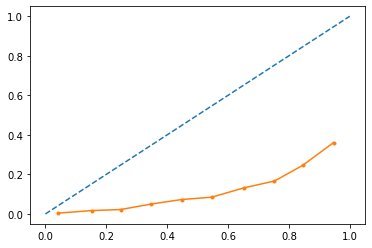

In [33]:
probs=clf_lgbm.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [51]:
params=itertools.product(np.split(np.repeat(np.arange(1,21),13),20,axis=0),np.arange(1,21))

a=[]
for i,j in params:
    s=dict(w=i,p=j)
    a.append(s)
    

In [52]:
knn=KNeighborsClassifier(n_neighbors=5,algorithm='auto',metric='wminkowski')

In [53]:
n_neighbors=np.arange(1,20)
weights=['uniform','distance']
leaf_size=np.arange(1,400)
p=[None]
metric_params=a
 
kneighbors_param=[{
            'n_neighbors':n_neighbors,
              'weights':weights,
              'leaf_size':leaf_size,
              'p':p,
              'metric_params':metric_params}]

randomized=RandomizedSearchCV(estimator=knn,  param_distributions=kneighbors_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [54]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(metric='wminkowski'),
                   n_iter=140, n_jobs=9,
                   param_distributions=[{'leaf_size': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  5...
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 8,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 9,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 10,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}, ...],
                                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                         'p': [None],
                                         'weights': ['uniform', 'distance']}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [55]:
randomized.best_params_

{'weights': 'distance',
 'p': None,
 'n_neighbors': 17,
 'metric_params': {'w': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},
 'leaf_size': 112}

In [71]:
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

knn.fit(x_train_auto,y_train)

preds=knn.predict(x_test_auto)

print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds),precision_score(y_test,preds),recall_score(y_test,preds))

#fpr, tpr, thresholds = roc_curve(y_test, preds[:,1], pos_label=1)

#plt.plot(fpr,tpr)
#plt.show()

[[4829  143]
 [ 488   45]] 0.527833352703847 0.2393617021276596 0.08442776735459662


In [93]:
clf = TabNetClassifier(n_d=20,n_a=20,
                         n_steps=5,
                         gamma=1.3,
                         lambda_sparse=0.01,
                         momentum=0.06,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )

Device used : cuda


In [94]:
n_d=[20,80,100]
n_a=[20,80,100]
n_steps=[2,3,4,5,8]

gamma=np.linspace(1,1.5,10)
momentum=np.linspace(0.01,0.4,10)
lambda_sparse=np.linspace(0.001,0.01,10)




forest_param=[{'n_d':n_d,
               'n_a':n_a,
               'n_steps':n_steps,
               'gamma':gamma,
               'momentum':momentum,
               'lambda_sparse':lambda_sparse}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=40,   
                              scoring='roc_auc', cv=skf ,n_jobs=10,random_state=42,verbose=4)

fit_param=dict(weights=1,max_epochs=50,batch_size=1024,virtual_batch_size=128)

In [95]:
randomized.fit(x_train_auto,y_train,**fit_param)

Device used : cuda
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device

C:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

epoch 39 | loss: 0.52777 |  0:01:16s
epoch 40 | loss: 0.52765 |  0:01:18s
epoch 41 | loss: 0.53229 |  0:01:20s
epoch 42 | loss: 0.53214 |  0:01:22s
epoch 43 | loss: 0.52953 |  0:01:24s
epoch 44 | loss: 0.53497 |  0:01:25s
epoch 45 | loss: 0.52858 |  0:01:27s
epoch 46 | loss: 0.52939 |  0:01:29s
epoch 47 | loss: 0.53032 |  0:01:31s
epoch 48 | loss: 0.52908 |  0:01:33s
epoch 49 | loss: 0.52237 |  0:01:35s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], lambda_sparse=0.01, mask_type='entmax', momentum=0.06, n_a=20, n_d=20, n_steps=5, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.96, 'step_size': 15}),
                   n_iter=40, n_...
                   param_distributions=[{'gamma': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                                         'lambda_sparse': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ]),
                                         'momentum': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                                         'n_a': [20, 80, 100],
                                         'n_d': [20, 80, 100],
                                         'n_steps': [2, 3, 4, 5, 8]}],
                   random_state=42, scoring='roc_auc', verbose=4)

In [96]:
randomized.best_params_

{'n_steps': 8,
 'n_d': 100,
 'n_a': 20,
 'momentum': 0.4,
 'lambda_sparse': 0.004,
 'gamma': 1.2222222222222223}

In [97]:
randomized.best_score_

0.7974908792325826

In [98]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [99]:
df_randomised_result.to_csv('param_tabnet.csv')

In [100]:
print(df_randomised_result,'\n\n',randomized.best_params_)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      130.211676      3.604482         0.126063        0.042886   
1      123.287463      0.973582         0.155884        0.055725   
2      289.827347      1.558678         0.296208        0.242808   
3      204.477118     12.956618         0.399232        0.370282   
4      390.135070      9.325001         0.458873        0.545044   
5      147.416928      5.624100         0.435934        0.526921   
6      146.476145     22.980989         0.103922        0.008542   
7      410.879588     11.205067         0.838258        0.670705   
8      232.878259     22.009960         0.491486        0.605747   
9      190.064566      7.654926         0.298501        0.433838   
10     263.259104      7.292672         0.540055        0.560233   
11     146.191306      4.326022         0.221807        0.321607   
12     144.887594      3.679971         0.214326        0.354597   
13     365.791577      8.253573         0.592414

In [34]:

 
balanced_accu_tabnet=[]
auc_tabnet=[]
recall_tabnet=[]
precision_tabnet=[]
 
for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    
    clf_tab = TabNetClassifier(n_d=100,n_a=20,
                         n_steps=8,
                         gamma=1.2,
                         lambda_sparse=0.004,
                         momentum=0.4,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )
    clf_tab.fit(X_train, Y_train,
          weights=1,
          max_epochs=300,
          eval_set=[(X_train, Y_train), (X_test, Y_test)],
          eval_name=['train', 'valid'],
          batch_size=1024, virtual_batch_size=128,
          eval_metric=['balanced_accuracy'],patience=20)
    
    preds_proba=clf_tab.predict_proba(X_test)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_tabnet.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_tabnet.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_tabnet.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_tabnet.append(score)
    
balanced_accu_array=np.array(balanced_accu_tabnet)
auc_array=np.array(auc_tabnet)
precision_array=np.array(precision_tabnet)
recall_array=np.array(recall_tabnet)

print(f'balanced_accuracy:{np.mean(balanced_accu_array)}\nAUC:{np.mean(auc_array)}\nPrecision:{np.mean(precision_array)}\nRecall:{np.mean(recall_array)}')

TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Device used : cuda
epoch 0  | loss: 1.29215 | train_balanced_accuracy: 0.52029 | valid_balanced_accuracy: 0.51667 |  0:00:02s
epoch 1  | loss: 0.83869 | train_balanced_accuracy: 0.56608 | valid_balanced_accuracy: 0.5641  |  0:00:04s
epoch 2  | loss: 0.67855 | train_balanced_accuracy: 0.58603 | valid_balanced_accuracy: 0.59075 |  0:00:07s
epoch 3  | loss: 0.61625 | train_balanced_accuracy: 0.66157 | valid_balanced_accuracy: 0.66941 |  0:00:09s
epoch 4  | loss: 0.57689 | train_balanced_accuracy: 0.64967 | valid_balanced_accuracy: 0.65526 |  0:00:12s
epoch 5  | loss: 0.54575 | train_balanced_accuracy: 0.67735 | valid_balanced_accuracy: 0.66773 |  0:00:14s
epoch 6  | loss: 0.54333 | train_balanced_accuracy: 0.68124 | valid_balanced_accuracy: 0.67083 |  0:00:16s
epoch 7  | loss: 0.54614 | train_balanced_accuracy: 0.70552 | valid_balanced_accuracy: 0.68372 |  0:00:19s
epoch 8  | loss: 0.54445 | t

epoch 21 | loss: 0.53234 | train_balanced_accuracy: 0.73728 | valid_balanced_accuracy: 0.71981 |  0:00:51s
epoch 22 | loss: 0.53539 | train_balanced_accuracy: 0.73532 | valid_balanced_accuracy: 0.70398 |  0:00:54s
epoch 23 | loss: 0.52731 | train_balanced_accuracy: 0.73446 | valid_balanced_accuracy: 0.72157 |  0:00:56s
epoch 24 | loss: 0.53465 | train_balanced_accuracy: 0.73367 | valid_balanced_accuracy: 0.70665 |  0:00:58s
epoch 25 | loss: 0.53124 | train_balanced_accuracy: 0.73757 | valid_balanced_accuracy: 0.70767 |  0:01:01s
epoch 26 | loss: 0.53076 | train_balanced_accuracy: 0.73926 | valid_balanced_accuracy: 0.71102 |  0:01:03s
epoch 27 | loss: 0.52618 | train_balanced_accuracy: 0.73495 | valid_balanced_accuracy: 0.69954 |  0:01:06s
epoch 28 | loss: 0.52979 | train_balanced_accuracy: 0.73605 | valid_balanced_accuracy: 0.69854 |  0:01:08s
epoch 29 | loss: 0.52608 | train_balanced_accuracy: 0.73845 | valid_balanced_accuracy: 0.70842 |  0:01:10s
epoch 30 | loss: 0.53039 | train_bala

epoch 39 | loss: 0.53364 | train_balanced_accuracy: 0.73711 | valid_balanced_accuracy: 0.72778 |  0:01:34s
epoch 40 | loss: 0.52372 | train_balanced_accuracy: 0.73973 | valid_balanced_accuracy: 0.73391 |  0:01:36s
epoch 41 | loss: 0.52892 | train_balanced_accuracy: 0.73596 | valid_balanced_accuracy: 0.73205 |  0:01:38s
epoch 42 | loss: 0.52289 | train_balanced_accuracy: 0.73905 | valid_balanced_accuracy: 0.72895 |  0:01:41s
epoch 43 | loss: 0.52744 | train_balanced_accuracy: 0.73314 | valid_balanced_accuracy: 0.72662 |  0:01:43s
epoch 44 | loss: 0.52822 | train_balanced_accuracy: 0.73672 | valid_balanced_accuracy: 0.73047 |  0:01:45s
epoch 45 | loss: 0.52181 | train_balanced_accuracy: 0.73632 | valid_balanced_accuracy: 0.74069 |  0:01:48s
epoch 46 | loss: 0.519   | train_balanced_accuracy: 0.73158 | valid_balanced_accuracy: 0.72793 |  0:01:50s
epoch 47 | loss: 0.53174 | train_balanced_accuracy: 0.73344 | valid_balanced_accuracy: 0.73131 |  0:01:53s
epoch 48 | loss: 0.52747 | train_bala

epoch 48 | loss: 0.53441 | train_balanced_accuracy: 0.73643 | valid_balanced_accuracy: 0.75007 |  0:01:59s
epoch 49 | loss: 0.53029 | train_balanced_accuracy: 0.73262 | valid_balanced_accuracy: 0.73654 |  0:02:01s
epoch 50 | loss: 0.52616 | train_balanced_accuracy: 0.74061 | valid_balanced_accuracy: 0.75539 |  0:02:04s
epoch 51 | loss: 0.52284 | train_balanced_accuracy: 0.73802 | valid_balanced_accuracy: 0.74849 |  0:02:06s
epoch 52 | loss: 0.52827 | train_balanced_accuracy: 0.74098 | valid_balanced_accuracy: 0.75506 |  0:02:08s
epoch 53 | loss: 0.52716 | train_balanced_accuracy: 0.7389  | valid_balanced_accuracy: 0.75122 |  0:02:11s
epoch 54 | loss: 0.52125 | train_balanced_accuracy: 0.73675 | valid_balanced_accuracy: 0.7473  |  0:02:13s
epoch 55 | loss: 0.52552 | train_balanced_accuracy: 0.74281 | valid_balanced_accuracy: 0.74611 |  0:02:16s
epoch 56 | loss: 0.52495 | train_balanced_accuracy: 0.73708 | valid_balanced_accuracy: 0.73281 |  0:02:18s
epoch 57 | loss: 0.52208 | train_bala

epoch 9  | loss: 0.53808 | train_balanced_accuracy: 0.71178 | valid_balanced_accuracy: 0.69223 |  0:00:23s
epoch 10 | loss: 0.54069 | train_balanced_accuracy: 0.72184 | valid_balanced_accuracy: 0.70921 |  0:00:26s
epoch 11 | loss: 0.52888 | train_balanced_accuracy: 0.72385 | valid_balanced_accuracy: 0.70533 |  0:00:28s
epoch 12 | loss: 0.53734 | train_balanced_accuracy: 0.72255 | valid_balanced_accuracy: 0.69782 |  0:00:30s
epoch 13 | loss: 0.53703 | train_balanced_accuracy: 0.72581 | valid_balanced_accuracy: 0.7012  |  0:00:33s
epoch 14 | loss: 0.54037 | train_balanced_accuracy: 0.73169 | valid_balanced_accuracy: 0.71603 |  0:00:35s
epoch 15 | loss: 0.53408 | train_balanced_accuracy: 0.7347  | valid_balanced_accuracy: 0.70741 |  0:00:37s
epoch 16 | loss: 0.53468 | train_balanced_accuracy: 0.73676 | valid_balanced_accuracy: 0.72429 |  0:00:40s
epoch 17 | loss: 0.53681 | train_balanced_accuracy: 0.72589 | valid_balanced_accuracy: 0.72065 |  0:00:42s
epoch 18 | loss: 0.53274 | train_bala

epoch 40 | loss: 0.5398  | train_balanced_accuracy: 0.73301 | valid_balanced_accuracy: 0.71338 |  0:01:36s
epoch 41 | loss: 0.54193 | train_balanced_accuracy: 0.73242 | valid_balanced_accuracy: 0.72289 |  0:01:38s
epoch 42 | loss: 0.53911 | train_balanced_accuracy: 0.7341  | valid_balanced_accuracy: 0.72128 |  0:01:41s
epoch 43 | loss: 0.53462 | train_balanced_accuracy: 0.73442 | valid_balanced_accuracy: 0.71571 |  0:01:43s
epoch 44 | loss: 0.52796 | train_balanced_accuracy: 0.7342  | valid_balanced_accuracy: 0.71128 |  0:01:45s
epoch 45 | loss: 0.52767 | train_balanced_accuracy: 0.73836 | valid_balanced_accuracy: 0.71485 |  0:01:48s
epoch 46 | loss: 0.52635 | train_balanced_accuracy: 0.737   | valid_balanced_accuracy: 0.71193 |  0:01:50s
epoch 47 | loss: 0.53193 | train_balanced_accuracy: 0.73775 | valid_balanced_accuracy: 0.70931 |  0:01:52s
epoch 48 | loss: 0.52834 | train_balanced_accuracy: 0.73853 | valid_balanced_accuracy: 0.71359 |  0:01:55s
epoch 49 | loss: 0.53122 | train_bala

epoch 6  | loss: 0.54703 | train_balanced_accuracy: 0.68445 | valid_balanced_accuracy: 0.67497 |  0:00:16s
epoch 7  | loss: 0.53739 | train_balanced_accuracy: 0.69999 | valid_balanced_accuracy: 0.68637 |  0:00:18s
epoch 8  | loss: 0.54642 | train_balanced_accuracy: 0.7021  | valid_balanced_accuracy: 0.68964 |  0:00:21s
epoch 9  | loss: 0.52751 | train_balanced_accuracy: 0.7068  | valid_balanced_accuracy: 0.7023  |  0:00:23s
epoch 10 | loss: 0.54481 | train_balanced_accuracy: 0.71457 | valid_balanced_accuracy: 0.71127 |  0:00:25s
epoch 11 | loss: 0.54233 | train_balanced_accuracy: 0.72363 | valid_balanced_accuracy: 0.71269 |  0:00:28s
epoch 12 | loss: 0.54053 | train_balanced_accuracy: 0.72936 | valid_balanced_accuracy: 0.7303  |  0:00:30s
epoch 13 | loss: 0.53507 | train_balanced_accuracy: 0.72442 | valid_balanced_accuracy: 0.71521 |  0:00:32s
epoch 14 | loss: 0.53988 | train_balanced_accuracy: 0.72921 | valid_balanced_accuracy: 0.72912 |  0:00:35s
epoch 15 | loss: 0.53685 | train_bala

epoch 48 | loss: 0.52814 | train_balanced_accuracy: 0.73804 | valid_balanced_accuracy: 0.72762 |  0:01:56s
epoch 49 | loss: 0.53126 | train_balanced_accuracy: 0.74151 | valid_balanced_accuracy: 0.73759 |  0:01:59s
epoch 50 | loss: 0.52985 | train_balanced_accuracy: 0.73793 | valid_balanced_accuracy: 0.74296 |  0:02:01s
epoch 51 | loss: 0.53254 | train_balanced_accuracy: 0.73611 | valid_balanced_accuracy: 0.72946 |  0:02:03s
epoch 52 | loss: 0.52527 | train_balanced_accuracy: 0.7428  | valid_balanced_accuracy: 0.73592 |  0:02:06s
epoch 53 | loss: 0.53045 | train_balanced_accuracy: 0.7379  | valid_balanced_accuracy: 0.74958 |  0:02:08s
epoch 54 | loss: 0.51968 | train_balanced_accuracy: 0.73735 | valid_balanced_accuracy: 0.74589 |  0:02:10s
epoch 55 | loss: 0.52586 | train_balanced_accuracy: 0.7373  | valid_balanced_accuracy: 0.73524 |  0:02:13s
epoch 56 | loss: 0.53496 | train_balanced_accuracy: 0.73668 | valid_balanced_accuracy: 0.73734 |  0:02:15s

Early stopping occurred at epoch 56 

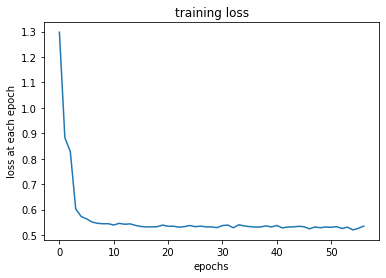

In [35]:
plt.plot(clf_tab.history['loss'])
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss at each epoch')
plt.show()

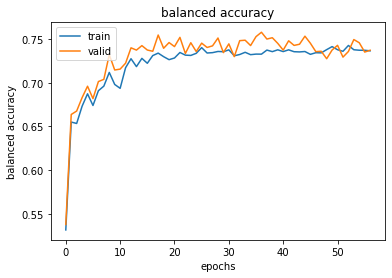

In [36]:
plt.plot(clf_tab.history['train_balanced_accuracy'],label='train')
plt.plot(clf_tab.history['valid_balanced_accuracy'],label='valid')
plt.title('balanced accuracy')
plt.xlabel('epochs')
plt.ylabel('balanced accuracy')
plt.legend(loc='upper left')
plt.show()

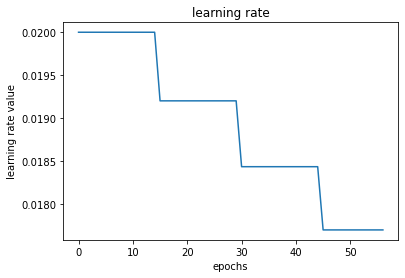

In [37]:
plt.plot(clf_tab.history['lr'])
plt.title('learning rate')
plt.xlabel('epochs')
plt.ylabel('learning rate value')
plt.show()

In [69]:
preds = clf_tab.predict(x_test_auto)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds),precision_score(y_test,preds),recall_score(y_test,preds))

[[3358 1614]
 [ 108  425]] 0.7363777491664389 0.20843550760176557 0.797373358348968


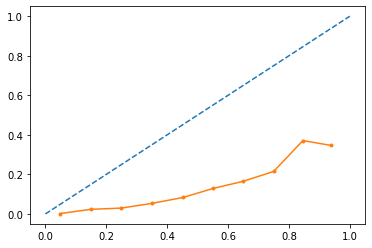

In [39]:
probs=clf_tab.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

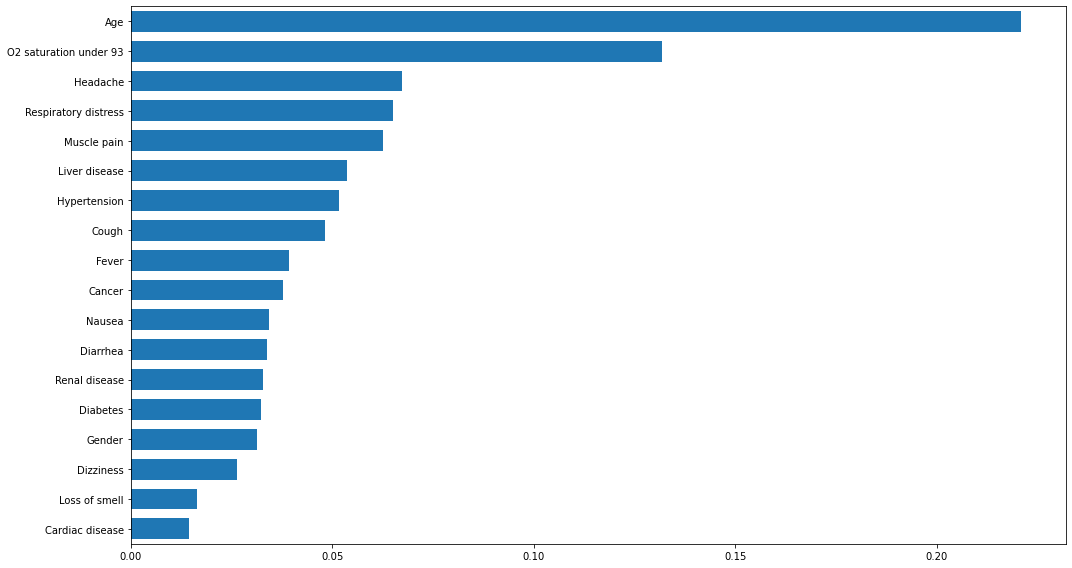

array([0.22094244, 0.13175297, 0.06498755, 0.05176608, 0.01446397,
       0.0322628 , 0.0625602 , 0.04818336, 0.0673711 , 0.03935261,
       0.03272397, 0.0376936 , 0.03437701, 0.01641717, 0.02637562,
       0.03126216, 0.05362156, 0.03388583])

In [40]:
tree_importance_sorted_idx = np.argsort(clf_tab.feature_importances_)
tree_indices = np.arange(0, clf_tab.feature_importances_.shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         clf_tab.feature_importances_[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,clf_tab.feature_importances_.shape[0]))


fig.tight_layout()
plt.show()







clf_tab.feature_importances_

In [49]:
saving_path_name = "./tabnet_model"
saved_filepath = clf_tab.save_model(saving_path_name)
#clf_tab2 = TabNetClassifier()
#clf_tab2.load_model('test/tabnet_model_denoise.zip')

Successfully saved model at ./tabnet_model.zip


In [45]:
x_test_me=np.repeat(0,18)
x_test_me[0]=33
x_test_preprocessed=column_transfromer_f.transform(x_test_me.reshape(1,-1))
x_test_denoise=model.predict(x_test_preprocessed)

In [46]:
x_test_preprocessed

array([[0.17241379, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [47]:
x_test_denoise

array([[1.7371446e-01, 1.3950348e-02, 4.4091105e-02, 2.6836991e-03,
        2.6856065e-03, 8.4981620e-03, 5.1870912e-02, 6.7774147e-02,
        3.4796774e-02, 5.2283794e-02, 2.5132070e-07, 3.1012297e-04,
        4.7049224e-03, 5.2818358e-03, 1.5447438e-03, 5.4685384e-02,
        1.4366210e-03, 2.6473403e-03]], dtype=float32)

In [33]:
explain_matrix, masks = loaded_clf.explain(x_test_denoise)

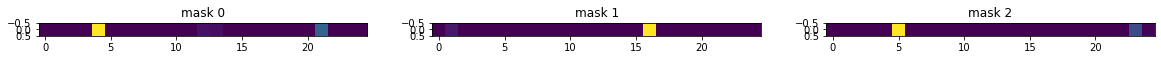

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i])
    axs[i].set_title(f"mask {i}")

In [48]:
clf_tab.predict_proba(x_test_denoise)

array([[0.95119727, 0.0488027 ]], dtype=float32)

In [50]:
#models  selection
# random forest
clf_random=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.03628,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)

scores_random=cross_validate(clf_random,x_train_auto,y_train,cv=skf,
                             scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#logistic regression
clf_log_regression=LogisticRegression(penalty='elasticnet',C=1.5,solver='saga',class_weight='balanced',
                                      l1_ratio=0.39,max_iter=800)

scores_log_regression=cross_validate(clf_log_regression,x_train_auto,y_train,cv=skf,
                                      scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# svm
clf_svc=svm.SVC(C=8.42,kernel='linear',degree=3,gamma=0.45,coef0=1.84,shrinking=True,class_weight='balanced')

scores_svc=cross_validate(clf_svc,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# knn
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',
                         metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

scores_knn=cross_validate(knn,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#lgbm
scores_balanced_lgbm=np.array(balanced_accu_lgbm)
scores_auc_lgbm=np.array(auc_lgbm)
scores_precision_lgbm=np.array(precision_lgbm)
scores_recall_lgbm=np.array(recall_lgbm)

#tabnet
scores_balanced_tabnet=np.array(balanced_accu_tabnet)
scores_auc_tabnet=np.array(auc_tabnet)
scores_precision_tabnet=np.array(precision_tabnet)
scores_recall_tabnet=np.array(recall_tabnet)

# neural net







In [41]:
scores_random.keys()

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_roc_auc', 'test_precision', 'test_recall'])

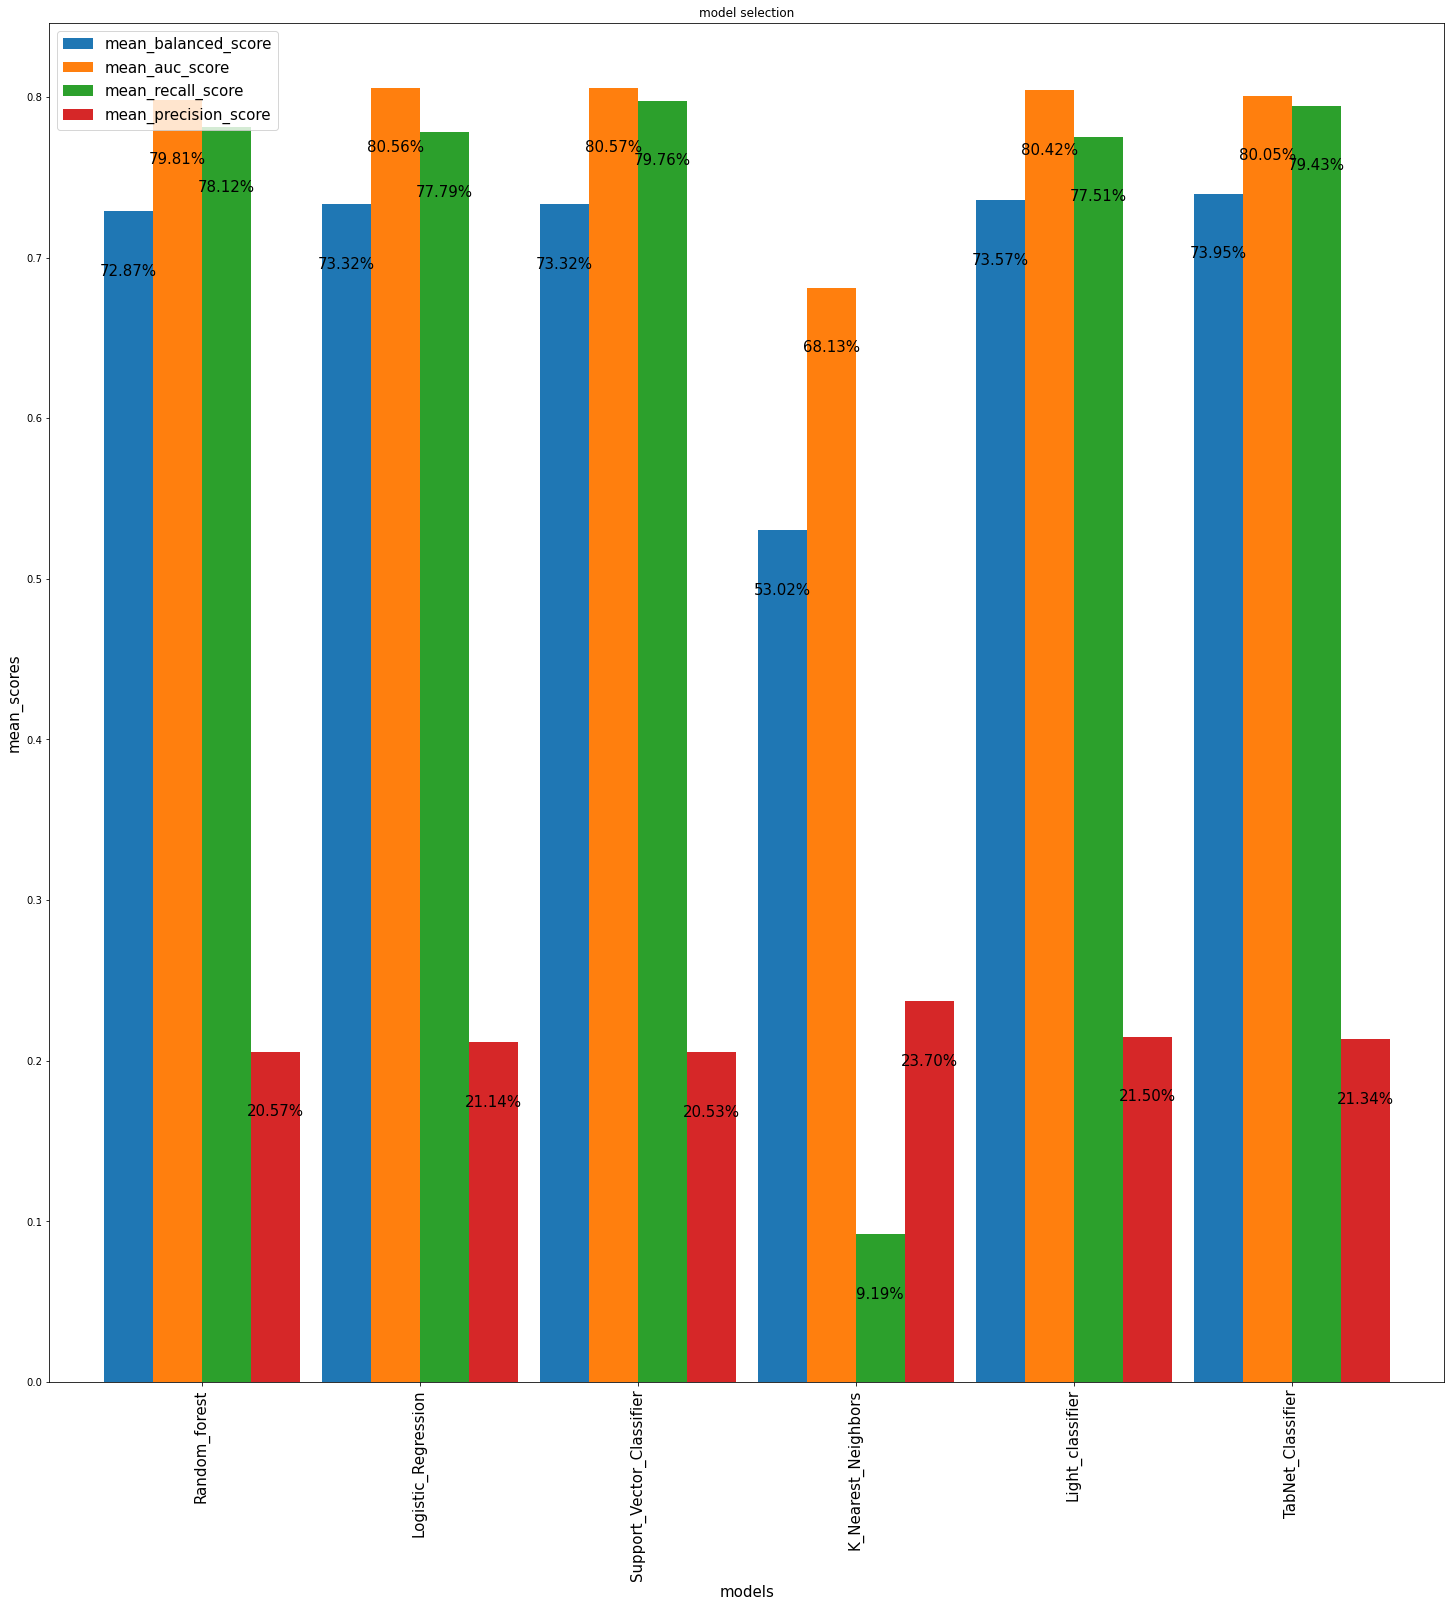

In [51]:
df_models=pd.DataFrame({'mean_balanced_score':[np.mean(scores_random['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_log_regression['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_svc['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_knn['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_balanced_lgbm,axis=0),np.mean(scores_balanced_tabnet,axis=0)],
                        
                        'mean_auc_score':[np.mean(scores_random['test_roc_auc'],axis=0),
                                          np.mean(scores_log_regression['test_roc_auc'],axis=0),
                                      np.mean(scores_svc['test_roc_auc'],axis=0),
                                          np.mean(scores_knn['test_roc_auc'],axis=0),
                                      np.mean(scores_auc_lgbm,axis=0),np.mean(scores_auc_tabnet,axis=0)]   ,
                        
                        'mean_recall_score': [np.mean(scores_random['test_recall'],axis=0),
                                          np.mean(scores_log_regression['test_recall'],axis=0),
                                      np.mean(scores_svc['test_recall'],axis=0),
                                          np.mean(scores_knn['test_recall'],axis=0),
                                      np.mean(scores_recall_lgbm,axis=0),np.mean(scores_recall_tabnet,axis=0)]  ,
                        
                        'mean_precision_score':[np.mean(scores_random['test_precision'],axis=0),
                                          np.mean(scores_log_regression['test_precision'],axis=0),
                                      np.mean(scores_svc['test_precision'],axis=0),
                                          np.mean(scores_knn['test_precision'],axis=0),
                                      np.mean(scores_precision_lgbm,axis=0),np.mean(scores_precision_tabnet,axis=0)] },
                       
                       index=np.array(['Random_forest','Logistic_Regression','Support_Vector_Classifier',
                                       'K_Nearest_Neighbors','Light_classifier','TabNet_Classifier']) )

plot=df_models.plot(kind='bar',rot=90,width=0.9,figsize=(25,25))

for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    
    plot.annotate(f'{100*height:.2f}%', (x + 0.5*width, y + height-0.04), ha='center',fontsize=15)
    
plot.set_xticklabels(df_models.index,fontsize=15)    
plt.legend(loc='upper left',fontsize=15)
plt.title('model selection')
plt.xlabel('models',fontsize=15)
plt.ylabel('mean_scores',fontsize=15)
plt.show()

In [68]:
u,p=stats.wilcoxon(scores_log_regression['test_balanced_accuracy'],scores_balanced_tabnet,zero_method='zsplit',mode='auto')

print(f'wilcoxon:{u}\np-value:{p:.2f}')

wilcoxon:1.0
p-value:0.00


In [354]:
log_reg=scores_log_regression['test_balanced_accuracy']

In [355]:
print(f'std_tabnet: {np.std(scores_recall_tabnet,axis=0)}\nstd_LightGBM: {np.std(scores_balanced_lgbm,axis=0)}\nstd_logistic: {np.std(log_reg,axis=0)}')

std_tabnet: 0.04334023037317688
std_LightGBM: 0.009606966824919922
std_logistic: 0.014286490061194337
